## <center> Setup: Import Libraries & Define Data Paths

In this first section we get everything ready for our analysis. We begin by loading all of the Python packages we will need. Immediately after the imports, we define a series of variables—one for each CSV file we’ll load later. By assigning each dataset path to a clearly named variable (for example, tau_file = "ttau_ptau.csv" or cdr_file = "CDR.csv"), we make it easy to change those locations in one place if our data folder ever moves or is reorganized.

In [1]:
# === General utilities ===
import os
import csv
import json
import logging
from pathlib import Path
from functools import reduce

# === Scientific stack ===
import numpy as np
import pandas as pd
from scipy.stats import (
    ttest_rel,            # paired t-test
    t as student_t,       # alias kept intentionally
    pearsonr,
    wilcoxon
)
from scipy.spatial.distance import squareform
import os, re

# === Machine learning / preprocessing ===
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# === Clustering / dimensionality reduction ===
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from sklearn.cluster import DBSCAN
from umap.umap_ import UMAP
from openTSNE import TSNE as oTSNE

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Parallelization ===
from joblib import Parallel, delayed
import joblib

# === Deep learning (TensorFlow/Keras) ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout,
    Bidirectional, LSTM, Dense, TimeDistributed,
    Lambda, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, LambdaCallback

# === Xarray (multidimensional data handling) ===
import xarray as xr


# File Paths
tau_file = r"ttau_ptau.csv"
cdr_file = r"CDR.csv"
faq_file = r"FunctionalActivitiesQuestionnaire.csv"
mmse_file = r"MMSE.csv"
neurobattery_file = r"NEUROBAT.csv"
demographics_file = r"DemographicInfo.csv"
vitals_file = r"VITALS.csv"
neuroexam_file = r"NEUROExam.csv"
diagnosis_file = r"diagnosis.csv"
plasma_biomarker_file = r"plasmaBiomarkers.csv"
genotype_file = r"genotype.csv"
family_history_parents_file = r"FamilyParents.csv"
family_history_siblings_file = r"FamilySiblings.csv"
family_history_whole_file = r"FamilyWhole.csv"
csf_file = r"CSF.csv"
npiq_file = r"NPIQ.csv"
PETamy_file = r"PET_amy_6mm.csv"
genetic_file = r"GeneticData.csv"
medical_history_file = r"MedicalHistory.csv"
adas1_file = r"ADAS_ADNI1.csv"
adasGO23_file = r"ADAS_ADNIGO23.csv"
av45PET_file = r"AV45.csv"
moca_file = r"MOCA.csv"
FoxLabMRI_file = r"FOXlabMRI.csv"
MRIcomprehensive_file = r"MRIcomprehensive.csv"
ucsfFreesurferMRI_file = r"UCSFfreesurferMRI.csv"
mriDatasetUSCF_file = r"MRIdatasetUSCF.csv"
adspCognitive_file = r"ADSPcognitive.csv"
embicCognitive_file = r"EMBICneuro.csv"
embicDigital_file = r"EMBICdigital.csv"
neuropathology_file = r"neuropathology.csv"
GeriatricDepressionScale_file = r"GeriatricDepressionScale.csv"
lipidomics_file = r"lipidomics.csv"
lipoproteins_file = r"LipoproteinsAndMetabolites.csv"
GutMetabolites_file = r"gutmetabolites.csv"
PlasmaNFL = r"PlasmaNFL.csv"
uu_PET_file = r"uu_PET.csv"
csfbiobank_file = r"CSF_ROCHEbiobank.csv"
proteinmatrix_file = r"proteinmatrix.csv"
bileacids_file = r"bileacids.csv"
csfinflammatoryproteins_file = r"csfinflammatoryproteins.csv"
ptau181_file = r"ptau181.csv"
ravlt_file = r"RAVLT.csv"
pet_amyloid_detailed_file = r"ADSP_PET_Amyloid_Detailed.csv"
pet_tau_detailed_file = r"ADSP_PHC_PET_Tau_Detailed.csv"

## <center> Step 1: Unified VISCODE Normalization and CSV Loader for Longitudinal Visit Data

Here we define two helper functions to standardize and load visit codes (VISCODE) across all our datasets.

map_viscode_to_month: Converts various visit code formats (e.g., “bl”, “v03”, “y1.5”) into a consistent monthly format (e.g., “bl”, “m06”, “m18”). Baseline visits are all mapped to “bl”, codes starting with “m” are left unchanged, “y”-prefixed year codes are converted to months, and legacy “vXX” codes are translated according to our predefined mapping.

load_with_viscode: Reads a CSV file, ensures a single VISCODE column (filling from VISCODE2 or defaulting to baseline), filters to only the columns you need, coerces RID to integer and drops invalid entries, and then applies map_viscode_to_month to harmonize all visit codes before returning the cleaned DataFrame.

Using these functions ensures that every dataset you load will have a consistent, month-based visit identifier ready for merging and analysis.

In [2]:
# Unified VISCODE Processing Functions
def map_viscode_to_month(vis):
    """
    Convert a visit code into a unified format matching the paper's methodology.
    Baseline codes are mapped to "bl". Other codes are converted if necessary.
    """
    vis = str(vis).lower().strip()
    baseline_codes = {"bl", "init", "sc", "v01", "4_init", "4_sc", "4_bl", "4-init"}
    if vis in baseline_codes:
        return "bl"
    if vis.startswith("m"):
        return vis
    if vis.startswith("y"):
        try:
            year_num = float(vis[1:])
            months = int(round(year_num * 12))
            return f"m{months}"
        except Exception as e:
            return vis
    if vis.startswith("v"):
        mapping = {
            "v03": "m06",
            "v06": "m12",
            "v11": "m18",
            "v21": "m24",
            "v41": "m48"
        }
        return mapping.get(vis, vis)
    return vis


def load_with_viscode(file_path, relevant_columns, require_viscode=True):
    """
    Loads a CSV file and returns a DataFrame with a unified VISCODE column.
    If both VISCODE and VISCODE2 are present, fills missing VISCODE values with VISCODE2.
    If neither is present, adds VISCODE="bl". Only the specified columns are kept.
    """
    df = pd.read_csv(file_path, low_memory=False)
    
    if "VISCODE" not in df.columns and "VISCODE2" not in df.columns:
        df["VISCODE"] = "bl"
    
    if require_viscode:
        if "VISCODE" not in df.columns and "VISCODE2" in df.columns:
            df.rename(columns={"VISCODE2": "VISCODE"}, inplace=True)
        elif "VISCODE" in df.columns and "VISCODE2" in df.columns:
            df["VISCODE"] = df["VISCODE"].fillna(df["VISCODE2"])
            df.drop(columns=["VISCODE2"], inplace=True)
        if "VISCODE" not in df.columns:
            raise KeyError(f"'VISCODE' not found in {file_path} and no VISCODE2 available.")
    
    df = df[relevant_columns]
    
    if "RID" in df.columns:
        df["RID"] = pd.to_numeric(df["RID"], errors='coerce')
        df = df.dropna(subset=["RID"])
        df["RID"] = df["RID"].astype(int)
    
    if "VISCODE" in df.columns:
        df["VISCODE"] = df["VISCODE"].apply(map_viscode_to_month)
    
    return df

## <center> step 2: Function to Drop Features with Excessive Missing Values at Baseline

This function scans your DataFrame’s baseline visits (where VISCODE=="bl") and computes the percentage of missing values for each column. Any feature (except RID and VISCODE) with more than the specified threshold (default 30%) missing at baseline is removed. It prints out which columns are dropped and returns the cleaned DataFrame, helping you eliminate variables that lack sufficient data at the start of the study.

In [3]:
# Drop Columns with >30% Missing at Baseline

def drop_high_missing_baseline(df, threshold_pct=30):
    """
    For a DataFrame with a VISCODE column, drop columns (other than RID and VISCODE)
    where the percentage of missing values among baseline (VISCODE=="bl") rows
    exceeds threshold_pct.
    """
    if "VISCODE" not in df.columns:
        return df

    # select only the baseline visits
    baseline_df = df[df["VISCODE"] == "bl"]
    if baseline_df.empty:
        return df

    # compute missing percentage per column
    missing_pct = baseline_df.isna().mean() * 100

    # find which columns exceed the threshold
    cols_to_drop = missing_pct[missing_pct > threshold_pct].index.tolist()

    # never drop RID or VISCODE
    cols_to_drop = [c for c in cols_to_drop if c not in ("RID", "VISCODE")]

    if cols_to_drop:
        print(f"Dropping columns with >{threshold_pct}% missing at baseline:", cols_to_drop)

    return df.drop(columns=cols_to_drop)

## <center>Step 3: Comprehensive Data Loading Block for Multimodal Biomarkers and Clinical Datasets (Unified by VISCODE)

This code block loads multiple heterogeneous datasets (plasma, CSF, imaging, neurocognitive, genetic, clinical, metabolomics, MRI, etc.) using a standardized function load_with_viscode(). It ensures all datasets are aligned by RID and VISCODE, enabling longitudinal and cross-modal analyses for studies like Alzheimer's, dementia, or other aging-related research

In [4]:
# Load All Datasets
tau_data = load_with_viscode(tau_file, ["RID", "VISCODE", "PTAU"])
ptau181_data = load_with_viscode(ptau181_file, ["RID", "VISCODE", "PLASMAPTAU181"])
ravlt_data = load_with_viscode(ravlt_file, ["RID", "VISCODE", "RAVLT_immediate", "RAVLT_learning",
                                            "RAVLT_forgetting", "RAVLT_perc_forgetting"])
cdr_data = load_with_viscode(cdr_file, ["RID", "VISCODE", "CDRSB"])
csfinflammatoryproteins_data = load_with_viscode(csfinflammatoryproteins_file, [
    "RID", "VISCODE", "TNFR1", "TNFR2", "TGFBETA1", "TGFBETA2", "TGFBETA3", 
    "IL_21", "IL_6", "IL_7", "IL_9", "IL_10", "TNFALPHA", "IP_10", "IL_12_P40",
    "ICAM_1", "VCAM_1"
])
pet_tau_detailed_data = load_with_viscode(pet_tau_detailed_file, [
    "RID", "VISCODE", "NPDKA_INFERIORCEREBELLUM", "BRAINSTEM_SUVR",
    "VENTRICLE_3RD_SUVR", "VENTRICLE_4TH_SUVR", "VENTRICLE_5TH_SUVR", "CC_ANTERIOR_SUVR", "CC_CENTRAL_SUVR",
    "CC_MID_ANTERIOR_SUVR", "CC_MID_POSTERIOR_SUVR", "CC_POSTERIOR_SUVR", "CSF_SUVR", "OPTIC_CHIASM_SUVR",
    "NON_WM_HYPOINTENSITIES_SUVR", "WM_HYPOINTENSITIES_SUVR", "CTX_LH_BANKSSTS_SUVR",
    "CTX_LH_CAUDALANTERIORCINGULATE_SUVR", "CTX_LH_CAUDALMIDDLEFRONTAL_SUVR", "CTX_LH_CUNEUS_SUVR",
    "CTX_LH_ENTORHINAL_SUVR", "CTX_LH_FRONTALPOLE_SUVR", "CTX_LH_FUSIFORM_SUVR", "CTX_LH_INFERIORPARIETAL_SUVR",
    "CTX_LH_INFERIORTEMPORAL_SUVR", "CTX_LH_INSULA_SUVR", "CTX_LH_ISTHMUSCINGULATE_SUVR",
    "CTX_LH_LATERALOCCIPITAL_SUVR", "CTX_LH_LATERALORBITOFRONTAL_SUVR", "CTX_LH_LINGUAL_SUVR",
    "CTX_LH_MEDIALORBITOFRONTAL_SUVR", "CTX_LH_MIDDLETEMPORAL_SUVR", "CTX_LH_PARACENTRAL_SUVR",
    "CTX_LH_PARAHIPPOCAMPAL_SUVR", "CTX_LH_PARSOPERCULARIS_SUVR", "CTX_LH_PARSORBITALIS_SUVR",
    "CTX_LH_PARSTRIANGULARIS_SUVR", "CTX_LH_PERICALCARINE_SUVR", "CTX_LH_POSTCENTRAL_SUVR",
    "CTX_LH_POSTERIORCINGULATE_SUVR", "CTX_LH_PRECENTRAL_SUVR", "CTX_LH_PRECUNEUS_SUVR",
    "CTX_LH_ROSTRALANTERIORCINGULATE_SUVR", "CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR", "CTX_LH_SUPERIORFRONTAL_SUVR",
    "CTX_LH_SUPERIORPARIETAL_SUVR", "CTX_LH_SUPERIORTEMPORAL_SUVR", "CTX_LH_SUPRAMARGINAL_SUVR",
    "CTX_LH_TEMPORALPOLE_SUVR", "CTX_LH_TRANSVERSETEMPORAL_SUVR", "CTX_RH_BANKSSTS_SUVR",
    "CTX_RH_CAUDALANTERIORCINGULATE_SUVR", "CTX_RH_CAUDALMIDDLEFRONTAL_SUVR", "CTX_RH_CUNEUS_SUVR",
    "CTX_RH_ENTORHINAL_SUVR", "CTX_RH_FRONTALPOLE_SUVR", "CTX_RH_FUSIFORM_SUVR", "CTX_RH_INFERIORPARIETAL_SUVR",
    "CTX_RH_INFERIORTEMPORAL_SUVR", "CTX_RH_INSULA_SUVR", "CTX_RH_ISTHMUSCINGULATE_SUVR",
    "CTX_RH_LATERALOCCIPITAL_SUVR", "CTX_RH_LATERALORBITOFRONTAL_SUVR", "CTX_RH_LINGUAL_SUVR",
    "CTX_RH_MEDIALORBITOFRONTAL_SUVR", "CTX_RH_MIDDLETEMPORAL_SUVR", "CTX_RH_PARACENTRAL_SUVR",
    "CTX_RH_PARAHIPPOCAMPAL_SUVR", "CTX_RH_PARSOPERCULARIS_SUVR", "CTX_RH_PARSORBITALIS_SUVR",
    "CTX_RH_PARSTRIANGULARIS_SUVR", "CTX_RH_PERICALCARINE_SUVR", "CTX_RH_POSTCENTRAL_SUVR",
    "CTX_RH_POSTERIORCINGULATE_SUVR", "CTX_RH_PRECENTRAL_SUVR", "CTX_RH_PRECUNEUS_SUVR",
    "CTX_RH_ROSTRALANTERIORCINGULATE_SUVR", "CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR", "CTX_RH_SUPERIORFRONTAL_SUVR",
    "CTX_RH_SUPERIORPARIETAL_SUVR", "CTX_RH_SUPERIORTEMPORAL_SUVR", "CTX_RH_SUPRAMARGINAL_SUVR",
    "CTX_RH_TEMPORALPOLE_SUVR", "CTX_RH_TRANSVERSETEMPORAL_SUVR", "LEFT_ACCUMBENS_AREA_SUVR",
    "LEFT_AMYGDALA_SUVR", "LEFT_CAUDATE_SUVR", "LEFT_CEREBELLUM_CORTEX_SUVR", "LEFT_CEREBELLUM_WHITE_MATTER_SUVR",
    "LEFT_CEREBRAL_WHITE_MATTER_SUVR", "LEFT_CHOROID_PLEXUS_SUVR", "LEFT_HIPPOCAMPUS_SUVR",
    "LEFT_INF_LAT_VENT_SUVR", "LEFT_LATERAL_VENTRICLE_SUVR", "LEFT_PALLIDUM_SUVR", "LEFT_PUTAMEN_SUVR",
    "LEFT_THALAMUS_PROPER_SUVR", "LEFT_VENTRALDC_SUVR", "LEFT_VESSEL_SUVR", "RIGHT_ACCUMBENS_AREA_SUVR",
    "RIGHT_AMYGDALA_SUVR", "RIGHT_CAUDATE_SUVR", "RIGHT_CEREBELLUM_CORTEX_SUVR", "RIGHT_CEREBELLUM_WHITE_MATTER_SUVR",
    "RIGHT_CEREBRAL_WHITE_MATTER_SUVR", "RIGHT_CHOROID_PLEXUS_SUVR", "RIGHT_HIPPOCAMPUS_SUVR",
    "RIGHT_INF_LAT_VENT_SUVR", "RIGHT_LATERAL_VENTRICLE_SUVR", "RIGHT_PALLIDUM_SUVR", "RIGHT_PUTAMEN_SUVR",
    "RIGHT_THALAMUS_PROPER_SUVR", "RIGHT_VENTRALDC_SUVR", "RIGHT_VESSEL_SUVR", "BANKSSTS_SUVR",
    "CAUDALANTERIORCINGULATE_SUVR", "CAUDALMIDDLEFRONTAL_SUVR", "CUNEUS_SUVR", "ENTORHINAL_SUVR",
    "FRONTALPOLE_SUVR", "FUSIFORM_SUVR", "INFERIORPARIETAL_SUVR", "INFERIORTEMPORAL_SUVR", "INSULA_SUVR",
    "ISTHMUSCINGULATE_SUVR", "LATERALOCCIPITAL_SUVR", "LATERALORBITOFRONTAL_SUVR", "LINGUAL_SUVR",
    "MEDIALORBITOFRONTAL_SUVR", "MIDDLETEMPORAL_SUVR", "PARACENTRAL_SUVR", "PARAHIPPOCAMPAL_SUVR",
    "PARSOPERCULARIS_SUVR", "PARSORBITALIS_SUVR", "PARSTRIANGULARIS_SUVR", "PERICALCARINE_SUVR",
    "POSTCENTRAL_SUVR", "POSTERIORCINGULATE_SUVR", "PRECENTRAL_SUVR", "PRECUNEUS_SUVR",
    "ROSTRALANTERIORCINGULATE_SUVR", "ROSTRALMIDDLEFRONTAL_SUVR", "SUPERIORFRONTAL_SUVR",
    "SUPERIORPARIETAL_SUVR", "SUPERIORTEMPORAL_SUVR", "SUPRAMARGINAL_SUVR", "TEMPORALPOLE_SUVR",
    "TRANSVERSETEMPORAL_SUVR", "ACCUMBENS_AREA_SUVR", "AMYGDALA_SUVR", "CAUDATE_SUVR", "CEREBELLUM_CORTEX_SUVR",
    "CEREBELLUM_WHITE_MATTER_SUVR", "CEREBRAL_WHITE_MATTER_SUVR", "CHOROID_PLEXUS_SUVR", "HIPPOCAMPUS_SUVR",
    "INF_LAT_VENT_SUVR", "LATERAL_VENTRICLE_SUVR", "PALLIDUM_SUVR", "PUTAMEN_SUVR", "THALAMUS_PROPER_SUVR",
    "VENTRALDC_SUVR", "VESSEL_SUVR", "B12_SUVR", "B3_SUVR", "B4_SUVR", "B5_SUVR", "B6_SUVR",
    "B12pos", "B3pos", "B4pos", "B5pos", "B6pos", "HiBRAAKpos"])
pet_amyloid_detailed_data = load_with_viscode(pet_amyloid_detailed_file, ["RID", "VISCODE",
    "GAAIN_SUMMARY_SUVR","GAAIN_WHOLECEREBELLUM_SUVR","GAAIN_COMPOSITE_REF_SUVR",
    "NPDKA_SUMMARY_SUVR","NPDKA_WHOLECEREBELLUM_SUVR","NPDKA_COMPOSITE_REF_SUVR",
    "CTX_LH_ENTORHINAL_SUVR","CTX_RH_ENTORHINAL_SUVR",
    "CTX_LH_FUSIFORM_SUVR","CTX_RH_FUSIFORM_SUVR",
    "CTX_LH_MIDDLETEMPORAL_SUVR","CTX_RH_MIDDLETEMPORAL_SUVR",
    "CTX_LH_SUPERIORTEMPORAL_SUVR","CTX_RH_SUPERIORTEMPORAL_SUVR",
    "CTX_LH_INFERIORTEMPORAL_SUVR","CTX_RH_INFERIORTEMPORAL_SUVR",
    "CTX_LH_PRECUNEUS_SUVR","CTX_RH_PRECUNEUS_SUVR",
    "CTX_LH_POSTERIORCINGULATE_SUVR","CTX_RH_POSTERIORCINGULATE_SUVR",
    "CTX_LH_PARAHIPPOCAMPAL_SUVR","CTX_RH_PARAHIPPOCAMPAL_SUVR",
    "CTX_LH_SUPERIORPARIETAL_SUVR","CTX_RH_SUPERIORPARIETAL_SUVR",
    "CTX_LH_CAUDALMIDDLEFRONTAL_SUVR","CTX_RH_CAUDALMIDDLEFRONTAL_SUVR",
    "CTX_LH_LATERALOCCIPITAL_SUVR","CTX_RH_LATERALOCCIPITAL_SUVR",
    "CTX_LH_SUPERIORFRONTAL_SUVR","CTX_RH_SUPERIORFRONTAL_SUVR",
    "CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR","CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR",
    "CTX_LH_INFERIORPARIETAL_SUVR","CTX_RH_INFERIORPARIETAL_SUVR",
    "CTX_LH_INSULA_SUVR","CTX_RH_INSULA_SUVR",
    "CTX_LH_FRONTALPOLE_SUVR","CTX_RH_FRONTALPOLE_SUVR",
    "CTX_LH_TEMPORALPOLE_SUVR","CTX_RH_TEMPORALPOLE_SUVR",
    "CTX_LH_LINGUAL_SUVR","CTX_RH_LINGUAL_SUVR",
    "CTX_LH_CUNEUS_SUVR","CTX_RH_CUNEUS_SUVR",
    "CTX_LH_PRECENTRAL_SUVR","CTX_RH_PRECENTRAL_SUVR",
    "CTX_LH_POSTCENTRAL_SUVR","CTX_RH_POSTCENTRAL_SUVR",
    "CTX_LH_PARACENTRAL_SUVR","CTX_RH_PARACENTRAL_SUVR",
    "CTX_LH_BANKSSTS_SUVR","CTX_RH_BANKSSTS_SUVR",
    "CTX_LH_ISTHMUSCINGULATE_SUVR","CTX_RH_ISTHMUSCINGULATE_SUVR",
    "CTX_LH_LATERALORBITOFRONTAL_SUVR","CTX_RH_LATERALORBITOFRONTAL_SUVR",
    "CTX_LH_MEDIALORBITOFRONTAL_SUVR","CTX_RH_MEDIALORBITOFRONTAL_SUVR",
    "CTX_LH_PARSOPERCULARIS_SUVR","CTX_RH_PARSOPERCULARIS_SUVR",
    "CTX_LH_PARSORBITALIS_SUVR","CTX_RH_PARSORBITALIS_SUVR",
    "CTX_LH_PARSTRIANGULARIS_SUVR","CTX_RH_PARSTRIANGULARIS_SUVR",
    "CTX_LH_ROSTRALANTERIORCINGULATE_SUVR","CTX_RH_ROSTRALANTERIORCINGULATE_SUVR",
    "CTX_LH_SUPRAMARGINAL_SUVR","CTX_RH_SUPRAMARGINAL_SUVR",
    "CTX_LH_TRANSVERSETEMPORAL_SUVR","CTX_RH_TRANSVERSETEMPORAL_SUVR",
    "LEFT_HIPPOCAMPUS_SUVR","RIGHT_HIPPOCAMPUS_SUVR",
    "LEFT_AMYGDALA_SUVR","RIGHT_AMYGDALA_SUVR",
    "LEFT_CAUDATE_SUVR","RIGHT_CAUDATE_SUVR",
    "LEFT_PUTAMEN_SUVR","RIGHT_PUTAMEN_SUVR",
    "LEFT_THALAMUS_PROPER_SUVR","RIGHT_THALAMUS_PROPER_SUVR",
    "LEFT_ACCUMBENS_AREA_SUVR","RIGHT_ACCUMBENS_AREA_SUVR"
])
faq_data = load_with_viscode(faq_file, ["RID", "VISCODE", "FAQTOTAL"])
mmse_data = load_with_viscode(mmse_file, ["RID", "VISCODE", "MMSCORE"])
csfbiobank_data = load_with_viscode(csfbiobank_file, ["RID", "VISCODE", "ABETA42", "TAU", "PTAU"])
neurobattery_data = load_with_viscode(neurobattery_file, ["RID", "VISCODE", "LDELTOTAL", "AVTOT1", "DSPANFOR"])
demographics_data = pd.read_csv(demographics_file)[["RID", "PTGENDER", "PTDOBYY", "VISDATE", "PTEDUCAT"]]
vitals_data = load_with_viscode(vitals_file, ["RID", "VISCODE", "VSWEIGHT", "VSHEIGHT", "VSBPSYS", "VSBPDIA"])
neuroexam_data = load_with_viscode(neuroexam_file, ["RID", "VISCODE", "NXTREMOR", "NXGAIT", "NXPLANTA"])
plasma_biomarker_data = load_with_viscode(plasma_biomarker_file, ["RID", "VISCODE", "pT217_F", "AB42_F", "AB42_AB40_F", "pT217_AB42_F"])
bileacids_data = load_with_viscode(bileacids_file, [
    "RID", "VISCODE", "CA", "CDCA", "DCA", "GCA", "GCDCA", "GDCA", "GLCA", "GUDCA", "TCA", 
    "TCDCA", "TDCA", "TLCA", "TMCA_A_B", "TUDCA", "UDCA", "CA_CDCA", "DCA_CA", "GLCA_CDCA", 
    "GDCA_CA", "GDCA_DCA", "TDCA_CA", "TLCA_CDCA", "TDCA_DCA"
])
genotype_data = load_with_viscode(genotype_file, ["RID", "VISCODE", "GENOTYPE"])
def extract_apoe_e4(genotype):
    return 0 if pd.isnull(genotype) else genotype.count('4')
genotype_data['APOE_e4_count'] = genotype_data['GENOTYPE'].apply(extract_apoe_e4)
genotype_data['APOE_e4_status'] = genotype_data['APOE_e4_count'].apply(lambda x: 1 if x > 0 else 0)
genotype_data.drop(columns=['APOE_e4_count'], inplace=True)
family_history_parents_data = load_with_viscode(family_history_parents_file, ["RID", "VISCODE", "MOTHDEM", "MOTHAD", "FATHDEM", "FATHAD"])
family_history_siblings_data = load_with_viscode(family_history_siblings_file, ["RID", "VISCODE", "SIBDEMENT"])
csf_data = load_with_viscode(csf_file, ["RID", "VISCODE", "LABLOOD", "CTWHITE", "CTRED", "PROTEIN", "GLUCOSE"])
npiq_data = load_with_viscode(npiq_file, ["RID", "VISCODE", "NPIASEV", "NPIBSEV", "NPICSEV", "NPIDSEV", "NPIESEV", "NPIFSEV", "NPIGSEV", "NPIHSEV", "NPIISEV", "NPIJSEV", "NPIKSEV"])
PETamy_data = load_with_viscode(PETamy_file, ["RID", "VISCODE", "AMYLOID_STATUS", "CENTILOIDS", "SUMMARY_SUVR", "SUMMARY_VOLUME",
                                              "COMPOSITE_REF_SUVR", "COMPOSITE_REF_VOLUME", "HIPPOCAMPUS_SUVR", "HIPPOCAMPUS_VOLUME",
                                              "AMYGDALA_SUVR", "AMYGDALA_VOLUME", "CTX_PRECUNEUS_SUVR", "CTX_PRECUNEUS_VOLUME",
                                              "CTX_POSTERIORCINGULATE_SUVR", "CTX_POSTERIORCINGULATE_VOLUME", "LATERAL_VENTRICLE_VOLUME",
                                              "INF_LAT_VENT_VOLUME", "CEREBRAL_WHITE_MATTER_SUVR", "CEREBRAL_WHITE_MATTER_VOLUME",
                                              "CAUDATE_SUVR", "CAUDATE_VOLUME", "PUTAMEN_SUVR", "PUTAMEN_VOLUME",
                                              "THALAMUS_PROPER_SUVR", "THALAMUS_PROPER_VOLUME"])
genetic_data = load_with_viscode(genetic_file, ["RID", "PHS"], require_viscode=False)
genetic_data["VISCODE"] = "bl"
medical_history_data = load_with_viscode(medical_history_file, ["RID", "VISCODE", "MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH9ENDO"])
adas1_data = load_with_viscode(adas1_file, [
    "RID", "VISCODE",
    "COT1SCOR", "COT2SCOR", "COT3SCOR",
    "CONAME", "COCOMND", "COCONSTR",
    "COIDEA", "COORIEN", "COWRDFND",
    "COINSTRC", "COLANG", "COCOMPRE",
    "COT4TOTL", "COP14CMP"
])
adasGO23_data = load_with_viscode(adasGO23_file, ["RID", "VISCODE",
    "Q1SCORE", "Q2SCORE", "Q3SCORE", "Q4SCORE", "Q5SCORE_CUE", "Q6SCORE", "Q7SCORE", "Q8SCORE",
    "Q9SCORE", "Q10SCORE", "Q11SCORE", "Q12SCORE", "Q13SCORE"
])
av45PET_data = load_with_viscode(av45PET_file, ["RID", "VISCODE", "MCSUVRWM", "MCSUVRCERE"])
moca_data = load_with_viscode(moca_file, [
    "RID", "VISCODE",
    "TRAILS", "CUBE", "CLOCKCON", "CLOCKNO", "CLOCKHAN",
    "LION", "RHINO", "CAMEL",
    "DELW1", "DELW2", "DELW3", "DELW4", "DELW5",
    "DIGFOR", "DIGBACK", "LETTERS",
    "SERIAL1", "SERIAL2", "SERIAL3", "SERIAL4", "SERIAL5",
    "REPEAT1", "REPEAT2", "FFLUENCY",
    "ABSTRAN", "ABSMEAS",
    "DATE", "MONTH", "YEAR", "DAY", "PLACE", "CITY"
])
FoxLabMRI_data = load_with_viscode(FoxLabMRI_file, ["RID", "VISCODE", "BRAINVOL", "VENTVOL"])
MRIcomprehensive_data = load_with_viscode(MRIcomprehensive_file, ["RID", "VISCODE", "CEREBRUM_TCV", "CEREBRUM_TCB",
                                                               "CEREBRUM_TCC", "CEREBRUM_GRAY", "CEREBRUM_WHITE",
                                                               "LEFT_HIPPO", "RIGHT_HIPPO", "TOTAL_HIPPO",
                                                               "TOTAL_CSF", "TOTAL_GRAY", "TOTAL_WHITE",
                                                               "TOTAL_WMH", "TOTAL_BRAIN"])
mriDatasetUSCF_data = load_with_viscode(mriDatasetUSCF_file, [
    "RID", "VISCODE","ST1SV", "ST2SV", "ST3SV", "ST4SV", "ST5SV", "ST6SV", "ST7SV", "ST8SV", "ST9SV",
    "ST10CV", "ST11SV", "ST12SV", "ST13SA", "ST13TA", "ST13TS", "ST13CV", "ST14SA", "ST14TA",
    "ST14TS", "ST14CV", "ST15SA", "ST15TA", "ST15TS", "ST15CV", "ST16SV", "ST17SV", "ST18SV",
    "ST21SV", "ST23SA", "ST23TA", "ST23TS", "ST23CV", "ST24SA", "ST24TA", "ST24TS", "ST24CV",
    "ST25SA", "ST25TA", "ST25TS", "ST25CV", "ST26SA", "ST26TA", "ST26TS", "ST26CV", "ST29SV",
    "ST30SV", "ST31SA", "ST31TA", "ST31TS", "ST31CV", "ST32SA", "ST32TA", "ST32TS", "ST32CV",
    "ST34SA", "ST34TA", "ST34TS", "ST34CV", "ST35SA", "ST35TA", "ST35TS", "ST35CV", "ST36SA",
    "ST36TA", "ST36TS", "ST36CV", "ST37SV", "ST38SA", "ST38TA", "ST38TS", "ST38CV", "ST39SA",
    "ST39TA", "ST39TS", "ST39CV", "ST40SA", "ST40TA", "ST40TS", "ST40CV", "ST42SV", "ST43SA",
    "ST43TA", "ST43TS", "ST43CV", "ST44SA", "ST44TA", "ST44TS", "ST44CV", "ST45SA", "ST45TA",
    "ST45TS", "ST45CV", "ST46SA", "ST46TA", "ST46TS", "ST46CV", "ST47SA", "ST47TA", "ST47TS",
    "ST47CV", "ST48SA", "ST48TA", "ST48TS", "ST48CV", "ST49SA", "ST49TA", "ST49TS", "ST49CV",
    "ST50SA", "ST50TA", "ST50TS", "ST50CV", "ST51SA", "ST51TA", "ST51TS", "ST51CV", "ST52SA",
    "ST52TA", "ST52TS", "ST52CV", "ST53SV", "ST54SA", "ST54TA", "ST54TS", "ST54CV", "ST55SA",
    "ST55TA", "ST55TS", "ST55CV", "ST56SA", "ST56TA", "ST56TS", "ST56CV", "ST57SA", "ST57TA",
    "ST57TS", "ST57CV", "ST58SA", "ST58TA", "ST58TS", "ST58CV", "ST59SA", "ST59TA", "ST59TS",
    "ST59CV", "ST60SA", "ST60TA", "ST60TS", "ST60CV", "ST61SV", "ST62SA", "ST62TA", "ST62TS",
    "ST62CV", "ST65SV", "ST66SV", "ST68SV", "ST69SV", "ST70SV", "ST71SV", "ST72SA", "ST72TA",
    "ST72TS", "ST72CV", "ST73SA", "ST73TA", "ST73TS", "ST73CV", "ST74SA", "ST74TA", "ST74TS",
    "ST74CV", "ST75SV", "ST76SV", "ST77SV", "ST80SV", "ST82SA", "ST82TA", "ST82TS", "ST82CV",
    "ST83SA", "ST83TA", "ST83TS", "ST83CV", "ST84SA", "ST84TA", "ST84TS", "ST84CV", "ST85SA",
    "ST85TA", "ST85TS", "ST85CV", "ST88SV", "ST89SV", "ST90SA", "ST90TA", "ST90TS", "ST90CV",
    "ST91SA", "ST91TA", "ST91TS", "ST91CV", "ST93SA", "ST93TA", "ST93TS", "ST93CV", "ST94SA",
    "ST94TA", "ST94TS", "ST94CV", "ST95SA", "ST95TA", "ST95TS", "ST95CV", "ST96SV", "ST97SA",
    "ST97TA", "ST97TS", "ST97CV", "ST98SA", "ST98TA", "ST98TS", "ST98CV", "ST99SA", "ST99TA",
    "ST99TS", "ST99CV"
])
ucsfFreesurferMRI_data = load_with_viscode(ucsfFreesurferMRI_file, [
    "RID", "VISCODE", "ST100SV", "ST101SV", "ST102CV", "ST102SA", "ST102TA", "ST102TS",
    "ST103CV", "ST103SA", "ST103TA", "ST103TS", "ST104CV", "ST104SA",
    "ST104TA", "ST104TS", "ST105CV", "ST105SA", "ST105TA", "ST105TS",
    "ST106CV", "ST106SA", "ST106TA", "ST106TS", "ST107CV", "ST107SA",
    "ST107TA", "ST107TS", "ST108CV", "ST108SA", "ST108TA", "ST108TS",
    "ST109CV", "ST109SA", "ST109TA", "ST109TS", "ST110CV", "ST110SA",
    "ST110TA", "ST110TS", "ST111CV", "ST111SA", "ST111TA", "ST111TS",
    "ST112SV", "ST113CV", "ST113SA", "ST113TA", "ST113TS", "ST114CV",
    "ST114SA", "ST114TA", "ST114TS", "ST115CV", "ST115SA", "ST115TA",
    "ST115TS", "ST116CV", "ST116SA", "ST116TA", "ST116TS", "ST117CV",
    "ST117SA", "ST117TA", "ST117TS", "ST118CV", "ST118SA", "ST118TA",
    "ST118TS", "ST119CV", "ST119SA", "ST119TA", "ST119TS", "ST120SV",
    "ST121CV", "ST121SA", "ST121TA", "ST121TS", "ST122SV", "ST123CV",
    "ST123SA", "ST123TA", "ST123TS", "ST124SV", "ST125SV", "ST126SV",
    "ST127SV", "ST128SV", "ST129CV", "ST129SA", "ST129TA", "ST129TS",
    "ST130CV", "ST130SA", "ST130TA", "ST130TS", "ST13CV", "ST13SA",
    "ST13TA", "ST13TS", "ST14CV", "ST14SA", "ST14TA", "ST14TS",
    "ST15CV", "ST15SA", "ST15TA", "ST15TS", "ST16SV", "ST17SV",
    "ST18SV", "ST19SV", "ST20SV", "ST21SV", "ST22CV", "ST22SA",
    "ST22TA", "ST22TS", "ST23CV", "ST23SA", "ST23TA", "ST23TS",
    "ST24CV", "ST24SA", "ST24TA", "ST24TS", "ST25CV", "ST25SA",
    "ST25TA", "ST25TS", "ST26CV", "ST26SA", "ST26TA", "ST26TS",
    "ST27SA", "ST28CV", "ST29SV", "ST30SV", "ST31CV", "ST31SA",
    "ST31TA", "ST31TS", "ST32CV", "ST32SA", "ST32TA", "ST32TS",
    "ST33SV", "ST34CV", "ST34SA", "ST34TA", "ST34TS", "ST35CV",
    "ST35SA", "ST35TA", "ST35TS", "ST36CV", "ST36SA", "ST36TA",
    "ST36TS", "ST37SV", "ST38CV", "ST38SA", "ST38TA", "ST38TS",
    "ST39CV", "ST39SA", "ST39TA", "ST39TS", "ST40CV", "ST40SA",
    "ST40TA", "ST40TS", "ST41SV", "ST42SV", "ST43CV", "ST43SA",
    "ST43TA", "ST43TS", "ST44CV", "ST44SA", "ST44TA", "ST44TS",
    "ST45CV", "ST45SA", "ST45TA", "ST45TS", "ST46CV", "ST46SA",
    "ST46TA", "ST46TS", "ST47CV", "ST47SA", "ST47TA", "ST47TS",
    "ST48CV", "ST48SA", "ST48TA", "ST48TS", "ST49CV", "ST49SA",
    "ST49TA", "ST49TS", "ST50CV", "ST50SA", "ST50TA", "ST50TS",
    "ST51CV", "ST51SA", "ST51TA", "ST51TS", "ST52CV", "ST52SA",
    "ST52TA", "ST52TS", "ST53SV", "ST54CV", "ST54SA", "ST54TA",
    "ST54TS", "ST55CV", "ST55SA", "ST55TA", "ST55TS", "ST56CV",
    "ST56SA", "ST56TA", "ST56TS", "ST57CV", "ST57SA", "ST57TA",
    "ST57TS", "ST58CV", "ST58SA", "ST58TA", "ST58TS", "ST59CV",
    "ST59SA", "ST59TA", "ST59TS", "ST60CV", "ST60SA", "ST60TA",
    "ST60TS", "ST61SV", "ST62CV", "ST62SA", "ST62TA", "ST62TS",
    "ST63SV", "ST64CV", "ST64SA", "ST64TA", "ST64TS", "ST65SV",
    "ST66SV", "ST67SV", "ST68SV", "ST69SV", "ST70SV", "ST71SV",
    "ST72CV", "ST72SA", "ST72TA", "ST72TS", "ST73CV", "ST73SA",
    "ST73TA", "ST73TS", "ST74CV", "ST74SA", "ST74TA", "ST74TS",
    "ST75SV", "ST76SV", "ST77SV", "ST78SV", "ST79SV", "ST80SV",
    "ST81CV", "ST81SA", "ST81TA", "ST81TS", "ST82CV", "ST82SA",
    "ST82TA", "ST82TS", "ST83CV", "ST83SA", "ST83TA", "ST83TS",
    "ST84CV", "ST84SA", "ST84TA", "ST84TS", "ST85CV", "ST85SA",
    "ST85TA", "ST85TS", "ST86SA", "ST87CV", "ST88SV", "ST89SV",
    "ST90CV", "ST90SA", "ST90TA", "ST90TS", "ST91CV", "ST91SA",
    "ST91TA", "ST91TS", "ST92SV", "ST93CV", "ST93SA", "ST93TA",
    "ST93TS", "ST94CV", "ST94SA", "ST94TA", "ST94TS", "ST95CV",
    "ST95SA", "ST95TA", "ST95TS", "ST96SV", "ST97CV", "ST97SA",
    "ST97TA", "ST97TS", "ST98CV", "ST98SA", "ST98TA", "ST98TS",
    "ST99CV", "ST99SA", "ST99TA", "ST99TS", "BASETP1", "BASETP2",
    "BASETP3", "BASETP4", "BASETP5", "BASETP6", "BASETP7", "BASETP8"
])
adspCognitive_data = load_with_viscode(adspCognitive_file, ["RID", "VISCODE", "PHC_MEM", "PHC_EXF", "PHC_LAN"])
embicCognitive_data = load_with_viscode(embicCognitive_file, [
    "RID", "VISCODE",
    "MIFR1M", "MIFR2M", "MIFR3M",
    "MDFR1M", "MTranM", "MDuraM",
    "R1M", "R2M", "R3M",
    "N1SD", "N2SD", "N3SD", "N4SD",
    "MIFR1SD", "MIFR2SD", "MIFR3SD", "MDuraSD", "MTranSD"
])
embicDigital_data = load_with_viscode(embicDigital_file, [
    "RID", "VISCODE",
    "N1", "N2", "N3", "N4",
    "R1", "R2", "R3",
    "M1", "M2", "M3"
])
GeriatricDepressionScale_data = load_with_viscode(GeriatricDepressionScale_file, ["RID", "VISCODE", "GDTOTAL"])
lipidomics_data = load_with_viscode(lipidomics_file, ["RID", "VISCODE",
    "S1P.D18.1.", "DHCER.D18.0.20.0.",
    "HEXCER.D18.1.24.0.", "HEXCER.D18.1.24.1.",
    "GM3.D18.1.16.0.", "GM1.D18.1.16.0.",
    "SULFATIDE..D18.1..24.0.",
    "PC.18.0_22.6.", "LPC.18.1...SN1.",
    "PE.18.0_22.6.", "LPE.18.1...SN1.",
    "UBIQUINONE",
    "CER.D16.1.18.0.", "CER.D18.1.24.0.",
    "PC.P.16.0.20.4.", "PE.P.18.1.20.4...A."
])
lipoproteins_data = load_with_viscode(lipoproteins_file, ["RID", "VISCODE",
    "TOTAL_C", "NON_HDL_C", "REMNANT_C", "VLDL_C", "CLINICAL_LDL_C", "LDL_C", "HDL_C",
    "TOTAL_TG", "VLDL_TG", "LDL_TG", "HDL_TG",
    "TOTAL_PL", "VLDL_PL", "LDL_PL", "HDL_PL", "PHOSPHATIDYLC", "SPHINGOMYELINS",
    "APOB", "APOA1", "APOB_BY_APOA1",
    "TOTAL_FA", "SFA", "MUFA", "PUFA", "OMEGA_3", "OMEGA_6", "LA", "DHA",
    "OMEGA_6_BY_OMEGA_3", "PUFA_BY_MUFA",
    "GLN", "GLY", "HIS", "TOTAL_BCAA", "ILE", "LEU", "VAL", "PHE", "TYR",
    "GLUCOSE", "LACTATE", "PYRUVATE", "CITRATE", "GLYCEROL",
    "BOHBUTYRATE", "ACETOACETATE", "ACETONE",
    "CREATININE", "ALBUMIN", "GLYCA"
])
GutMetabolites_data = load_with_viscode(GutMetabolites_file, [
    "RID", "VISCODE",
    "L_HISTIDINE", "L_LYSINE", "L_SERINE", "L_ALANINE", "L_TYROSINE",
    "L_ASPARTIC_ACID", "GLYCINE", "L_PROLINE", "L_VALINE", "L_METHIONINE",
    "L_LEUCINE", "L_TRYPTOPHAN",
    "CITRIC_ACID", "ISOCITRIC_ACID", "SUCCINIC_ACID", "CIS_ACONITIC_ACID", "OXOGLUTARIC_ACID",
    "C16_0", "C18_0", "C18_1_CIS_9", "C18_2_CIS_9_12", "C18_3_CIS_9_12_15",
    "C20_5_CIS_5_8_11_14_17", "C22_6_CIS_4_7_10_13_16_19", "C20_4_CIS_5_8_11_14",
    "C22_5_CIS_4_7_10_13_16",
    "CA", "CDCA", "DCA", "LCA", "UDCA", "GCA", "TCA"
])
PlasmaNFL_data = load_with_viscode(PlasmaNFL, ["RID", "VISCODE", "PLASMA_NFL"])
uuPET_data = load_with_viscode(uu_PET_file, ["RID", "VISCODE", "AVEASSOC", "AVEFRONT", "X2SDSIGPXL", "X3SDSIGPXL",
                                             "SUMZ2", "SUMZ3"])

## <center> Step 4: Baseline Data Preprocessing: Dropping Features with High Missingness (>30%) Across Datasets

In this section, we bundle all of our raw DataFrames into a single Python dictionary so we can apply the same cleaning logic to each one in turn. We then iterate over every dataset name and its corresponding DataFrame, print a log message to track progress, invoke our drop_high_missing_baseline helper to remove any columns with more than 30% missing data at baseline, and store the result in a new cleaned_data dictionary for downstream analysis. This ensures every dataset has been pruned of sparsely populated features before merging or modeling.

In [5]:
# 1) Collect raw DataFrames into a dict
raw_data = {
    "demographics":               demographics_data,
    "vitals":                     vitals_data,
    "neuroexam":                  neuroexam_data,
    "plasma_biomarker":           plasma_biomarker_data,
    "tau":                        tau_data,
    "ptau181":                    ptau181_data,
    "ravlt":                      ravlt_data,
    "cdr":                        cdr_data,
    "csf_inflammatory_proteins":  csfinflammatoryproteins_data,
    "pet_tau_detailed":           pet_tau_detailed_data,
    "pet_amyloid_detailed":       pet_amyloid_detailed_data,
    "faq":                        faq_data,
    "mmse":                       mmse_data,
    "csfbiobank":                 csfbiobank_data,
    "neurobattery":               neurobattery_data,
    "genotype":                   genotype_data,
    "family_history_parents":     family_history_parents_data,
    "family_history_siblings":    family_history_siblings_data,
    "csf":                        csf_data,
    "npiq":                       npiq_data,
    "PETamy":                     PETamy_data,
    "genetic":                    genetic_data,
    "medical_history":            medical_history_data,
    "adas1":                      adas1_data,
    "adasGO23":                   adasGO23_data,
    "av45PET":                    av45PET_data,
    "moca":                       moca_data,
    "FoxLabMRI":                  FoxLabMRI_data,
    "MRIcomprehensive":           MRIcomprehensive_data,
    "mriDatasetUSCF":             mriDatasetUSCF_data,
    "ucsfFreesurferMRI":          ucsfFreesurferMRI_data,
    "adspCognitive":              adspCognitive_data,
    "embicCognitive":             embicCognitive_data,
    "embicDigital":               embicDigital_data,
    "GeriatricDepressionScale":   GeriatricDepressionScale_data,
    "lipidomics":                 lipidomics_data,
    "lipoproteins":               lipoproteins_data,
    "GutMetabolites":             GutMetabolites_data,
    "PlasmaNFL":                  PlasmaNFL_data,
    "uuPET":                      uuPET_data,
}

# 2) Loop and clean
cleaned_data = {}

for name, df in raw_data.items():
    print(f"\nProcessing '{name}' dataset:")
    cleaned_df = drop_high_missing_baseline(df, threshold_pct=30)
    cleaned_data[name] = cleaned_df


Processing 'demographics' dataset:

Processing 'vitals' dataset:

Processing 'neuroexam' dataset:

Processing 'plasma_biomarker' dataset:

Processing 'tau' dataset:

Processing 'ptau181' dataset:

Processing 'ravlt' dataset:

Processing 'cdr' dataset:

Processing 'csf_inflammatory_proteins' dataset:

Processing 'pet_tau_detailed' dataset:

Processing 'pet_amyloid_detailed' dataset:

Processing 'faq' dataset:

Processing 'mmse' dataset:

Processing 'csfbiobank' dataset:

Processing 'neurobattery' dataset:
Dropping columns with >30% missing at baseline: ['AVTOT1', 'DSPANFOR']

Processing 'genotype' dataset:

Processing 'family_history_parents' dataset:
Dropping columns with >30% missing at baseline: ['MOTHAD', 'FATHAD']

Processing 'family_history_siblings' dataset:

Processing 'csf' dataset:
Dropping columns with >30% missing at baseline: ['LABLOOD', 'CTWHITE', 'CTRED', 'PROTEIN', 'GLUCOSE']

Processing 'npiq' dataset:

Processing 'PETamy' dataset:

Processing 'genetic' dataset:

Proce

## <center> Step 5: Merging Cleaned Background Datasets and Analyzing Missingness Correlation at Baseline 

In this section, we bring together your cleaned demographics table with a curated set of background datasets (vitals, neuroexam, plasma_biomarkers, etc.) and then analyze patterns of missing data at baseline. First, we extract the cleaned demographics and assemble the other tables into a dictionary so we can loop over them uniformly. We enable logging to report progress and any issues (like duplicate columns) as we perform a left‐join of each dataset onto the demographics DataFrame by RID.

Next, we isolate only the baseline visits (VISCODE == "bl") and build a binary “missingness indicator” matrix where 1 means the value is missing and 0 means it’s present. We compute the pairwise correlation of those indicators to see which features tend to be missing together and rank them by their average correlation.

To prepare for visualization, we drop any feature that has zero variance in its missingness pattern (i.e., always present or always missing), then run hierarchical clustering on the remaining columns using average linkage with correlation distance. Finally, we reorder the features according to the dendrogram leaves and plot a heatmap of the clustered missingness patterns across subjects, giving you a clear overview of which variables share similar gaps at baseline.

2025-08-24 03:28:26,286 INFO: Merged 'vitals': missing +11139
2025-08-24 03:28:26,300 WARNING: ‘neuroexam’ merge left duplicate cols: ['VISCODE_dup']
2025-08-24 03:28:26,302 INFO: Merged 'neuroexam': missing +10655
2025-08-24 03:28:26,316 WARNING: ‘plasma_biomarkers’ merge left duplicate cols: ['VISCODE_dup']
2025-08-24 03:28:26,319 INFO: Merged 'plasma_biomarkers': missing +122583
2025-08-24 03:28:26,348 WARNING: ‘tau’ merge left duplicate cols: ['VISCODE_dup']
2025-08-24 03:28:26,354 INFO: Merged 'tau': missing +157930
2025-08-24 03:28:26,436 WARNING: ‘ptau181’ merge left duplicate cols: ['VISCODE_dup']
2025-08-24 03:28:26,453 INFO: Merged 'ptau181': missing +618830
2025-08-24 03:28:26,550 WARNING: ‘genotype’ merge left duplicate cols: ['VISCODE_dup']
2025-08-24 03:28:26,568 INFO: Merged 'genotype': missing +7275
2025-08-24 03:28:26,694 WARNING: ‘fam_hist_parents’ merge left duplicate cols: ['VISCODE_dup']
2025-08-24 03:28:26,714 INFO: Merged 'fam_hist_parents': missing +785721
2025-

Features by avg. missingness correlation:
MH9ENDO           0.170532
MH4CARD           0.170532
MH3HEAD           0.170532
MH2NEURL          0.170532
MHPSYCH           0.170532
PLASMAPTAU181     0.169130
PHS               0.156524
PTAU              0.124578
TAU               0.124131
ABETA42           0.118142
VSBPSYS           0.106590
VSBPDIA           0.106590
VSWEIGHT          0.105755
AB42_AB40_F       0.098921
pT217_AB42_F      0.098921
AB42_F            0.098921
pT217_F           0.098921
VSHEIGHT          0.095539
GENOTYPE          0.076584
APOE_e4_status    0.076584
NXTREMOR          0.073773
PTDOBYY           0.070904
PTEDUCAT          0.068121
PTGENDER          0.068077
NXGAIT            0.065619
VISDATE           0.002040
NXPLANTA         -0.009140
FATHDEM          -0.029538
MOTHDEM          -0.031067
RID              -0.032258
VISCODE          -0.032258
SIBDEMENT        -0.045353
dtype: float64


2025-08-24 03:29:53,412 INFO: Dropping 2 constant features (no variability) before clustering: ['RID', 'VISCODE']


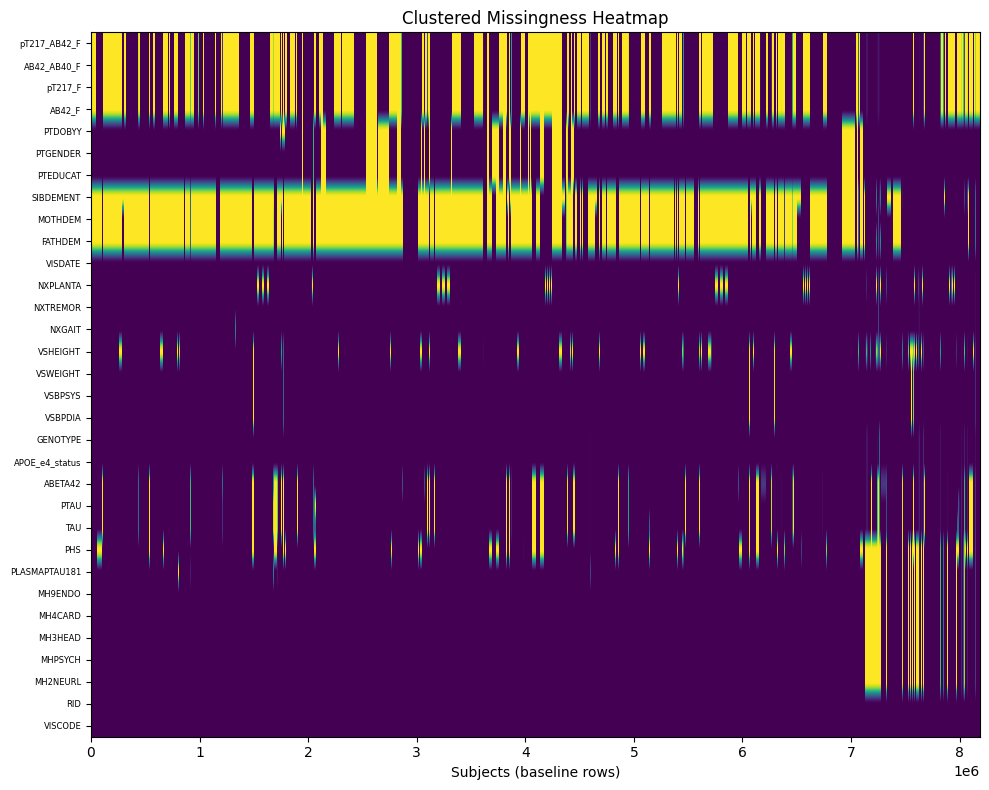

In [6]:
# 1) Extract the cleaned demographics and other datasets
demographics_clean = cleaned_data["demographics"]

# pick exactly the background tables we care about,
# naming them so logs stay informative
datasets = {
    "vitals":                    cleaned_data["vitals"],
    "neuroexam":                 cleaned_data["neuroexam"],
    "plasma_biomarkers":         cleaned_data["plasma_biomarker"],
    "tau":                       cleaned_data["tau"],
    "ptau181":                   cleaned_data["ptau181"],
    "genotype":                  cleaned_data["genotype"],
    "fam_hist_parents":          cleaned_data["family_history_parents"],
    "fam_hist_siblings":         cleaned_data["family_history_siblings"],
    "csf":                       cleaned_data["csf"],
    "genetic":                   cleaned_data["genetic"],
    "medical_history":           cleaned_data["medical_history"],
    "csf_biobank":               cleaned_data["csfbiobank"],
}

# 2) Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# 3) Merge them all onto demographics_clean
background_knowledge = demographics_clean.copy()
for name, df in datasets.items():
    before = background_knowledge.isna().sum().sum()
    background_knowledge = background_knowledge.merge(
        df, on="RID", how="left", suffixes=("", "_dup")
    )
    after = background_knowledge.isna().sum().sum()
    delta = after - before

    # warn if any duplicate‐suffix columns appeared
    dup_cols = [c for c in background_knowledge if c.endswith("_dup")]
    if dup_cols:
        logging.warning(f"‘{name}’ merge left duplicate cols: {dup_cols}")
        background_knowledge.drop(columns=dup_cols, inplace=True)

    logging.info(f"Merged '{name}': missing +{delta}")

# 4) Restrict to baseline and build missingness matrix
baseline = background_knowledge[background_knowledge["VISCODE"] == "bl"]
miss_ind = baseline.isna().astype(int)
miss_corr = miss_ind.corr()

# 5) Rank features by average missingness correlation
avg_miss_corr = (
    (miss_corr.sum() - 1)  # drop self‐corr
    / (miss_corr.shape[0] - 1)
).sort_values(ascending=False)

print("Features by avg. missingness correlation:")
print(avg_miss_corr)

# 6a) Drop zero‐variance features before clustering
# Identify columns whose missing‐indicator is constant
const_cols = [c for c in miss_ind.columns if miss_ind[c].nunique() <= 1]
if const_cols:
    logging.info(f"Dropping {len(const_cols)} constant features (no variability) before clustering: {const_cols}")
# Keep only features with at least two unique values (0 & 1)
to_cluster = miss_ind.drop(columns=const_cols)

# 6b) Perform linkage on the filtered matrix
link = linkage(to_cluster.T, method="average", metric="correlation")
order = leaves_list(link)

# Append the constant cols at the bottom of the heatmap:
final_order = list(to_cluster.columns[order]) + const_cols

# 6c) Plot heatmap using this new order
plt.figure(figsize=(10, 8))
plt.imshow(miss_ind[final_order].T, aspect='auto')
plt.yticks(range(len(final_order)), final_order, fontsize=6)
plt.xlabel("Subjects (baseline rows)")
plt.title("Clustered Missingness Heatmap")
plt.tight_layout()
plt.show()

## <center> Step 6: Ensure Required Background Columns & Initialize Missing Data

In this step, we first list out the key family‐history (MOTHDEM, MOTHAD, etc.) and background categorical features (PTGENDER, APOE_e4_status, etc.) that our analysis expects. We then loop over this combined list and, for any feature not already present in the background_knowledge DataFrame, we add it as a new column filled with NaN. This ensures that all downstream code can safely reference these columns without needing to check for their existence.

In [7]:
# Ensure Required Columns Exist and Fill Missing Values for Background Knowledge
family_columns = ["MOTHDEM", "MOTHAD", "FATHDEM", "FATHAD", "SIBDEMENT", "SIBAD"]
background_categorical_columns = ["PTGENDER", "PTNOTRT", "MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH9ENDO", "APOE_e4_status"]
required_cols = family_columns + background_categorical_columns
for col in required_cols:
    if col not in background_knowledge.columns:
        background_knowledge[col] = np.nan

## <center> Setup: Configure Logging & Initialize Feature Metadata Tracking
Here we configure our logging format to include timestamps and log levels for consistent debug output. We also create a global feature_metadata dictionary that will record each feature’s processing history - whether it’s been dropped or imputed, which PCA component it ended up in, its missingness rates before and after imputation, and its cluster assignments from both hierarchical and DBSCAN methods. The helper function init_metadata(features) takes a list of feature names and populates this dictionary with default values so you can update each entry as your pipeline transforms the data.

In [8]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# feature_metadata will track each feature’s journey
feature_metadata = {}

def init_metadata(features):
    for f in features:
        feature_metadata[f] = {
            'dropped': False,
            'imputed': False,
            'pca_component': None,
            'missing_before': None,
            'missing_after': None,
            'cluster_hier': None,
            'cluster_dbscan': None
        }

## <center> Step 7: Baseline Filtering, Missingness Analysis & Feature Pruning

In this step, we focus on our baseline cohort (VISCODE == "bl") to prepare a clean feature set:

Extract Baseline Rows
We create a separate DataFrame containing only the baseline visits, so all subsequent analyses refer to the same timepoint.

Initialize Metadata Tracking
We call init_metadata(...) on the baseline columns to prepare our feature_metadata structure, which will store each feature’s missing‐data rates and transformation history.

Compute & Record Pre-Drop Missingness
We calculate the fraction of missing values for each feature before any filtering, and log these rates into feature_metadata[f]['missing_before'].

Visualize Missingness Before Pruning
A bar chart shows the proportion of missing entries per feature at baseline, giving you an immediate sense of which variables are sparsely populated.

Identify & Drop Overly Sparse Features
Any feature (except RID and VISCODE) with more than 30% missing values at baseline is flagged and removed. We log which columns are dropped to keep the process transparent.

Deduplicate to Unique Subjects
After dropping features, we convert RID to string, remove any duplicate subject records (keeping the first), and set RID as the DataFrame’s index. This guarantees exactly one row per participant.

Compute & Record Post-Drop Missingness
With the reduced feature set, we recompute missingness rates and store them in feature_metadata[f]['missing_after'].

Visualize Missingness After Pruning
A second bar chart confirms how the dataset’s sparsity has improved, highlighting the distribution of missingness across the retained features.

This pipeline ensures we start downstream modeling with a concise, well-documented set of baseline features that meet our completeness criteria.

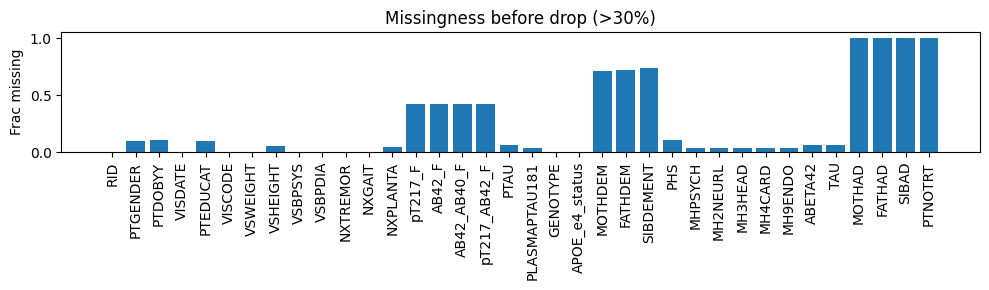

2025-08-24 03:30:13,014 INFO: Dropping 11 features >30% missing at BL: ['pT217_F', 'AB42_F', 'AB42_AB40_F', 'pT217_AB42_F', 'MOTHDEM', 'FATHDEM', 'SIBDEMENT', 'MOTHAD', 'FATHAD', 'SIBAD', 'PTNOTRT']
2025-08-24 03:30:14,903 INFO: Collapsed to unique subjects: 3607 rows


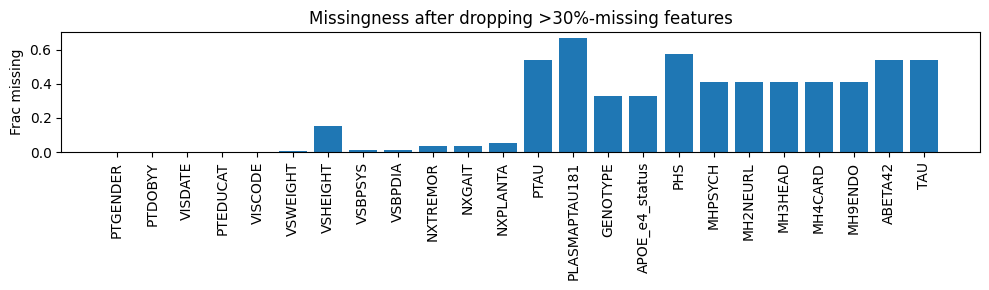

In [9]:
# Filter to baseline
baseline = background_knowledge[background_knowledge["VISCODE"] == "bl"].copy()

# Initialize metadata
init_metadata(baseline.columns)

# Compute & record missing‐rate before
miss_before = baseline.isna().mean()
for f, r in miss_before.items():
    feature_metadata[f]['missing_before'] = float(r)

# Plot missingness before
plt.figure(figsize=(10,3))
plt.bar(baseline.columns, miss_before.values)
plt.xticks(rotation=90); plt.ylabel("Frac missing")
plt.title("Missingness before drop (>30%)"); plt.tight_layout()
plt.show()

# Identify & drop high-missing features
threshold_pct = 30  # percent missing threshold

# compute missing percentage per column at BL
missing_pct = baseline.isna().mean() * 100

# find which columns exceed the threshold (and aren’t RID/VISCODE)
cols_to_drop = [
    c for c, pct in missing_pct.items()
    if pct > threshold_pct and c not in ("RID", "VISCODE")
]

logging.info(
    f"Dropping {len(cols_to_drop)} features >{threshold_pct}% missing at BL: {cols_to_drop}"
)

# use cols_to_drop
baseline_clean = baseline.drop(columns=cols_to_drop)

# Deduplicate so each RID appears exactly once
baseline_clean["RID"] = baseline_clean["RID"].astype(str)
baseline_clean = (
    baseline_clean
      .drop_duplicates(subset=["RID"], keep="first")
      .set_index("RID")
)
logging.info(f"Collapsed to unique subjects: {baseline_clean.shape[0]} rows")

# Compute & record missing-rate after drop
missing_after = baseline_clean.isna().mean()
for f, r in missing_after.items():
    feature_metadata[f]['missing_after'] = float(r)


# Plot missingness after drop
plt.figure(figsize=(10,3))
plt.bar(baseline_clean.columns, missing_after.values)
plt.xticks(rotation=90)
plt.ylabel("Frac missing")
plt.title("Missingness after dropping >30%-missing features")
plt.tight_layout()
plt.show()

## <center> Step 8: Cluster Missingness-Pattern Correlations
In this section, we translate each retained feature into a binary “missingness” indicator (1 for missing, 0 for present), then remove any constant columns (which carry no information for correlation). We compute the Pearson correlation matrix of these indicators to quantify how often features tend to be missing together.

Next, we perform hierarchical clustering on that correlation matrix, using average linkage and correlation distance to order features by similarity of their missing-data patterns. We record each feature’s position in the dendrogram in our feature_metadata dictionary under cluster_hier, and mark dropped constants with a sentinel value.

We then apply DBSCAN on the distance matrix defined as 1 minus the absolute correlation, which groups features into clusters without forcing every one into a hierarchy. Those cluster labels are stored under cluster_dbscan in the metadata (again using –1 for constants or noise).

Finally, we generate a Seaborn clustermap of the missingness correlations, using the same linkage for both rows and columns, to visually inspect how features group together by their patterns of missing values.

2025-08-24 03:30:15,077 INFO: Dropping 3 constant features before clustering: ['PTGENDER', 'VISDATE', 'VISCODE']


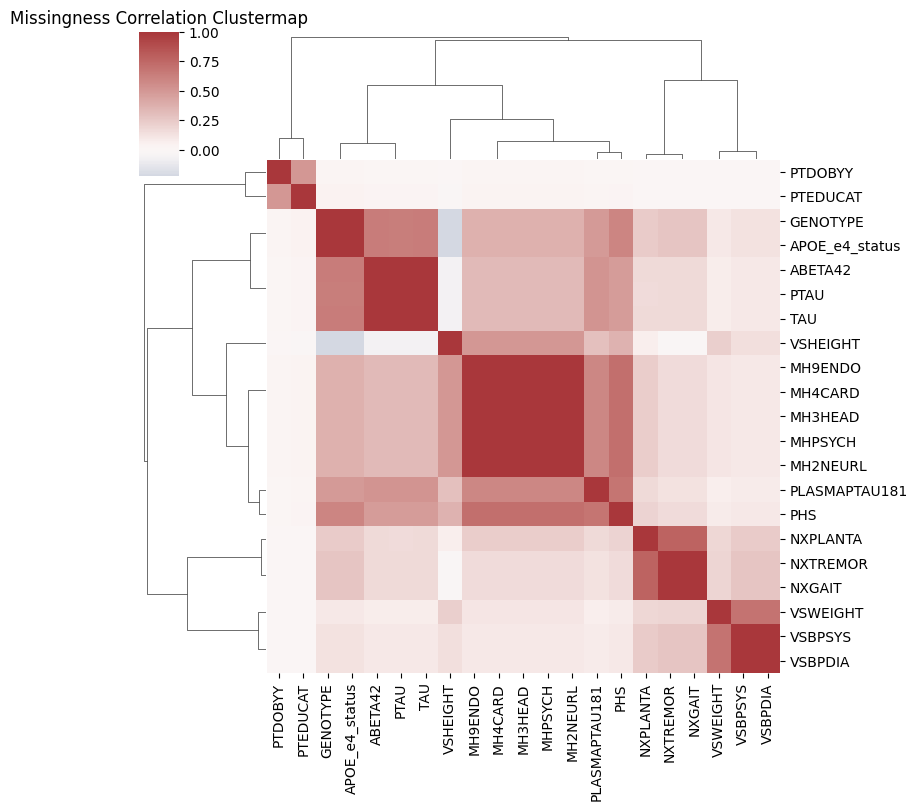

In [10]:
# CLUSTER MISSINGNESS-PATTERN CORRELATIONS

# 1) Build the binary missing-indicator matrix
miss_ind = baseline_clean.isna().astype(int)

# 2) Identify constant columns (no variance - correlation undefined)
const_cols = [c for c in miss_ind.columns if miss_ind[c].nunique() <= 1]
if const_cols:
    logging.info(f"Dropping {len(const_cols)} constant features before clustering: {const_cols}")
# Work on the subset with >1 unique value
miss_ind_clust = miss_ind.drop(columns=const_cols)

# 3) Compute the correlation on the reduced set
miss_corr = miss_ind_clust.corr()

# 4) Hierarchical clustering
link = linkage(miss_corr, method='average', metric='correlation')
order = leaves_list(link)

# Assign hierarchical cluster order
for i, f in enumerate(miss_corr.index[order]):
    feature_metadata[f]['cluster_hier'] = int(i)
# Mark the dropped constants
for f in const_cols:
    feature_metadata[f]['cluster_hier'] = -1

# 5) DBSCAN on distance = 1 – |corr|
dist_mat = 1 - miss_corr.abs()
db = DBSCAN(eps=0.2, min_samples=2, metric='precomputed')
labels = db.fit_predict(dist_mat)

for f, lbl in zip(miss_corr.index, labels):
    feature_metadata[f]['cluster_dbscan'] = int(lbl)
# Constants get their own label
for f in const_cols:
    feature_metadata[f]['cluster_dbscan'] = -1

# 6) Visual check with clustermap (only on the clustered subset)
sns.clustermap(
    miss_corr, 
    row_linkage=link, 
    col_linkage=link,
    figsize=(8,8),
    cmap="vlag", 
    center=0
)
plt.title("Missingness Correlation Clustermap")
plt.show()

## <center> Step 9: Merge Diagnosis, Standardize Features, Add Missingness Indicators & Perform MNAR KNN Imputation
We constructed a preprocessing pipeline for baseline features that ensures proper merging, imputation, and cleaning prior to modeling. First, the subject identifier (RID) is verified as a column so merges can be performed reliably. Diagnosis labels are then incorporated by loading the diagnosis file, dropping missing entries, encoding text labels into integers, and merging the encoded column (DIAGNOSIS_ENC) by RID. Next, features are separated into numeric (excluding the diagnosis encoding) and categorical variables, and all numeric features are standardized with a StandardScaler to zero mean and unit variance to prevent scale bias in distance-based imputers. For missing-not-at-random (MNAR) handling, each feature is augmented with a binary missingness indicator flag, logged when at least one missing value is detected. Imputation is then performed diagnosis-stratified: within each group, numeric features are filled using KNN imputation (with fallback for all-NaN columns) and categorical variables by their mode. Finally, helper columns, including the encoded diagnosis and missingness flags, are dropped, yielding final_static, a fully imputed and cleaned baseline feature set. Logging throughout the workflow reports data shapes, dropped helpers, and confirms completion of MNAR-aware imputation.

In [11]:
# 0) Make sure RID is a column, not the index
df = baseline_clean.copy()
if df.index.name == "RID" or 'RID' not in df.columns:
    df = df.reset_index()

# now df has a “RID” column we can work with:
df['RID'] = df['RID'].astype(str)

# 1) Merge in diagnosis
diag = (
    pd.read_csv(diagnosis_file, usecols=['RID','DIAGNOSIS'], dtype={'RID':str})
      .dropna(subset=['DIAGNOSIS'])
      .drop_duplicates(subset=['RID'])
)
le = LabelEncoder()
diag['DIAGNOSIS_ENC'] = le.fit_transform(diag['DIAGNOSIS'].astype(str))

df = df.merge(
    diag[['RID','DIAGNOSIS_ENC']],
    on='RID',
    how='left'
)
logging.info(f"Merged diagnosis: now df.shape = {df.shape}")

# 2) Identify numeric vs categorical
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns
                if c != 'DIAGNOSIS_ENC']
categorical_cols = [c for c in df.columns
                    if c not in numeric_cols + ['RID','DIAGNOSIS_ENC']]

# 3) Standardize numeric BEFORE imputation
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
logging.info("Numeric features standardized.")

# 4) Add MNAR indicators
for col in numeric_cols + categorical_cols:
    miss_col = f"{col}_miss"
    df[miss_col] = df[col].isna().astype(int)
    if df[miss_col].sum() > 0:
        logging.info(f"Added missingness indicator '{miss_col}' (n_missing={df[miss_col].sum()})")

extended_num = numeric_cols + [f"{c}_miss" for c in numeric_cols]
extended_cat = categorical_cols + [f"{c}_miss" for c in categorical_cols]

# 5) Diagnosis‐specific MNAR KNN‐imputation
def impute_mnar(df, num_feats, cat_feats, diag_col='DIAGNOSIS_ENC', k=10):
    out = df.copy()
    for val in out[diag_col].dropna().unique():
        ids   = out[out[diag_col]==val].index
        block = out.loc[ids, num_feats].copy()
        # avoid all‐NaNs
        for c in block.columns:
            if block[c].isna().all():
                block[c] = 0
        imp = KNNImputer(n_neighbors=k)
        filled = pd.DataFrame(imp.fit_transform(block), index=ids, columns=block.columns)
        out.loc[ids, num_feats] = filled
        # mode‐impute categoricals
        for c in cat_feats:
            m = out.loc[ids, c].mode()
            if not m.empty:
                out.loc[ids, c] = out.loc[ids, c].fillna(m.iloc[0])
    return out

df_imputed = impute_mnar(df, extended_num, extended_cat, k=10)

# 6) Drop helpers - final_static
final_static = (
    df_imputed
      .drop(columns=['DIAGNOSIS_ENC'] 
            + [f"{c}_miss" for c in numeric_cols + categorical_cols],
            errors='ignore')
      .reset_index(drop=True)
)

logging.info("Baseline‐static MNAR imputation complete. final_static.shape = %s", final_static.shape)

2025-08-24 03:30:15,529 INFO: Merged diagnosis: now df.shape = (3607, 26)
2025-08-24 03:30:15,537 INFO: Numeric features standardized.
2025-08-24 03:30:15,540 INFO: Added missingness indicator 'PTDOBYY_miss' (n_missing=1)
2025-08-24 03:30:15,540 INFO: Added missingness indicator 'PTEDUCAT_miss' (n_missing=4)
2025-08-24 03:30:15,543 INFO: Added missingness indicator 'VSWEIGHT_miss' (n_missing=32)
2025-08-24 03:30:15,544 INFO: Added missingness indicator 'VSHEIGHT_miss' (n_missing=548)
2025-08-24 03:30:15,544 INFO: Added missingness indicator 'VSBPSYS_miss' (n_missing=48)
2025-08-24 03:30:15,545 INFO: Added missingness indicator 'VSBPDIA_miss' (n_missing=48)
2025-08-24 03:30:15,545 INFO: Added missingness indicator 'NXTREMOR_miss' (n_missing=121)
2025-08-24 03:30:15,548 INFO: Added missingness indicator 'NXGAIT_miss' (n_missing=122)
2025-08-24 03:30:15,548 INFO: Added missingness indicator 'NXPLANTA_miss' (n_missing=197)
2025-08-24 03:30:15,548 INFO: Added missingness indicator 'PTAU_mis

## <center> Step 10: Export Feature Preprocessing Metadata

In this final step, we consolidate all of the per-feature tracking information kept in the feature_metadata dictionary into a single pandas DataFrame (meta_df), with one row per feature. We then write this table out to both CSV and JSON formats (feature_preprocessing_metadata.csv and feature_preprocessing_metadata.json), providing a complete record of which features were dropped or imputed, their missingness rates before and after pruning, and any cluster assignments. A final log message confirms that the static preprocessing phase is fully complete and that your metadata files have been written to disk.

In [12]:
# EXPORT METADATA LOG
meta_df = pd.DataFrame.from_dict(feature_metadata, orient='index')
meta_df.index.name = 'feature'
meta_df.to_csv("feature_preprocessing_metadata.csv")
with open("feature_preprocessing_metadata.json", "w") as f:
    json.dump(feature_metadata, f, indent=2)

logging.info("Static preprocessing complete. Metadata written to CSV/JSON.")

2025-08-24 03:30:15,965 INFO: Static preprocessing complete. Metadata written to CSV/JSON.


## <center> Step 11: Process Longitudinal Modalities: VISCODE Mapping, Imputation, PCA & Embeddings
We implemented a unified pipeline for preprocessing longitudinal clinical modalities (e.g., MRI, PET) that standardizes visit codes, imputes missing data, and generates both linear and nonlinear embeddings. Visit codes (e.g., bl, m06, y1) are mapped to numeric month values via a dictionary, with PET-specific codes normalized beforehand, enabling chronological sorting and conditional forward-filling, which carries values forward only when diagnosis remains unchanged. Residual gaps are imputed using diagnosis-specific group statistics, applying means for numeric and modes for categorical features. After merging input DataFrames with diagnosis labels and separating numeric from categorical variables, numeric features are standardized, reduced with PCA retaining 91% of variance, and labeled with prefixed component names. In parallel, 2D UMAP and openTSNE embeddings are computed for visualization, with all outputs, including per-visit PCA tables, embeddings, explained variance, and PCA loadings, exported to CSV. The trained scaler and PCA objects are also serialized, ensuring reproducibility. Applied separately to MRI and PET, this workflow produces consistent, modality-specific representations that streamline downstream modeling and visualization.

In [13]:
# Mapping for VISCODE ordering.
order_mapping = {
    "bl": 0, "m06": 6, "m12": 12, "m18": 18, "m24": 24, "m30": 30,
    "m36": 36, "m42": 42, "m48": 48, "m54": 54, "m60": 60, "m66": 66,
    "m72": 72, "m78": 78, "m84": 84
}

def add_numeric_viscode(df):
    """
    Add a numeric representation of visit codes for sorting and computation.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame must contain a 'VISCODE' column with string visit codes
        (e.g., 'bl', 'm06', 'y1', etc.).

    Returns
    -------
    pandas.DataFrame
        A copy of the input DataFrame with:
        - 'VISCODE' normalized to lowercase and stripped of whitespace.
        - A new 'VISCODE_numeric' column mapping each code to its month integer
          equivalent (using the global `order_mapping` dict).
    """
    df = df.copy()
    df["VISCODE"] = df["VISCODE"].str.lower().str.strip()
    df["VISCODE_numeric"] = df["VISCODE"].map(order_mapping)
    return df

def conditional_forward_fill_modality(df, diagnosis_col):
    """
    Forward-fill missing values within each subject and diagnosis group.

    For each subject (grouped by 'RID'), sort by ascending 'VISCODE_numeric'.
    Then, for each pair of consecutive visits, if the diagnosis is unchanged,
    fill any missing entries in the later visit with values from the earlier one.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame must contain columns 'RID', 'VISCODE_numeric',
        and the specified diagnosis column.
    diagnosis_col : str
        Name of the column indicating diagnosis. Forward-fill only occurs
        when diagnosis for the current visit matches the previous visit.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame where missing values have been conditionally
        forward-filled within each subject’s time series.
    """
    def fill_group(g):
        g = g.sort_values("VISCODE_numeric")
        out = g.copy()
        for i in range(1, len(out)):
            if out.iloc[i][diagnosis_col] == out.iloc[i-1][diagnosis_col]:
                out.iloc[i] = out.iloc[i].fillna(out.iloc[i-1])
        return out
    return df.groupby("RID", group_keys=False).apply(fill_group).reset_index(drop=True)

def group_mean_impute(df, diagnosis_col, feature_cols):
    """
    Impute missing feature values using the group mean per diagnosis.

    For each feature in `feature_cols`, replace missing entries by the mean
    of that feature computed over subjects sharing the same diagnosis.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame which must contain the `diagnosis_col` and the
        specified feature columns.
    diagnosis_col : str
        Column name indicating group membership (e.g., diagnosis label).
    feature_cols : list of str
        List of feature column names to be mean-imputed.

    Returns
    -------
    pandas.DataFrame
        A copy of the DataFrame with missing values in `feature_cols` filled
        by their group-specific means.
    """
    df = df.copy()
    for feat in feature_cols:
        df[feat] = df.groupby(diagnosis_col)[feat] \
                     .transform(lambda x: x.fillna(x.mean()))
    return df

def translate_pet_viscode(vis):
    """
    Normalize PET-specific visit codes to the standard monthly format.

    Parameters
    ----------
    vis : str or any
        The original visit code, which may be in various legacy formats
        (e.g., 'init', 'sc', 'y1', 'v03', etc.).

    Returns
    -------
    str
        The mapped visit code:
        - 'init' and 'sc' - 'bl'
        - 'yN' - 'm{N*12}' (e.g., 'y1' - 'm12', 'y2' - 'm24', etc.)
        - legacy 'vXX' codes translated to their corresponding monthly values
          (per the defined mapping)
        - any unrecognized code is returned unchanged
    """
    vis = str(vis).lower().strip()
    mapping = {
        "init": "bl", "sc": "bl", "y1": "m12", "y2": "m24", "y3": "m36",
        "y4": "m48", "y5": "m60", "v03": "m12", "v06": "m24",
        "v21": "m24", "v41": "m48"
    }
    return mapping.get(vis, vis)

def process_modalities_clinical(
    datasets,
    diagnosis_info,
    name,
    pca_prefix=None,
    categorical_features=None,
    umap_neighbors=10,
    umap_min_dist=0.2,
    tsne_perplexity=30,
    tsne_n_jobs=4
):
    """
    1) Merge datasets + add numeric VISCODE
    2) Forward-fill + group-mean/mode impute
    3) Scale - PCA (91% var) - UMAP - openTSNE
    4) Persist artifacts & return DataFrames
    """
    print(f"\nProcessing {name}…")

    # Merge + diagnosis + VISCODE
    df = pd.concat(datasets, ignore_index=True)
    df["RID"] = df["RID"].astype(str)
    df = df.merge(diagnosis_info[["RID","DIAGNOSIS"]], on="RID", how="left")
    df = add_numeric_viscode(df)

    # Identify numeric features
    num_feats = [c for c in df.select_dtypes(include=[np.number]).columns
                 if c not in ("RID","DIAGNOSIS")]
    if categorical_features:
        num_feats = [c for c in num_feats if c not in categorical_features]

    feats = num_feats + (categorical_features or [])
    proc = df[["RID","VISCODE","DIAGNOSIS"] + feats].copy()

    # Imputation
    proc = conditional_forward_fill_modality(proc, "DIAGNOSIS")
    proc = group_mean_impute(proc, "DIAGNOSIS", num_feats)
    if categorical_features:
        for diag in proc["DIAGNOSIS"].unique():
            mask = proc["DIAGNOSIS"] == diag
            for col in categorical_features:
                m = proc.loc[mask, col].mode()
                if not m.empty:
                    proc.loc[mask, col] = proc.loc[mask, col].fillna(m.iloc[0])

    # Drop helpers
    proc.drop(columns=["VISCODE_numeric","DIAGNOSIS"], inplace=True)

    # Numeric matrix
    num_df = proc.drop(columns=["RID","VISCODE"] + (categorical_features or []))
    num_df.fillna(num_df.mean(), inplace=True)
    const_cols = num_df.columns[num_df.nunique() <= 1]
    if len(const_cols):
        print(f"Dropping constant cols in {name}: {list(const_cols)}")
        num_df.drop(columns=const_cols, inplace=True)
    original_feats = num_df.columns.tolist()

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(num_df)

    # PCA
    pca = PCA(n_components=0.91, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    comps = [f"{pca_prefix or name + '_PCA_'}{i+1}" for i in range(X_pca.shape[1])]
    pca_df = pd.DataFrame(X_pca, index=num_df.index, columns=comps)
    print(f"{name} PCA → shape {pca_df.shape}")

    # re-attach RID + VISCODE
    vis_info = df.loc[num_df.index, ["RID","VISCODE"]].reset_index(drop=True)
    pca_visits_df = pd.concat([vis_info,
                           pca_df.reset_index(drop=True)], axis=1)

    # UMAP
    umapper = UMAP(n_components=2,
                   n_neighbors=umap_neighbors,
                   min_dist=umap_min_dist,
                   random_state=42)
    umap_emb = umapper.fit_transform(X_pca)
    umap_df = pd.DataFrame(umap_emb, index=num_df.index,
                           columns=["UMAP1","UMAP2"])
    umap_df["diagnosis"] = df.loc[num_df.index, "DIAGNOSIS"].values
    umap_df.to_csv(f"{name.lower()}_UMAP_embedding.csv", index=False)

    # openTSNE
    tsne = oTSNE(n_components=2,
                 perplexity=tsne_perplexity,
                 n_jobs=tsne_n_jobs,
                 random_state=42)
    tsne_emb = tsne.fit(X_pca)
    tsne_df = pd.DataFrame(tsne_emb, index=num_df.index,
                           columns=["TSNE1","TSNE2"])
    tsne_df["diagnosis"] = df.loc[num_df.index, "DIAGNOSIS"].values
    tsne_df.to_csv(f"{name.lower()}_TSNE_embedding.csv", index=False)

    # Persist artifacts
    joblib.dump(scaler, f"{name.lower()}_scaler.joblib")
    joblib.dump(pca,    f"{name.lower()}_pca.joblib")

        # Save loadings and explained variance
    loadings_df = pd.DataFrame(
        pca.components_.T,
        index=num_df.columns,
        columns=comps
    )
    loadings_df.to_csv(f"{name.lower()}_pca_loadings.csv")

    var_ratio = pd.Series(
        pca.explained_variance_ratio_,
        index=comps,
        name="explained_variance_ratio"
    )
    cum_var = var_ratio.cumsum().rename("cumulative_variance")
    pd.concat([var_ratio, cum_var], axis=1).to_csv(f"{name.lower()}_pca_variance.csv")

    return pca_visits_df, pca, scaler, original_feats, umap_df, tsne_df


# Load & clean diagnosis
subject_diagnosis = (
    pd.read_csv(diagnosis_file, usecols=["RID","DIAGNOSIS"], dtype={"RID":str})
      .dropna(subset=["DIAGNOSIS"])
      .drop_duplicates(subset=["RID"], keep="first")
)
gen_diagnosis_df = subject_diagnosis[["RID","DIAGNOSIS"]].copy()

# Translate PET visit codes
for pet_df in (PETamy_data, av45PET_data,
               pet_amyloid_detailed_data):
    pet_df["VISCODE"] = pet_df["VISCODE"].apply(translate_pet_viscode)

# Run MRI pipeline
mri_pca_df, pca_mri, scaler_mri, mri_feats, mri_umap, mri_tsne = \
    process_modalities_clinical(
        datasets=[ucsfFreesurferMRI_data, FoxLabMRI_data, MRIcomprehensive_data],
        diagnosis_info=gen_diagnosis_df,
        name="MRI",
        pca_prefix="MRI_PCA_",
        categorical_features=[
            "BASETP1","BASETP2","BASETP3","BASETP4",
            "BASETP5","BASETP6","BASETP7","BASETP8"
        ],
        umap_neighbors=10,
        umap_min_dist=0.2,
        tsne_perplexity=30,
        tsne_n_jobs=4
    )

# Run PET pipeline
pet_pca_df, pca_pet, scaler_pet, pet_feats, pet_umap, pet_tsne = \
    process_modalities_clinical(
        datasets=[PETamy_data, av45PET_data,
                  pet_amyloid_detailed_data],
        diagnosis_info=gen_diagnosis_df,
        name="PET",
        pca_prefix="PET_PCA_",
        umap_neighbors=10,
        umap_min_dist=0.2,
        tsne_perplexity=30,
        tsne_n_jobs=4
    )

print("MRI PCA shape:", mri_pca_df.shape)
print("PET PCA shape:", pet_pca_df.shape)


Processing MRI…


C:\Users\Asus\AppData\Local\Temp\ipykernel_14292\60547554.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("RID", group_keys=False).apply(fill_group).reset_index(drop=True)


Dropping constant cols in MRI: ['ST100SV', 'ST122SV', 'ST126SV', 'ST22CV', 'ST22SA', 'ST22TA', 'ST22TS', 'ST28CV', 'ST33SV', 'ST41SV', 'ST63SV', 'ST67SV', 'ST81CV', 'ST81SA', 'ST81TA', 'ST81TS', 'ST87CV', 'ST92SV']
MRI PCA → shape (24132, 111)


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2025-08-24 03:42:05,846 INFO: Precomputed initialization provided. Ignoring initalization-related parameters.
2025-08-24 03:42:05,870 INFO: Automatically d


Processing PET…


C:\Users\Asus\AppData\Local\Temp\ipykernel_14292\60547554.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("RID", group_keys=False).apply(fill_group).reset_index(drop=True)


Dropping constant cols in PET: ['GAAIN_WHOLECEREBELLUM_SUVR', 'NPDKA_WHOLECEREBELLUM_SUVR']
PET PCA → shape (10754, 20)


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2025-08-24 03:45:31,835 INFO: Precomputed initialization provided. Ignoring initalization-related parameters.
2025-08-24 03:45:31,841 INFO: Automatically determined negative gradient method `fft`
2025-08-24 03:45:36,186 INFO: Automatically determined negative gradient method `fft`


MRI PCA shape: (24132, 113)
PET PCA shape: (10754, 22)


## <center> Utility: Standardize IDs & VISCODE Across All Tables
We first standardize identifiers and visit codes to ensure consistency across all modalities before merging or analysis. The standardize_ids function converts the RID column to string and removes extra whitespace, preventing hidden formatting mismatches. The standardize_viscode function normalizes visit codes by lowercasing and trimming spaces, aligning them with the expected set (e.g., bl, m06). A helper mapping viscode_to_order translates visit codes to numeric month values for sorting and plotting. All modality and assessment DataFrames are collected into a list, passed through these standardization functions, and then unpacked back into their original variables (including PCA-processed MRI and PET). This step ensures that every dataset entering downstream analyses uses consistent subject identifiers and visit-code conventions.

In [14]:
# Utility: Standardize ID and VISCODE Formats
def standardize_ids(df, id_col="RID"):
    """Normalize subject IDs: convert to string and strip whitespace."""
    df[id_col] = df[id_col].astype(str).str.strip()
    return df

def standardize_viscode(df, vis_col="VISCODE"):
    """Normalize VISCODE: lowercase and strip whitespace."""
    df[vis_col] = df[vis_col].astype(str).str.lower().str.strip()
    return df

def viscode_to_order(vis):
    """Map VISCODE to its numeric month equivalent; unknown codes become NaN."""
    mapping = {
        "bl": 0, "m06": 6, "m12": 12, "m18": 18, "m24": 24, "m30": 30,
        "m36": 36, "m42": 42, "m48": 48, "m54": 54, "m60": 60, "m66": 66,
        "m72": 72, "m78": 78, "m84": 84
    }
    return mapping.get(vis, np.nan)

datasets = [adas1_data, adasGO23_data, moca_data, adspCognitive_data, embicCognitive_data,
            embicDigital_data, faq_data, mmse_data, neurobattery_data, neuroexam_data,
            npiq_data, GutMetabolites_data, mri_pca_df, pet_pca_df,
            GeriatricDepressionScale_data, lipidomics_data, lipoproteins_data, ravlt_data]

for i, df in enumerate(datasets):
    df = standardize_ids(df, "RID")
    if "VISCODE" in df.columns:
        df = standardize_viscode(df, "VISCODE")
    datasets[i] = df

(adas1_data, adasGO23_data, moca_data, adspCognitive_data, embicCognitive_data,
 embicDigital_data, faq_data, mmse_data, neurobattery_data, neuroexam_data,
 npiq_data, GutMetabolites_data, mri_pca_visits_df, pet_pca_visits_df,
 lipidomics_data, lipoproteins_data, GeriatricDepressionScale_data, ravlt_data) = datasets

## <center> Step 12: Aggregate ADAS Time-Series Targets

In this step, we compute and harmonize ADAS-Cog summary scores across visits by first converting all subtest responses to numeric values, replacing non-numeric or missing entries with zero, and then summing the core 11 items to obtain ADAS_11 and adding the two additional items to form ADAS_13. The same procedure is applied to ADAS versions from ADNI-GO/ADNI-2/3, using Q1–Q11 for the 11-item score and Q12–Q13 for the extended score. The resulting datasets are concatenated while retaining only RID, VISCODE, ADAS_11, and ADAS_13, after which VISCODE entries are normalized (lowercased and trimmed) to enforce consistency. Finally, unique VISCODE values are inspected in the combined table to verify correct timepoint mapping.

In [15]:
adas1_numeric_cols = [
    'COT1SCOR', 'COT2SCOR', 'COT3SCOR', 'CONAME', 'COCOMND',
    'COCONSTR', 'COIDEA', 'COORIEN', 'COWRDFND', 'COINSTRC', 'COLANG', 'COCOMPRE'
]
for col in adas1_numeric_cols:
    adas1_data[col] = pd.to_numeric(adas1_data[col], errors='coerce').fillna(0)
adas1_data['ADAS_11'] = adas1_data[adas1_numeric_cols].sum(axis=1)
adas1_extra_cols = ['COT4TOTL', 'COP14CMP']
for col in adas1_extra_cols:
    adas1_data[col] = pd.to_numeric(adas1_data[col], errors='coerce').fillna(0)
adas1_data['ADAS_13'] = adas1_data['ADAS_11'] + adas1_data[adas1_extra_cols].sum(axis=1)

adasGO23_numeric_cols = [
    'Q1SCORE', 'Q2SCORE', 'Q3SCORE', 'Q4SCORE', 'Q5SCORE_CUE',
    'Q6SCORE', 'Q7SCORE', 'Q8SCORE', 'Q9SCORE', 'Q10SCORE', 'Q11SCORE'
]
for col in adasGO23_numeric_cols:
    adasGO23_data[col] = pd.to_numeric(adasGO23_data[col], errors='coerce').fillna(0)
adasGO23_data['ADAS_11'] = adasGO23_data[adasGO23_numeric_cols].sum(axis=1)
adasGO23_extra_cols = ['Q12SCORE', 'Q13SCORE']
for col in adasGO23_extra_cols:
    adasGO23_data[col] = pd.to_numeric(adasGO23_data[col], errors='coerce').fillna(0)
adasGO23_data['ADAS_13'] = adasGO23_data['ADAS_11'] + adasGO23_data[adasGO23_extra_cols].sum(axis=1)

adas_combined = pd.concat([
    adas1_data[['RID', 'VISCODE', 'ADAS_11', 'ADAS_13']],
    adasGO23_data[['RID', 'VISCODE', 'ADAS_11', 'ADAS_13']]
], ignore_index=True)
adas_combined = standardize_viscode(adas_combined, "VISCODE")
print("Unique VISCODE in ADAS data (progression):", adas_combined["VISCODE"].unique())

Unique VISCODE in ADAS data (progression): ['bl' 'm06' 'm24' 'm12' 'm48' 'm18' 'uns1' 'm36' 'm60' 'm72' 'v05' 'v31'
 'v51' 'tau']


## <center> Step 13: Merge Longitudinal Assessments into a Unified Table
We build a comprehensive longitudinal dataset by starting from the CDR table as our backbone. First, we make sure every participant ID (RID) is a clean string and strip any extra whitespace. We then print out the initial shape and unique visit codes in the CDR data so we can track how each merge affects our table.

Next, we define a list of additional time-series tables to bring in everything from FAQ, MMSE, neuropsych batteries, and ADAS scores to PCA embeddings for PET/MRI, metabolomics, and other cognitive or clinical measures. For each dataset, we:

Standardize RID and VISCODE formats (lowercase, trimmed).

Drop any duplicates on the merge keys (RID, VISCODE) to prevent accidental row inflation.

Log the shape and visit codes after deduplication.

Perform an outer join on RID and VISCODE to merge into our growing merged_data table.

Print the updated shape and unique visit codes again for sanity checks.

Finally, once all datasets are merged, we filter the combined table to include only those participants who have at least one baseline record (VISCODE == "bl"). This ensures that every subject in our final longitudinal dataset has a starting point at baseline.

In [16]:
# Merge Time-Series Datasets
cdr_data["VISCODE"] = cdr_data["VISCODE"]
merged_data = cdr_data.copy()
merged_data["RID"] = merged_data["RID"].astype(str).str.strip()
print("=== BEFORE MERGES ===")
print("merged_data shape:", merged_data.shape)
print("merged_data VISCODE unique:", merged_data["VISCODE"].unique())

datasets_to_merge = [
    ("faq_data", faq_data, ["RID", "VISCODE"]),
    ("mmse_data", mmse_data, ["RID", "VISCODE"]),
    ("neurobattery_data", neurobattery_data, ["RID", "VISCODE"]),
    ("neuroexam_data", neuroexam_data, ["RID", "VISCODE"]),
    ("npiq_data", npiq_data, ["RID", "VISCODE"]),
    ("adas_data", adas_combined, ["RID", "VISCODE"]),
    ("moca_data", moca_data, ["RID", "VISCODE"]),
    ("pet_pca", pet_pca_visits_df, ["RID", "VISCODE"]),
    ("mri_pca", mri_pca_visits_df, ["RID", "VISCODE"]),
    ("adspCognitive_data", adspCognitive_data, ["RID", "VISCODE"]),
    ("embicCognitive_data", embicCognitive_data, ["RID", "VISCODE"]),
    ("embicDigital_data", embicDigital_data, ["RID", "VISCODE"]),
    ("GutMetabolites_data", GutMetabolites_data, ["RID", "VISCODE"]),
    ("lipidomics_data", lipidomics_data, ["RID", "VISCODE"]),
    ("lipoproteins_data", lipoproteins_data, ["RID", "VISCODE"]),
    ("GeriatricDepressionScale_data", GeriatricDepressionScale_data, ["RID", "VISCODE"]),
    ("ravlt_data", ravlt_data, ["RID", "VISCODE"])
]

for name, df, keys in datasets_to_merge:
    df["RID"] = df["RID"].astype(str).str.strip()
    if "VISCODE" in df.columns:
        df["VISCODE"] = df["VISCODE"].astype(str).str.lower().str.strip()
    df = df.drop_duplicates(subset=keys)
    print(f"--- Merging: {name} ---")
    print(f"{name} shape (after deduplication):", df.shape)
    print(f"{name} VISCODE unique:", df["VISCODE"].unique())
    merged_data = merged_data.merge(df, on=keys, how="outer")
    print(f"After merging with {name}, merged_data shape:", merged_data.shape)
    print("merged_data VISCODE unique:", merged_data["VISCODE"].unique())

rids_with_baseline = merged_data.loc[merged_data["VISCODE"] == "bl", "RID"].unique()
merged_data = merged_data[merged_data["RID"].isin(rids_with_baseline)]
print("After baseline filter (participants), shape =", merged_data.shape)

=== BEFORE MERGES ===
merged_data shape: (13866, 3)
merged_data VISCODE unique: ['bl' 'f' 'm06' 'm12' 'm36' 'm18' 'uns1' 'm24' 'm48' 'm60' 'm72' 'v05'
 'v31' 'v51' '4_m12']
--- Merging: faq_data ---
faq_data shape (after deduplication): (10967, 3)
faq_data VISCODE unique: ['bl' 'm06' 'm12' 'm18' 'uns1' 'm24' 'm36' 'm48' 'm60' 'm72' 'v05' 'v31'
 'v51' 'tau' '4_m12']
After merging with faq_data, merged_data shape: (14694, 4)
merged_data VISCODE unique: ['bl' 'm06' 'm12' 'm24' 'f' '4_m12' 'm36' 'm18' 'm60' 'm48' 'v31' 'v51'
 'm72' 'uns1' 'v05' 'tau']
--- Merging: mmse_data ---
mmse_data shape (after deduplication): (12103, 3)
mmse_data VISCODE unique: ['bl' 'f' 'm06' 'm12' 'm18' 'm36' 'm24' 'm48' 'm60' 'm72' 'v05' 'v31'
 'v51' 'tau' '4_m12']
After merging with mmse_data, merged_data shape: (15065, 5)
merged_data VISCODE unique: ['f' 'bl' 'm06' 'm12' 'm24' '4_m12' 'm36' 'm18' 'm60' 'm48' 'v31' 'v51'
 'm72' 'uns1' 'v05' 'tau']
--- Merging: neurobattery_data ---
neurobattery_data shape (afte

## <center> Step 14: Filter Subjects by Clinical Trajectory and Minimum Visits
In this step, we narrow our cohort to participants whose clinical progression follows a valid, non‐regressive trajectory and who have at least a minimum number of visits. We define filter_subjects_by_trajectory, which first ensures every RID and diagnosis label are present, merging in diagnosis info if needed. For each subject, we restrict to visits in our expected time‐order map (baseline, 6 m, 12 m, …), sort them chronologically, and extract their diagnosis sequence. We then apply three filters: the subject must have at least the specified number of visits; their diagnosis labels must never “go backwards” (e.g., from dementia back to mild cognitive impairment); and they must not represent the uninformative pattern of jumping directly from normal (0) to dementia (2) without any intermediate visit in category 1. Any subject passing all tests is retained. Finally, we overwrite merged_data with only those valid subjects and report the new table shape.

In [17]:
# Subject Selection Based on Clinical Trajectory and Minimum Number of Visits
def filter_subjects_by_trajectory(df, min_visits=2, diagnosis_col="DIAGNOSIS"):
    """
    Retain subjects whose diagnosis progresses monotonically over time
    and who have at least a minimum number of visits.

    Parameters
    ----------
    df : pandas.DataFrame
        Longitudinal dataset containing 'RID', 'VISCODE', and diagnosis columns.
    min_visits : int, default=2
        Minimum number of visits a subject must have to be included.
    diagnosis_col : str, default="DIAGNOSIS"
        Name of the column indicating diagnosis level (e.g., 0, 1, 2).

    Returns
    -------
    pandas.DataFrame
        Subset of `df` with only those `RID`s that:
        - Have at least `min_visits` visits.
        - Never exhibit a backward change in diagnosis.
        - Do not jump directly from normal (0) to dementia (2) without intermediate visits.
    """
    df['RID'] = df['RID'].astype(str)
    subject_diag = subject_diagnosis.copy()
    subject_diag['RID'] = subject_diag['RID'].astype(str)
    if diagnosis_col not in df.columns:
        print(f"Diagnosis column '{diagnosis_col}' not found in df; attempting to merge from subject_diagnosis.")
        df = df.merge(subject_diag[['RID', diagnosis_col]], on='RID', how='left')
    diagnosis_cols = [col for col in df.columns if "DIAGNOSIS" in col]
    if len(diagnosis_cols) > 1:
        diagnosis_col = diagnosis_cols[0]
        print("Multiple diagnosis columns found. Using:", diagnosis_col)
    expected_order = {"bl": 0, "m06": 1, "m12": 2, "m18": 3, "m24": 4, "m30": 5,
                      "m36": 6, "m42": 7, "m48": 8, "m54": 9, "m60": 10, "m66": 11,
                      "m72": 12, "m78": 13, "m84": 14}
    valid_rids = []
    for rid, group in df.groupby("RID"):
        group = group[group["VISCODE"].isin(expected_order.keys())].dropna(subset=[diagnosis_col])
        if group.empty:
            continue
        group = group.copy()
        group["visit_order"] = group["VISCODE"].map(expected_order)
        group.sort_values("visit_order", inplace=True)
        trajectory = group[diagnosis_col].tolist()
        if len(trajectory) < min_visits:
            continue
        if any(prev > curr for prev, curr in zip(trajectory, trajectory[1:])):
            continue
        if trajectory[0] == 0 and trajectory[-1] == 2 and (1 not in trajectory):
            continue
        valid_rids.append(rid)
    filtered_df = df[df["RID"].isin(valid_rids)].copy()
    return filtered_df

merged_data = filter_subjects_by_trajectory(merged_data, min_visits=2, diagnosis_col="DIAGNOSIS")
print("After clinical trajectory filtering, merged_data shape =", merged_data.shape)

Diagnosis column 'DIAGNOSIS' not found in df; attempting to merge from subject_diagnosis.
After clinical trajectory filtering, merged_data shape = (24459, 323)


## <center> Step 15: Drop High-Missing Features & Impute Time-Series Data
We standardize common missing‐value placeholders to np.nan, exclude all MRI/PET PCA features, then apply a diagnosis‐conditional forward‐fill (using DIAGNOSIS_ENC when present or a simple group forward‐fill otherwise) before computing detailed missingness diagnostics, a heatmap of missing vs. present values, a bar chart of percent missing per feature, and a dendrogram of feature missingness correlations, while initializing a metadata log with the initial shape, standardized indicators, excluded features, and missing percentages; next we calculate and record pre‐drop missingness, plot it, and drop any non‐target feature exceeding 30 % missing; we then add an inter‐visit interval column based on actual dates, split features into numeric and categorical sets, perform diagnosis‐group mean imputation for numeric features and mode imputation for categoricals, remove the DIAGNOSIS_ENC helper, standard‐scale all remaining numeric columns (except RID), and finally export the complete preprocessing log as JSON.

Standardized common missing value indicators to np.nan.
Completed diagnosis-conditional forward-fill.


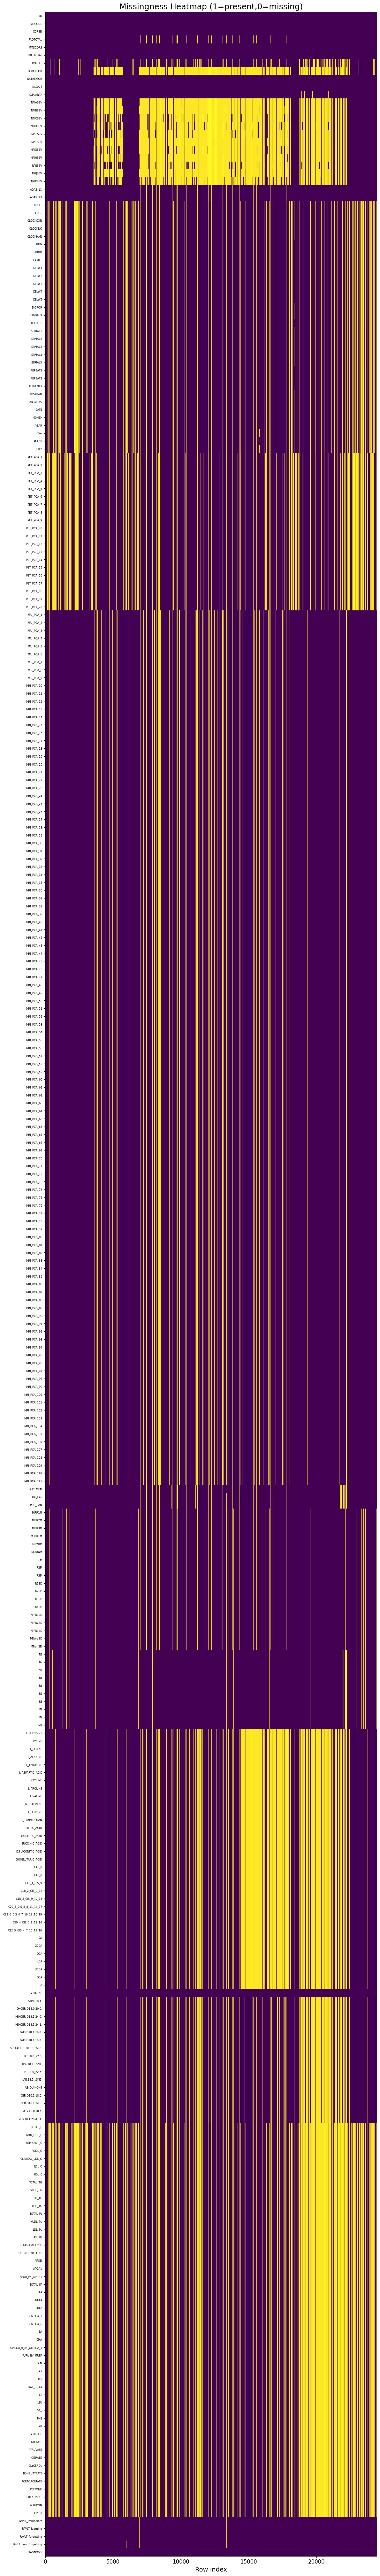

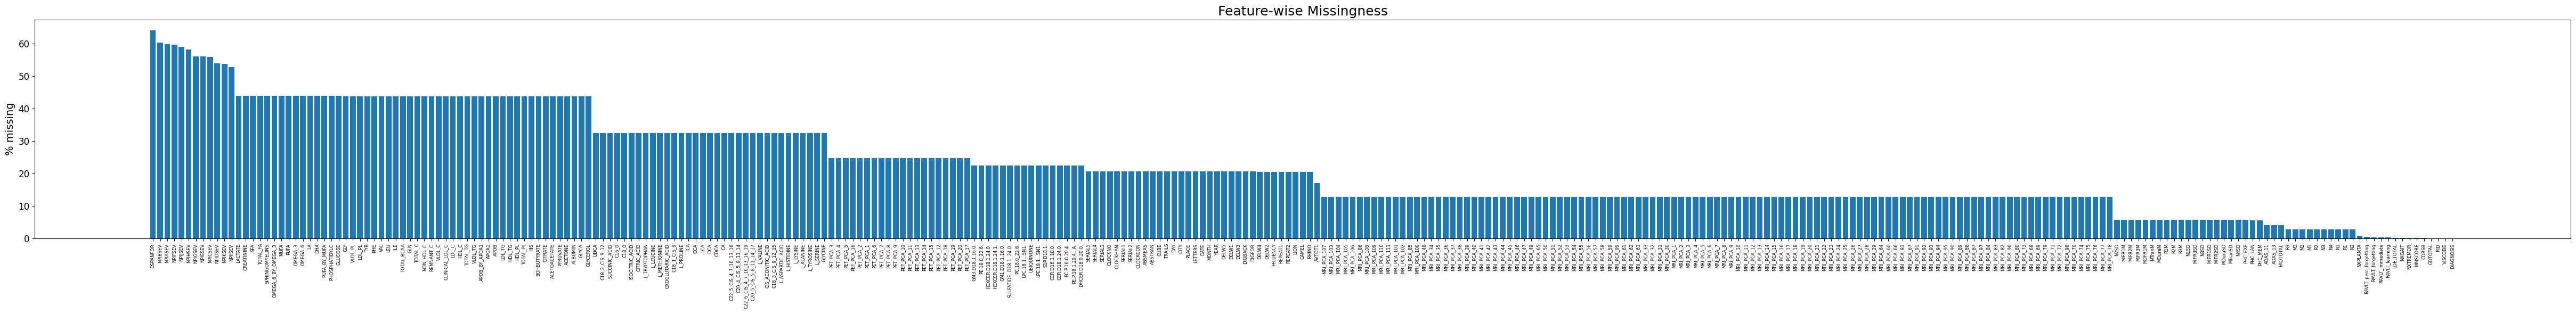

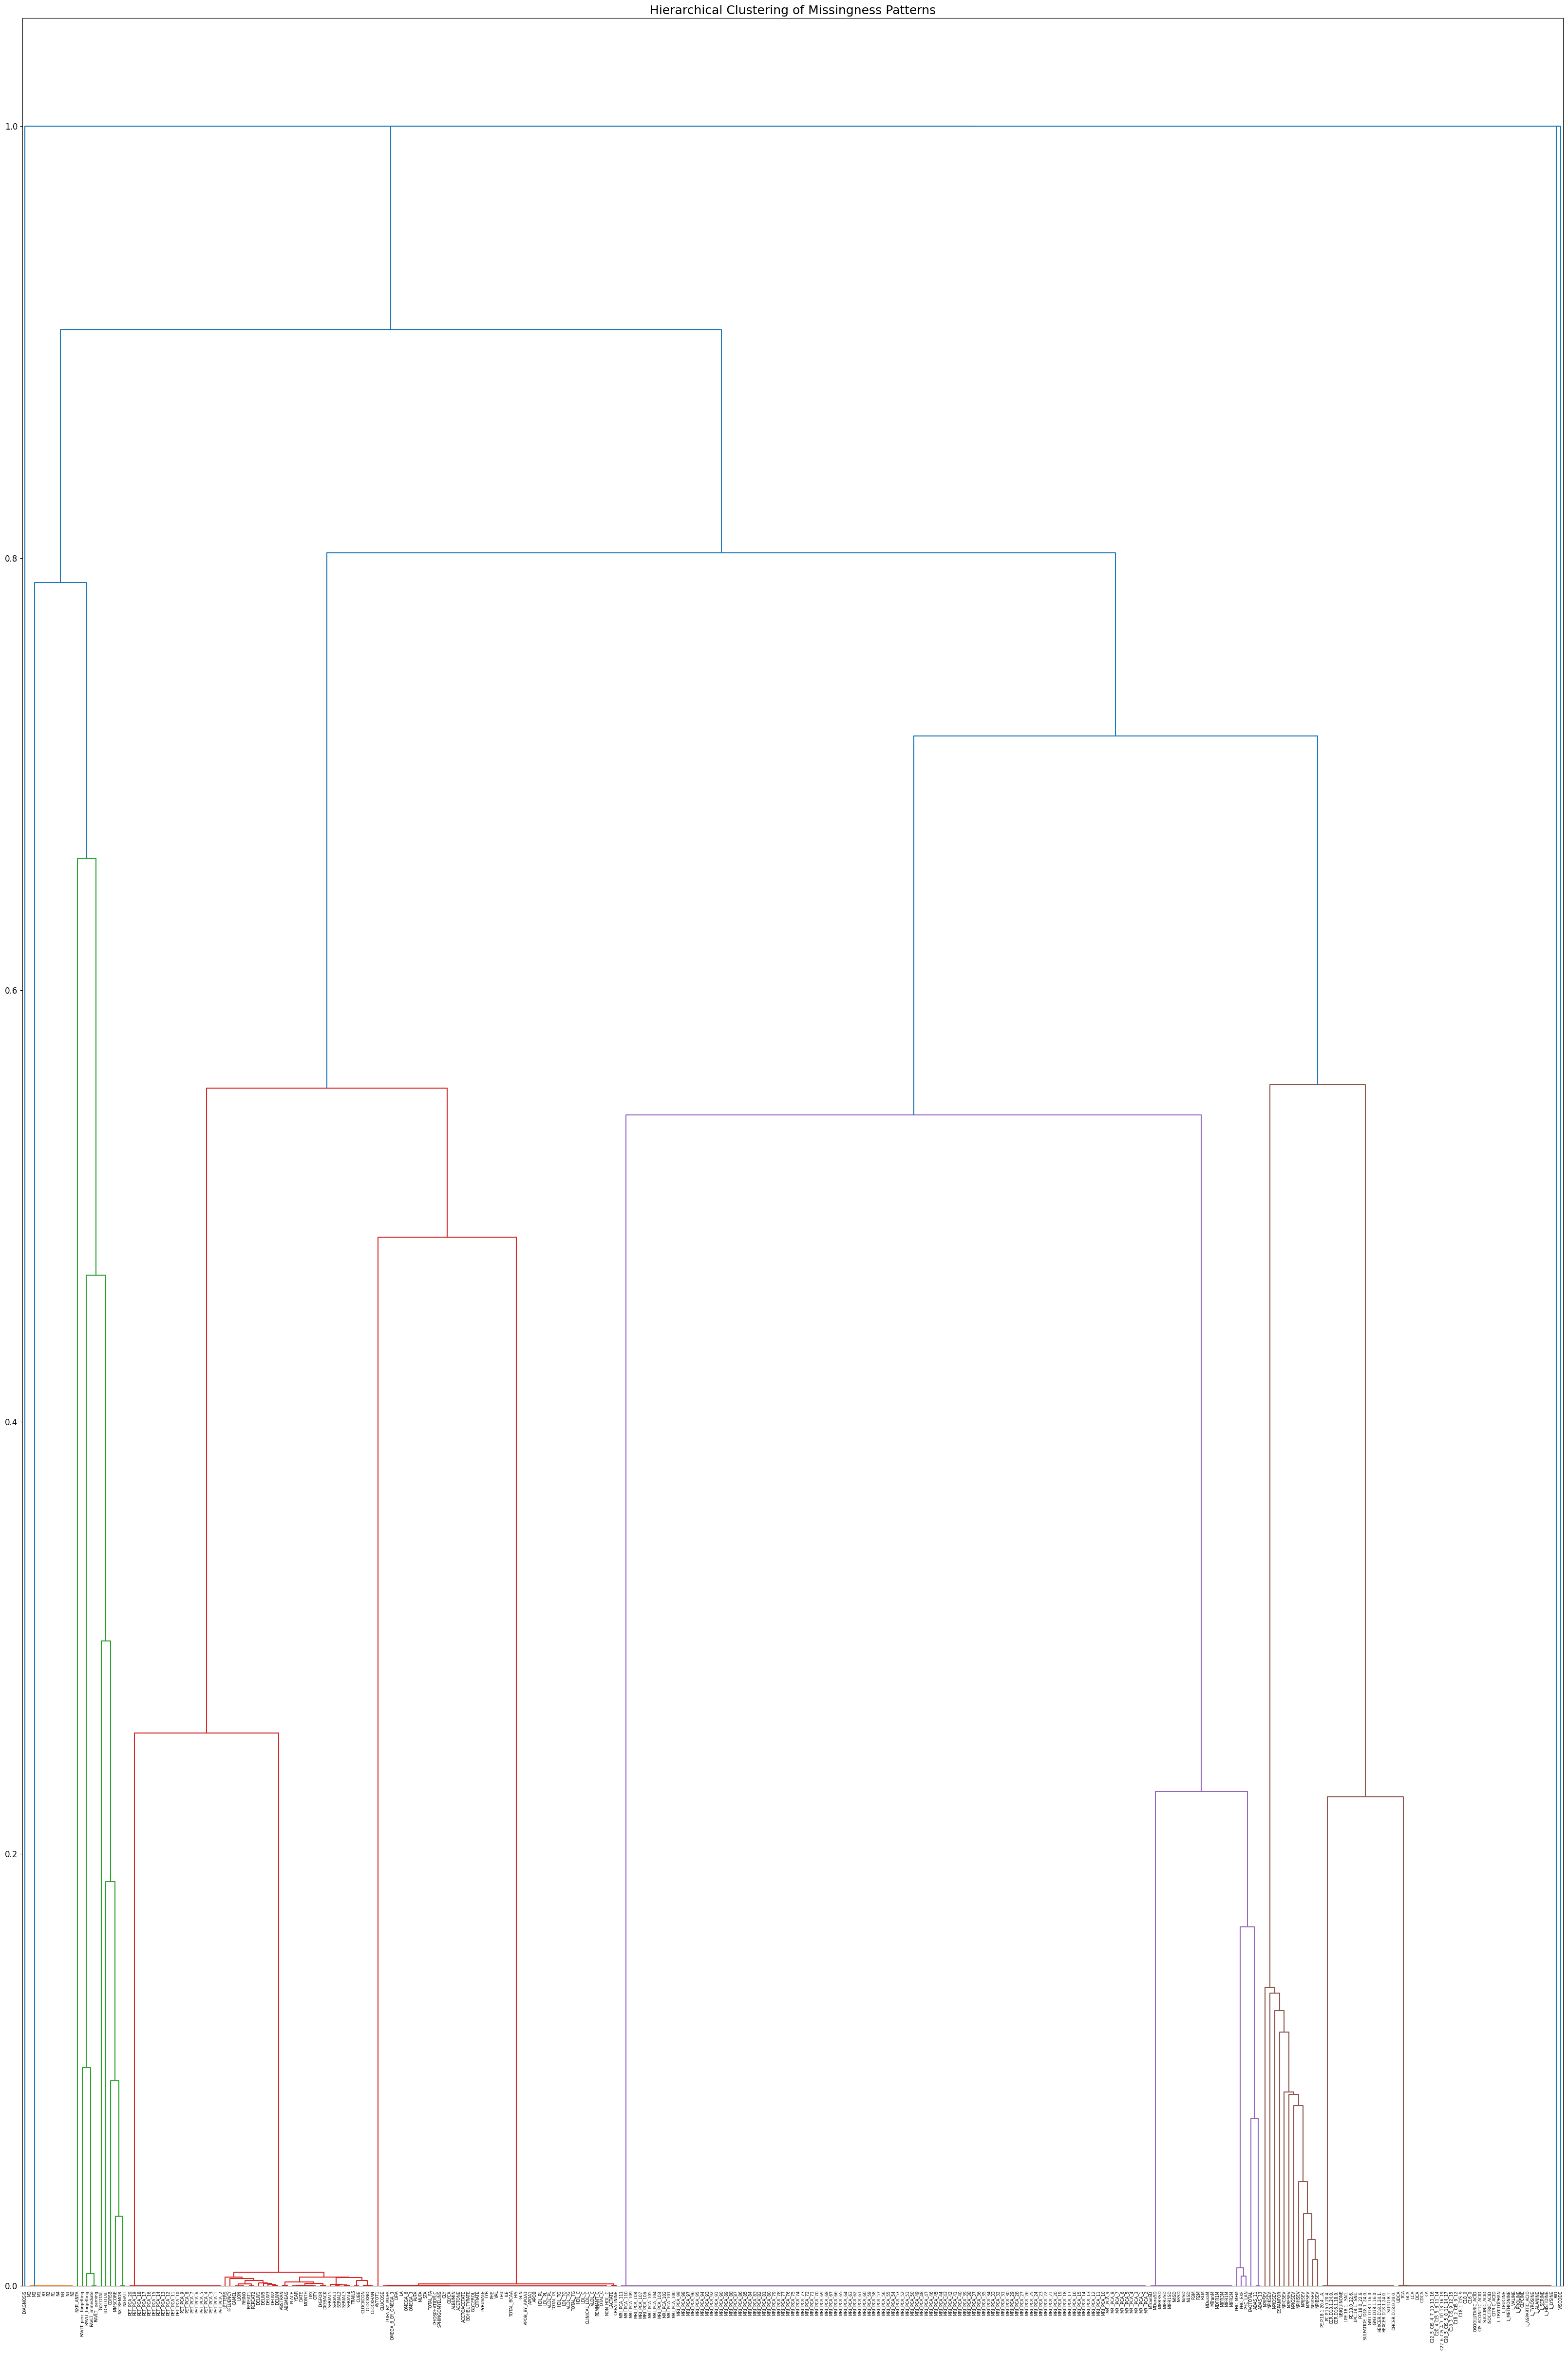

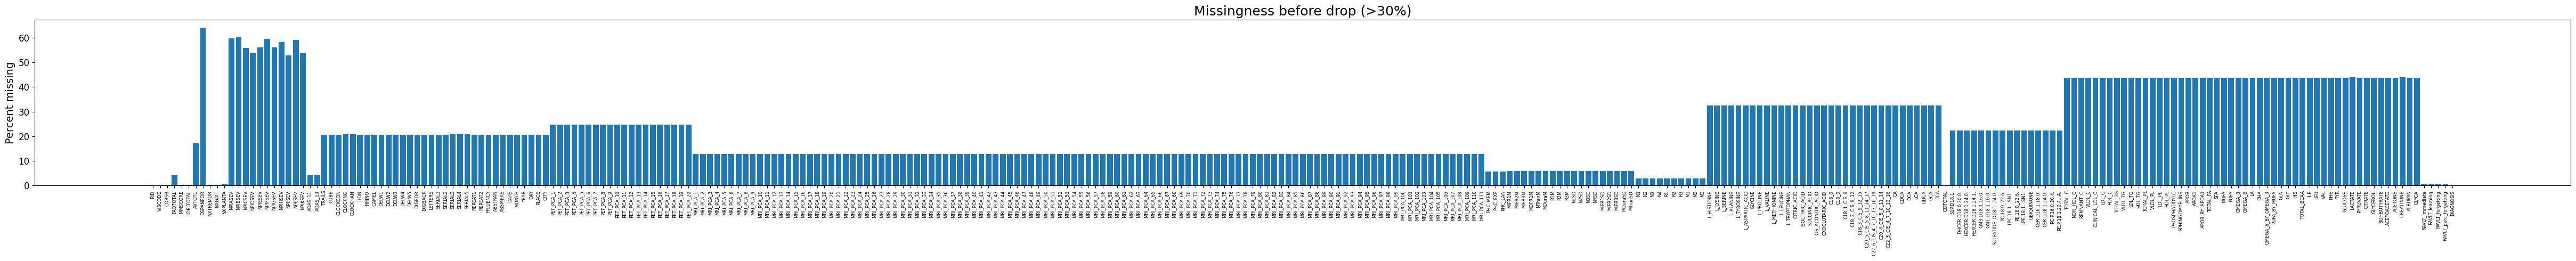

2025-08-24 03:47:12,722 INFO: Dropping 95 features >30% missing: ['DSPANFOR', 'NPIASEV', 'NPIBSEV', 'NPICSEV', 'NPIDSEV', 'NPIESEV', 'NPIFSEV', 'NPIGSEV', 'NPIHSEV', 'NPIISEV', 'NPIJSEV', 'NPIKSEV', 'L_HISTIDINE', 'L_LYSINE', 'L_SERINE', 'L_ALANINE', 'L_TYROSINE', 'L_ASPARTIC_ACID', 'GLYCINE', 'L_PROLINE', 'L_VALINE', 'L_METHIONINE', 'L_LEUCINE', 'L_TRYPTOPHAN', 'CITRIC_ACID', 'ISOCITRIC_ACID', 'SUCCINIC_ACID', 'CIS_ACONITIC_ACID', 'OXOGLUTARIC_ACID', 'C16_0', 'C18_0', 'C18_1_CIS_9', 'C18_2_CIS_9_12', 'C18_3_CIS_9_12_15', 'C20_5_CIS_5_8_11_14_17', 'C22_6_CIS_4_7_10_13_16_19', 'C20_4_CIS_5_8_11_14', 'C22_5_CIS_4_7_10_13_16', 'CA', 'CDCA', 'DCA', 'LCA', 'UDCA', 'GCA', 'TCA', 'TOTAL_C', 'NON_HDL_C', 'REMNANT_C', 'VLDL_C', 'CLINICAL_LDL_C', 'LDL_C', 'HDL_C', 'TOTAL_TG', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'TOTAL_PL', 'VLDL_PL', 'LDL_PL', 'HDL_PL', 'PHOSPHATIDYLC', 'SPHINGOMYELINS', 'APOB', 'APOA1', 'APOB_BY_APOA1', 'TOTAL_FA', 'SFA', 'MUFA', 'PUFA', 'OMEGA_3', 'OMEGA_6', 'LA', 'DHA', 'OMEGA_6_B

Dropped columns >30% missing: ['DSPANFOR', 'NPIASEV', 'NPIBSEV', 'NPICSEV', 'NPIDSEV', 'NPIESEV', 'NPIFSEV', 'NPIGSEV', 'NPIHSEV', 'NPIISEV', 'NPIJSEV', 'NPIKSEV', 'L_HISTIDINE', 'L_LYSINE', 'L_SERINE', 'L_ALANINE', 'L_TYROSINE', 'L_ASPARTIC_ACID', 'GLYCINE', 'L_PROLINE', 'L_VALINE', 'L_METHIONINE', 'L_LEUCINE', 'L_TRYPTOPHAN', 'CITRIC_ACID', 'ISOCITRIC_ACID', 'SUCCINIC_ACID', 'CIS_ACONITIC_ACID', 'OXOGLUTARIC_ACID', 'C16_0', 'C18_0', 'C18_1_CIS_9', 'C18_2_CIS_9_12', 'C18_3_CIS_9_12_15', 'C20_5_CIS_5_8_11_14_17', 'C22_6_CIS_4_7_10_13_16_19', 'C20_4_CIS_5_8_11_14', 'C22_5_CIS_4_7_10_13_16', 'CA', 'CDCA', 'DCA', 'LCA', 'UDCA', 'GCA', 'TCA', 'TOTAL_C', 'NON_HDL_C', 'REMNANT_C', 'VLDL_C', 'CLINICAL_LDL_C', 'LDL_C', 'HDL_C', 'TOTAL_TG', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'TOTAL_PL', 'VLDL_PL', 'LDL_PL', 'HDL_PL', 'PHOSPHATIDYLC', 'SPHINGOMYELINS', 'APOB', 'APOA1', 'APOB_BY_APOA1', 'TOTAL_FA', 'SFA', 'MUFA', 'PUFA', 'OMEGA_3', 'OMEGA_6', 'LA', 'DHA', 'OMEGA_6_BY_OMEGA_3', 'PUFA_BY_MUFA', 'GLN', 

In [18]:
# === Global style ===
plt.rcParams.update({
    'figure.dpi': 100,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

# Drop Features >30% Missing & Impute Time-Series Data

# (A) Standardize Missing Indicators
merged_data.replace(['NA','n/a','N/A','null','',' '], np.nan, inplace=True)
print("Standardized common missing value indicators to np.nan.")

# Exclude MRI and PET features 
mri_pet_features = set(mri_feats) | set(pet_feats)
to_drop = [c for c in merged_data.columns if c in mri_pet_features]
if to_drop:
    merged_data.drop(columns=to_drop, inplace=True)
    print("Excluded MRI/PET features:", to_drop)

# (B) Diagnosis-conditional forward-fill
def viscode_to_order(vis):
    return {"bl":0,"m06":6,"m12":12,"m18":18,"m24":24,"m30":30,
            "m36":36,"m42":42,"m48":48,"m54":54,"m60":60,"m66":66,
            "m72":72,"m78":78,"m84":84}.get(vis, np.nan)

def conditional_forward_fill(group, diag_col, fill_cols):
    """
    Forward-fill missing `fill_cols` when diagnosis stays the same.
    """
    g = group.copy()
    g['visit_order'] = g['VISCODE'].apply(viscode_to_order)
    g.sort_values('visit_order', inplace=True)
    out = g.copy()
    prev = None
    for idx, row in g.iterrows():
        if prev is not None and row[diag_col] == prev[diag_col]:
            for col in fill_cols:
                if pd.isna(row[col]):
                    out.at[idx, col] = prev[col]
        prev = out.loc[idx]
    return out.drop(columns='visit_order')

if 'DIAGNOSIS_ENC' in merged_data.columns:
    fill_cols = merged_data.columns.difference(['RID','VISCODE','DIAGNOSIS_ENC'])
    merged_data = (merged_data
        .groupby('RID')
        .apply(lambda g: conditional_forward_fill(g, 'DIAGNOSIS_ENC', fill_cols))
        .reset_index(drop=True)
    )
else:
    merged_data = merged_data.sort_values(['RID','VISCODE'])
    fill_cols = merged_data.columns.difference(['RID','VISCODE'])
    merged_data[fill_cols] = merged_data.groupby('RID')[fill_cols].ffill()

print("Completed diagnosis-conditional forward-fill.")

# (C) Missingness diagnostics
missing_pct = merged_data.isna().mean() * 100

# Heatmap of missingness
mask = merged_data.isna().astype(int).to_numpy().T
n_feats = mask.shape[0]
fig, ax = plt.subplots(figsize=(12, max(6, n_feats * 0.25)))
ax.imshow(mask, aspect='auto', interpolation='none')
ax.set_yticks(np.arange(n_feats))
ax.set_yticklabels(merged_data.columns, fontsize=max(6, min(12, 300 // n_feats)))
ax.set_xlabel("Row index", fontsize=14)
ax.set_title("Missingness Heatmap (1=present,0=missing)", fontsize=18)
plt.tight_layout()
plt.show()

# Bar chart of % missing
pct = missing_pct.sort_values(ascending=False)
n = len(pct)
fig, ax = plt.subplots(figsize=(max(10, n * 0.15), 6))
ax.bar(np.arange(n), pct.values)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(pct.index, rotation=90, fontsize=max(6, min(12, 300 // n)))
ax.set_ylabel("% missing", fontsize=14)
ax.set_title("Feature-wise Missingness", fontsize=18)
plt.tight_layout()
plt.show()

# Dendrogram of missingness patterns
corr = merged_data.isna().astype(int).corr().abs().fillna(0)
dist = 1 - corr
np.fill_diagonal(dist.values, 0)
Z = linkage(squareform(dist), method='average')

n_feats = corr.shape[0]
fig, ax = plt.subplots(figsize=(max(8, n_feats * 0.1), max(6, n_feats * 0.15)))
dendrogram(
    Z,
    labels=corr.index,
    leaf_rotation=90,
    leaf_font_size=max(6, min(12, 300 // n_feats)),
    ax=ax
)
ax.set_title("Hierarchical Clustering of Missingness Patterns", fontsize=18)
plt.tight_layout()
plt.show()

# (D) Metadata log
preproc_log = {
    "initial_shape": tuple(merged_data.shape),
    "standardized_missing_indicators": ['NA','n/a','N/A','null','',' '],
    "excluded_MRI_PET": to_drop,
    "missing_pct": missing_pct.to_dict()
}

# (E) Compute & record missing-rate before drop (>30%), plot, then drop high-missing features

# 1. Compute percent missing before drop
missing_before = merged_data.isna().mean() * 100
preproc_log["missing_before_pct"] = missing_before.to_dict()

# 2. Plot missingness before drop
n = len(missing_before)
fig, ax = plt.subplots(figsize=(max(10, n * 0.15), 5))
ax.bar(range(n), missing_before.values)
ax.set_xticks(range(n))
ax.set_xticklabels(missing_before.index, rotation=90,
                   fontsize=max(6, min(12, 300 // n)))
ax.set_ylabel("Percent missing", fontsize=14)
ax.set_title("Missingness before drop (>30%)", fontsize=18)
plt.tight_layout()
plt.show()

# 3. Identify & drop features with >30% missing (excluding targets and IDs)
targets = {"ADAS_11","ADAS_13","MMSCORE","FAQTOTAL","CDRSB"}
threshold_pct = 30
cols_to_drop = [
    c for c, pct in missing_before.items()
    if pct > threshold_pct and c not in (*targets, "RID", "VISCODE")
]
logging.info(f"Dropping {len(cols_to_drop)} features >{threshold_pct}% missing: {cols_to_drop}")
merged_data.drop(columns=cols_to_drop, inplace=True)
preproc_log["dropped_>30pct_missing"] = cols_to_drop

print("Dropped columns >30% missing:", cols_to_drop)
print("After drop, shape =", merged_data.shape)

# (F) Add inter-visit interval feature using the actual 'DATE' column
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
merged_data.sort_values(['RID','DATE'], inplace=True)
merged_data['days_since_prev'] = (
    merged_data
      .groupby('RID')['DATE']
      .diff()
      .dt.days
      .fillna(0)
)

# (G) Separate numeric vs categorical
num_cols = merged_data.select_dtypes(include=[np.number]).columns.drop(['RID','DIAGNOSIS_ENC'], errors='ignore')
cat_cols = [c for c in merged_data.columns if c not in num_cols and c not in ['RID','VISCODE','DIAGNOSIS_ENC','EXAMDATE']]

# (H) Group-mean impute numeric by diagnosis
if 'DIAGNOSIS_ENC' in merged_data:
    for diag in merged_data['DIAGNOSIS_ENC'].unique():
        mask = merged_data['DIAGNOSIS_ENC'] == diag
        for col in num_cols:
            merged_data.loc[mask, col] = merged_data.loc[mask, col].fillna(
                merged_data.loc[mask, col].mean()
            )

# (I) Group-mode impute categorical by diagnosis
if 'DIAGNOSIS_ENC' in merged_data:
    for diag in merged_data['DIAGNOSIS_ENC'].unique():
        mask = merged_data['DIAGNOSIS_ENC'] == diag
        for col in cat_cols:
            mode = merged_data.loc[mask, col].mode()
            if not mode.empty:
                merged_data.loc[mask, col] = merged_data.loc[mask, col].fillna(mode.iloc[0])

# (J) Drop diagnosis encoding column
merged_data.drop(columns=['DIAGNOSIS_ENC'], inplace=True, errors='ignore')

# (K) Final standard scaling
scaler_ts = StandardScaler()
scale_cols = [c for c in merged_data.select_dtypes(include=[np.number]).columns if c!='RID']
merged_data[scale_cols] = scaler_ts.fit_transform(merged_data[scale_cols])
print("After standard scaling, final shape =", merged_data.shape)

# (L) Dump metadata log
with open("preprocessing_log.json", "w") as f:
    json.dump(preproc_log, f, indent=2)

## <center> Step 16: Extract Statistical Features from Time-Series
Use the extract_statistical_features helper to generate per-subject summary metrics: mean, standard deviation, minimum, maximum, median, and count for every numeric variable (excluding VISCODE). Group the data by RID, prefix each new feature with stats_, reset the index for a tidy output, and verify the resulting shape of stats_features to ensure you have one row per subject.

In [19]:
# Extract Statistical Features from the FINAL preprocessed time‐series
def extract_statistical_features(df, prefix, group_col="RID", exclude_cols=["VISCODE"]):
    """
    Groups the input DataFrame by group_col and computes summary statistics
    (mean, std, min, max, median, count) for each numeric column (excluding those in exclude_cols).
    Each new column is named using the provided prefix.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if group_col in numeric_cols:
        numeric_cols.remove(group_col)
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    if not numeric_cols:
        return None
    agg_df = df.groupby(group_col)[numeric_cols].agg(["mean", "std", "min", "max", "median", "count"])
    agg_df.columns = [f"{prefix}_{col}_{stat}" for col, stat in agg_df.columns]
    agg_df.reset_index(inplace=True)
    return agg_df
# make sure RID is a string
merged_data["RID"] = merged_data["RID"].astype(str)

# reuse your helper to get one row per subject:
stats_features = extract_statistical_features(
    merged_data,
    prefix="stats",        # you'll get stats_<col>_{mean,std,min,max,median,count}
    group_col="RID",
    exclude_cols=["VISCODE"]
)

print("Aggregated stats from merged_data shape:", stats_features.shape)

Aggregated stats from merged_data shape: (2271, 1357)


C:\Users\Asus\AppData\Local\Temp\ipykernel_14292\2800298136.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df.reset_index(inplace=True)


## <center> Step 17: Filter Subjects, Build Modality Tensors & Align
We first identify all subjects with a true baseline visit (“bl”) and a recorded diagnosis, then filter every source table to retain only those “good” RIDs. From the filtered merged dataset we rebuild our static feature matrix—selecting all remaining numeric columns (excluding IDs, time codes, and outcome targets), dropping duplicates so there’s exactly one row per subject, and converting it into a NumPy array alongside its ordered RID list. We then define a helper, create_modality_tensor, which takes any longitudinal DataFrame, limits it to our expected visit codes, selects numeric features, and for each subject constructs a fixed-length sequence matrix (visits × features) by forward-filling missing timepoints from baseline or the previous visit. Using this function, we build separate 3D tensors for cognitive tests, clinical assessments, metabolomics, MRI and PET embeddings, and regression targets (ADAS-13, MMSE, FAQ total, CDR-SB), each with its own RID index. Finally, we compute the union of all RID sets, pad each tensor and the static feature array so they align to this common subject order (filling absent entries with NaNs), and print out the number of subjects and the shape of each tensor as a final sanity check.

In [20]:
# 0) Find RIDs with a true baseline in merged_data
bl_rids = set(
    merged_data.loc[
        merged_data['VISCODE'].str.lower().eq('bl'),
        'RID'
    ].astype(str)
)

# 1) Find RIDs in your diagnosis table
sd = subject_diagnosis.copy()
sd['RID'] = sd['RID'].astype(str)
diag_rids = set(sd['RID'])

# 2) Keep only those with both baseline & a diagnosis
good_rids = bl_rids & diag_rids

# 3) A helper to filter any df to those RIDs
def keep_good(df):
    df = df.copy()
    df['RID'] = df['RID'].astype(str)
    return df[df['RID'].isin(good_rids)]

# 4) Apply that filter to *all* your source tables
for name in [
    'moca_data','adspCognitive_data','embicCognitive_data','embicDigital_data',
    'neurobattery_data','neuroexam_data','npiq_data','GeriatricDepressionScale_data',
    'GutMetabolites_data','lipidomics_data','lipoproteins_data',
    'mri_pca_visits_df','pet_pca_visits_df','merged_data'
]:
    globals()[name] = keep_good(globals()[name])

# 5) Rebuild static_df *after* filtering merged_data
static_vars = [
    c for c in merged_data.columns
    if c not in ['RID','VISCODE','ADAS_13','MMSCORE','FAQTOTAL','CDRSB']
       and pd.api.types.is_numeric_dtype(merged_data[c])
]
static_df = (
    merged_data[['RID'] + static_vars]
      .drop_duplicates('RID')
      .assign(RID=lambda df: df['RID'].astype(str))
      .reset_index(drop=True)
)
static_features = static_df[static_vars].to_numpy(dtype=float)
static_rids     = static_df['RID'].to_numpy(dtype=str)

# 6) Now create your modality‐building helper
expected_visits = ["bl","m06","m12","m18","m24","m30","m36","m42","m48","m54","m60","m66","m72","m78","m84"]
def create_modality_tensor(df, modality_vars=None):
    df = df.copy()
    df['VISCODE'] = df['VISCODE'].str.lower().str.strip()
    df = df[df['VISCODE'].isin(expected_visits)]
    # pick numeric features
    if modality_vars is None:
        feat_cols = [c for c in df.columns if c not in ('RID','VISCODE') and pd.api.types.is_numeric_dtype(df[c])]
    else:
        feat_cols = [c for c in modality_vars if c in df.columns]
    visit_idx = {v:i for i,v in enumerate(expected_visits)}
    out = {}
    for rid, grp in df.groupby('RID'):
        seq = np.full((len(expected_visits), len(feat_cols)), np.nan)
        for _, row in grp.iterrows():
            i = visit_idx[row['VISCODE']]
            seq[i] = row[feat_cols].to_numpy(dtype=float)
        # baseline fill + forward‐fill
        if np.isnan(seq[0,0]):
            v = np.where(~np.isnan(seq[:,0]))[0]
            if v.size: seq[0] = seq[v[0]]
        for i in range(1,len(expected_visits)):
            if np.isnan(seq[i,0]):
                seq[i] = seq[i-1]
        out[str(rid)] = seq
    rids = sorted(out)
    if not rids:
        return np.empty((0,len(expected_visits),0)), np.array([],dtype=str)
    tensor = np.stack([out[r] for r in rids])
    return tensor, np.array(rids,dtype=str)

# 7) Build each tensor
cog_df = reduce(lambda L,R: pd.merge(L,R,on=['RID','VISCODE'],how='outer'),
                [moca_data,adspCognitive_data,embicCognitive_data,embicDigital_data])
cognitive_tensor, cog_rids = create_modality_tensor(cog_df)

assess_df = reduce(lambda L,R: pd.merge(L,R,on=['RID','VISCODE'],how='outer'),
                   [neurobattery_data, neuroexam_data, npiq_data, GeriatricDepressionScale_data])
assess_tensor, assess_rids = create_modality_tensor(assess_df)

neuro_df = reduce(lambda L,R: pd.merge(L,R,on=['RID','VISCODE'],how='outer'),
                  [GutMetabolites_data, lipidomics_data, lipoproteins_data])
neuropath_tensor, neuro_rids = create_modality_tensor(neuro_df)

mri_tensor, mri_rids = create_modality_tensor(mri_pca_visits_df)
pet_tensor, pet_rids = create_modality_tensor(pet_pca_visits_df)

# 8) Regression tensor
targets = ["ADAS_13","MMSCORE","FAQTOTAL","CDRSB"]
regression_vars = [c for c in targets if c in merged_data.columns]
reg_tensor, reg_rids = create_modality_tensor(merged_data, modality_vars=regression_vars)

# 9) Align all to the same union of RIDs
union_rids = sorted({*cog_rids,*mri_rids,*pet_rids,*assess_rids,*neuro_rids,*reg_rids,*static_rids})
def add_missing(tensor, rids, union):
    feat = tensor.shape[2] if tensor.size else 0
    m = {rid:tensor[i] for i,rid in enumerate(rids)}
    return np.stack([m.get(r,np.full((len(expected_visits),feat),np.nan)) for r in union])
def add_static(arr, rids, union):
    feat = arr.shape[1] if arr.size else 0
    m = {rid:arr[i] for i,rid in enumerate(rids)}
    return np.stack([m.get(r,np.full((feat,),np.nan)) for r in union])

cognitive_tensor = add_missing(cognitive_tensor, cog_rids, union_rids)
mri_tensor       = add_missing(mri_tensor,       mri_rids, union_rids)
pet_tensor       = add_missing(pet_tensor,       pet_rids, union_rids)
assess_tensor    = add_missing(assess_tensor,    assess_rids, union_rids)
neuropath_tensor = add_missing(neuropath_tensor, neuro_rids, union_rids)
reg_tensor       = add_missing(reg_tensor,       reg_rids, union_rids)
static_features  = add_static(static_features,   static_rids, union_rids)

# 10) Final sanity-check
print("Subjects:", len(union_rids))
print("cognitive:", cognitive_tensor.shape)
print("mri:      ", mri_tensor.shape)
print("pet:      ", pet_tensor.shape)
print("assess:   ", assess_tensor.shape)
print("neuro:    ", neuropath_tensor.shape)
print("regress:  ", reg_tensor.shape)
print("static:   ", static_features.shape)

Subjects: 2271
cognitive: (2271, 15, 63)
mri:       (2271, 15, 111)
pet:       (2271, 15, 20)
assess:    (2271, 15, 62)
neuro:     (2271, 15, 50)
regress:   (2271, 15, 4)
static:    (2271, 222)


## <center> Step 18: Baseline Cohort Characterization (Diagnosis, Gender, Age & Education)
In this step, we first inspect the diagnosis table’s columns and ensure every RID is a string, then create a diag_series aligned to our master list of subjects (union_rids) that records each subject’s baseline diagnosis; we compute and print the counts and percentages of each diagnosis category. Next, we pull gender from the demographics table, grouping by RID, taking the first recorded PTGENDER value, mapping numeric codes to “Male”/“Female,” and reporting its distribution over the same subject set. Finally, we load the full demographics CSV to extract each subject’s earliest (baseline) visit, calculate age at baseline as the difference between visit year and birth year, and compute and print the mean and standard deviation of both age and years of education.

In [21]:
print(sd.columns.tolist())

# 1) Ensure RID is string
sd = subject_diagnosis.copy()
sd['RID'] = sd['RID'].astype(str)

# 2) Build a Series aligned to union
diag_map = sd.set_index('RID')['DIAGNOSIS']
diag_series = pd.Series(
    [diag_map.get(rid, np.nan) for rid in union_rids],
    index=union_rids,
    name='baseline_diag'
)

# 3) Compute counts & percentages
counts  = diag_series.value_counts(dropna=False).sort_index()
percent = diag_series.value_counts(normalize=True, dropna=False).mul(100).round(2).sort_index()

diag_df = pd.DataFrame({'count': counts, 'percent': percent})

print(f"Baseline diagnostic distribution over {len(union_rids)} subjects:\n")
print(diag_df)

# 1) Load and align
sd = demographics_data.copy()
sd['RID'] = sd['RID'].astype(str)

# 2) Build a RID to gender map by taking the first entry for each RID
gender_map = sd.groupby('RID')['PTGENDER'].first()

# 3) Align to union_rids
gender_series = pd.Series(
    [gender_map.get(rid, np.nan) for rid in union_rids],
    index=union_rids,
    name='baseline_gender'
)

# 4) Map numeric codes to labels
gender_series = gender_series.map({1: 'Male', 2: 'Female'})

# 5) Compute counts & percentages
counts  = gender_series.value_counts(dropna=False).sort_index()
percent = gender_series.value_counts(normalize=True, dropna=False).mul(100).round(2).sort_index()

gender_df = pd.DataFrame({'count': counts, 'percent': percent})

print(f"Baseline gender distribution over {len(union_rids)} subjects:\n")
print(gender_df)

# 1) Load baseline demographics
dem = pd.read_csv(demographics_file, usecols=["RID", "PTGENDER", "PTDOBYY", "VISDATE", "PTEDUCAT"])
dem["RID"] = dem["RID"].astype(str)
dem["VISDATE"] = pd.to_datetime(dem["VISDATE"], errors="coerce")

# 2) Keep only each subject’s earliest (baseline) visit
baseline = (
    dem.sort_values("VISDATE")
       .groupby("RID", as_index=False)
       .first()
       .set_index("RID")
)

# 4) Age at baseline (visit year minus birth year)
baseline["age"] = baseline["VISDATE"].dt.year - baseline["PTDOBYY"]
age_mean, age_sd = baseline["age"].mean(), baseline["age"].std()
print(f"\nAge at baseline: mean = {age_mean:.1f} years, SD = {age_sd:.1f} years")

# 5) Years of education
edu_mean, edu_sd = baseline["PTEDUCAT"].mean(), baseline["PTEDUCAT"].std()
print(f"Years of education: mean = {edu_mean:.1f}, SD = {edu_sd:.1f}")

['RID', 'DIAGNOSIS']
Baseline diagnostic distribution over 2271 subjects:

               count  percent
baseline_diag                
1.0              852    37.52
2.0             1032    45.44
3.0              387    17.04
Baseline gender distribution over 2271 subjects:

                 count  percent
baseline_gender                
Female            1065     46.9
Male              1206     53.1

Age at baseline: mean = 72.2 years, SD = 7.8 years
Years of education: mean = 15.9, SD = 2.9


## <center> Step 19: Data Preparation and Split Processing Pipeline

This code prepares and processes the multimodal dataset for model training and evaluation. It first encodes categorical diagnoses into numeric labels and constructs an aligned xarray.Dataset combining cognitive, MRI, PET, assessment, neuropathology, regression, and static features indexed by subject and visit. Subjects present in both the dataset and diagnosis table are intersected to extract labels for stratified splitting. A custom DiagnosisKNNImputer is defined to impute missing values within each diagnosis group, preserving group-specific distributions. The script then performs 10 repeated 60/20/20 stratified train–validation–test splits, ensuring balanced class distributions across folds. For each split, subject-level statistics are imputed, standardized, and reduced via PCA to retain 91% variance before merging with static background features. Regression time-series features are flattened, cleaned, and scaled using a StandardScaler fit on the training set. Finally, all split metadata, labels, PCA outputs, merged background features, regression scalers, and scaled regression arrays are stored in all_splits for downstream cross-validation experiments.

In [22]:
#  One-time prep outside the loop #

# (0) Encode diagnosis
subject_diagnosis = subject_diagnosis.copy()
subject_diagnosis["RID"] = subject_diagnosis["RID"].astype(str)
if "DIAGNOSIS_ENC" not in subject_diagnosis.columns:
    subject_diagnosis["DIAGNOSIS_ENC"] = (
        subject_diagnosis["DIAGNOSIS"].astype("category").cat.codes
    )

# (1) Build aligned xarray
ds_aligned = xr.Dataset({
    "cognitive":      (("subject", "visit", "cognitive_feature"), cognitive_tensor),
    "mri":            (("subject", "visit", "mri_feature"),         mri_tensor),
    "pet":            (("subject", "visit", "pet_feature"),         pet_tensor),
    "assessment":     (("subject", "visit", "assessment_feature"),  assess_tensor),
    "neuropathology": (("subject", "visit", "neuropathology_feature"), neuropath_tensor),
    "regression":     (("subject", "visit", "regression_feature"),  reg_tensor),
    "static":         (("subject", "static_feature"),              static_features),
}, coords={
    "subject":           union_rids,
    "visit":             expected_visits,
    "cognitive_feature":      np.arange(cognitive_tensor.shape[2]),
    "mri_feature":            np.arange(mri_tensor.shape[2]),
    "pet_feature":            np.arange(pet_tensor.shape[2]),
    "assessment_feature":     np.arange(assess_tensor.shape[2]),
    "neuropathology_feature": np.arange(neuropath_tensor.shape[2]),
    "regression_feature":     np.arange(reg_tensor.shape[2]),
    "static_feature":         np.arange(static_features.shape[1]),
})

# (2) Intersect subjects + gather labels
common_rids = sorted(set(ds_aligned.subject.values) & set(subject_diagnosis.RID))
subject_diag_common = (
    subject_diagnosis.set_index("RID")
                     .loc[common_rids]
                     .reset_index()
)
diag_labels = subject_diag_common["DIAGNOSIS_ENC"].values

# Keep a pristine copy of stats_features
if stats_features.index.name == "RID":
    stats_base = stats_features.reset_index()
else:
    stats_base = stats_features.copy()
stats_base["RID"] = stats_base["RID"].astype(str)

# (3) Diagnosis-aware KNN imputer
class DiagnosisKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, categorical_cols=(), k=10):
        """Initialize with numeric/categorical column names, 
        number of KNN neighbors (k), and prepare storage for fitted imputers."""
        self.numeric_cols = list(numeric_cols)
        self.categorical_cols = list(categorical_cols)
        self.k = k
        self.imputers_ = {}

    def fit(self, X, y=None):
        """Fit a scaler and KNN imputer for each diagnosis group in X."""
        for diag, sub in X.groupby("DIAGNOSIS_ENC"):
            num = sub[self.numeric_cols].fillna(0)
            scaler = StandardScaler().fit(num)
            knn = KNNImputer(n_neighbors=self.k)
            knn.fit(scaler.transform(num))
            self.imputers_[diag] = (scaler, knn)
        return self

    def transform(self, X):
        """Impute missing numeric and categorical values for each diagnosis group."""
        X = X.copy()
        for diag, idx in X.groupby("DIAGNOSIS_ENC").groups.items():
            scaler, knn = self.imputers_[diag]
            block = X.loc[idx, self.numeric_cols].fillna(0)
            imputed = scaler.inverse_transform(knn.transform(scaler.transform(block)))
            X.loc[idx, self.numeric_cols] = imputed
            for col in self.categorical_cols:
                mode = X.loc[idx, col].mode()
                if not mode.empty:
                    X.loc[idx, col] = X.loc[idx, col].fillna(mode.iloc[0])
        return X

# — Loop over splits — #
n_repeats = 10
all_splits = []

for seed in range(n_repeats):
    # 4) Stratified 60/20/20 split
    r_train, r_temp = train_test_split(
        common_rids, test_size=0.4, random_state=seed, stratify=diag_labels
    )
    temp_lbls = subject_diag_common.set_index("RID").loc[r_temp]["DIAGNOSIS_ENC"]
    r_val, r_test = train_test_split(
        r_temp, test_size=0.5, random_state=seed, stratify=temp_lbls
    )
    train_ids, val_ids, test_ids = map(sorted, (r_train, r_val, r_test))

    # 5) Slice xarray by subject
    ds_tr  = ds_aligned.sel(subject=train_ids)
    ds_val = ds_aligned.sel(subject=val_ids)
    ds_te  = ds_aligned.sel(subject=test_ids)

    # 6) Extract labels
    y_tr = subject_diag_common.set_index("RID").loc[train_ids]["DIAGNOSIS_ENC"].values
    y_va = subject_diag_common.set_index("RID").loc[val_ids]["DIAGNOSIS_ENC"].values
    y_te = subject_diag_common.set_index("RID").loc[test_ids]["DIAGNOSIS_ENC"].values

    # 7) Stats‐PCA pipeline inside loop
    sf = (stats_base
          .merge(subject_diag_common[["RID","DIAGNOSIS_ENC"]], on="RID", how="left")
          .set_index("RID"))

    # — Cast numeric features to float to avoid dtype warnings —
    agg_numeric = [c for c in sf.columns if c != "DIAGNOSIS_ENC"]
    sf[agg_numeric] = sf[agg_numeric].astype(float)

    # Filter to existing rows
    train_idx = [rid for rid in train_ids if rid in sf.index]
    val_idx   = [rid for rid in val_ids   if rid in sf.index]
    test_idx  = [rid for rid in test_ids  if rid in sf.index]

    pipeline = Pipeline([
        ("diag_knn", DiagnosisKNNImputer(numeric_cols=agg_numeric, k=10)),
        ("scaler",   StandardScaler()),
        ("pca",      PCA(n_components=0.91, random_state=seed)),
    ])

    train_df = sf.loc[train_idx]
    val_df   = sf.loc[val_idx]
    test_df  = sf.loc[test_idx]

    pipeline.fit(train_df)
    pca_tr = pipeline.transform(train_df)
    pca_va = pipeline.transform(val_df)
    pca_te = pipeline.transform(test_df)

    pca_cols = [f"stats_PCA_{i+1}" for i in range(pca_tr.shape[1])]
    df_tr = pd.DataFrame(pca_tr, index=train_df.index, columns=pca_cols)
    df_va = pd.DataFrame(pca_va, index=val_df.index,   columns=pca_cols)
    df_te = pd.DataFrame(pca_te, index=test_df.index,  columns=pca_cols)
    stats_pca_df = pd.concat([df_tr, df_va, df_te]).sort_index()

    # 8) Merge PCA into background
    bg = final_static.copy()
    if bg.index.name == "RID":
        bg = bg.reset_index()
    bg["RID"] = bg["RID"].astype(str)
    background_with_stats = bg.merge(
        stats_pca_df.reset_index(), on="RID", how="left"
    )

    # 9) Regression cleaning & scaling
    def clean_and_flatten(da):
        arr = np.nan_to_num(da.values, nan=0.0, posinf=0.0, neginf=0.0)
        s0,s1,s2 = arr.shape
        return arr.reshape(-1, s2), arr

    flat_tr, reg_tr = clean_and_flatten(ds_tr["regression"])
    _,       reg_va = clean_and_flatten(ds_val["regression"])
    _,       reg_te = clean_and_flatten(ds_te["regression"])

    scaler_reg = StandardScaler().fit(flat_tr)

    def reshape_and_apply(tensor):
        s0,s1,s2 = tensor.shape
        scaled = scaler_reg.transform(tensor.reshape(-1, s2))
        return scaled.reshape(s0, s1, s2)

    regression_scaled = {
        "train": reshape_and_apply(reg_tr),
        "val":   reshape_and_apply(reg_va),
        "test":  reshape_and_apply(reg_te),
    }

    # 10) Store split outputs
    all_splits.append({
        "seed":                   seed,
        "train_ids":              train_ids,
        "val_ids":                val_ids,
        "test_ids":               test_ids,
        "y":                      {"train": y_tr, "val": y_va, "test": y_te},
        "stats_pca_df":           stats_pca_df,
        "background_with_stats":  background_with_stats,
        "regression_scaler":      scaler_reg,
        "regression_scaled":      regression_scaled
    })

print(f"Finished processing {len(all_splits)} splits.")

Finished processing 10 splits.


## <center> Step 20: Split Inspection and Data Shape Verification

This code iterates over all stored dataset splits in all_splits and prints key information for verification. For each split, it:

Displays the split seed for reproducibility tracking.

Re-slices the aligned xarray.Dataset to extract the train, validation, and test subsets.

Prints the shape of each feature modality (cognitive, mri, pet, assessment, neuropathology, regression, static) for every data phase, ensuring correct subject, visit, and feature dimensions.

Reports the shape of the label arrays (y) for each phase.

Shows the shape of the PCA-reduced statistics DataFrame (stats_pca_df) and the merged background features with PCA components (background_with_stats).

Outputs the shapes of the scaled regression time-series arrays for train, validation, and test sets.

This inspection step helps confirm that all data components are correctly aligned, preprocessed, and ready for modeling before training begins.

In [23]:
for split in all_splits:
    seed = split["seed"]
    print(f"\n=== Split {seed} ===")

    # Re‐slice xarray for this split
    train_ids = split["train_ids"]
    val_ids   = split["val_ids"]
    test_ids  = split["test_ids"]

    ds_tr  = ds_aligned.sel(subject=train_ids)
    ds_val = ds_aligned.sel(subject=val_ids)
    ds_te  = ds_aligned.sel(subject=test_ids)

    # 1) Feature modalities
    for phase, ds in [("TRAIN", ds_tr), ("VAL", ds_val), ("TEST", ds_te)]:
        print(f"\n  {phase} modal shapes:")
        for var in ds.data_vars:
            arr = ds[var].values
            print(f"    {var:<14}: {arr.shape}")

    # 2) y‐labels
    for phase in ["train", "val", "test"]:
        y = split["y"][phase]
        print(f"  {phase.upper()} y shape: {y.shape}")

    # 3) stats_pca_df
    pca_df = split["stats_pca_df"]
    print(f"  stats_pca_df shape:           {pca_df.shape}")

    # 4) background_with_stats
    bg = split["background_with_stats"]
    print(f"  background_with_stats shape:  {bg.shape}")

    # 5) regression_scaled
    print("  regression_scaled shapes:")
    for phase in ["train", "val", "test"]:
        reg = split["regression_scaled"][phase]
        print(f"    {phase:<5}: {reg.shape}")


=== Split 0 ===

  TRAIN modal shapes:
    cognitive     : (1362, 15, 63)
    mri           : (1362, 15, 111)
    pet           : (1362, 15, 20)
    assessment    : (1362, 15, 62)
    neuropathology: (1362, 15, 50)
    regression    : (1362, 15, 4)
    static        : (1362, 222)

  VAL modal shapes:
    cognitive     : (454, 15, 63)
    mri           : (454, 15, 111)
    pet           : (454, 15, 20)
    assessment    : (454, 15, 62)
    neuropathology: (454, 15, 50)
    regression    : (454, 15, 4)
    static        : (454, 222)

  TEST modal shapes:
    cognitive     : (455, 15, 63)
    mri           : (455, 15, 111)
    pet           : (455, 15, 20)
    assessment    : (455, 15, 62)
    neuropathology: (455, 15, 50)
    regression    : (455, 15, 4)
    static        : (455, 222)
  TRAIN y shape: (1362,)
  VAL y shape: (454,)
  TEST y shape: (455,)
  stats_pca_df shape:           (2271, 224)
  background_with_stats shape:  (3607, 249)
  regression_scaled shapes:
    train: (1362, 1

## <center> Step 21: Multimodal CNN–BiLSTM Model Training, Evaluation, and Visualization

This section defines, trains, evaluates, and visualizes both a baseline and an uncertainty-weighted multimodal CNN–BiLSTM model for joint classification and regression tasks. It first constructs modality-specific temporal pipelines, a background feature network, a shared fusion block, and multitask output heads, then integrates them into a full multimodal architecture. A custom MultiTaskUncertaintyModel extends Keras to incorporate homoscedastic uncertainty weighting. For each split in all_splits, the code prepares scaled inputs and targets, trains the base model and the uncertainty model, computes classification metrics (F1, recall, precision, accuracy) and regression metrics (R², Pearson r, MAE, RMSE), and logs results to CSV. After cross-validation, it summarizes mean and standard deviation metrics, then produces visualizations including classification metric bar plots, confusion matrices, regression true–predicted scatter plots with fitted lines, and saliency heatmaps to highlight modality–timepoint contributions for regression heads. This end-to-end workflow covers model definition, training, evaluation, and interpretability analysis.

2025-08-24 03:48:10,029 WARNING: From C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\core.py:232: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



[Fold 0] Epoch 1
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - classification_loss: 1.1689 - loss: 27.7061 - regression_adas_loss: 1.3000 - regression_cdrsb_loss: 1.3681 - regression_faq_loss: 1.1665 - regression_mmse_loss: 1.2688 - val_classification_loss: 1.1318 - val_loss: 26.2245 - val_regression_adas_loss: 1.2986 - val_regression_cdrsb_loss: 1.2294 - val_regression_faq_loss: 0.9620 - val_regression_mmse_loss: 1.4413
[Fold 0] Epoch 2
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - classification_loss: 1.1120 - loss: 25.7794 - regression_adas_loss: 1.0635 - regression_cdrsb_loss: 1.0299 - regression_faq_loss: 0.9939 - regression_mmse_loss: 1.0140 - val_classification_loss: 1.1011 - val_loss: 24.7378 - val_regression_adas_loss: 1.1573 - val_regression_cdrsb_loss: 1.0585 - val_regression_faq_loss: 0.7954 - val_regression_mmse_loss: 1.2851
[Fold 0] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - classification_loss: 1.0983 - loss: 24.6876 - regression_adas_

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 914ms/step - adas_mae: 0.7983 - cdrsb_mae: 0.8151 - cls_acc: 0.3207 - faq_mae: 0.8454 - mmse_mae: 0.7531 - val_adas_mae: 0.7351 - val_cdrsb_mae: 0.7730 - val_cls_acc: 0.3965 - val_faq_mae: 0.7383 - val_mmse_mae: 0.7210
[Fold 0] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 837ms/step - adas_mae: 0.7594 - cdrsb_mae: 0.7633 - cls_acc: 0.3686 - faq_mae: 0.7645 - mmse_mae: 0.7111 - val_adas_mae: 0.6717 - val_cdrsb_mae: 0.6911 - val_cls_acc: 0.5264 - val_faq_mae: 0.6474 - val_mmse_mae: 0.6427
[Fold 0] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 835ms/step - adas_mae: 0.7342 - cdrsb_mae: 0.6822 - cls_acc: 0.4640 - faq_mae: 0.7119 - mmse_mae: 0.6421 - val_adas_mae: 0.6250 - val_cdrsb_mae: 0.5935 - val_cls_acc: 0.5903 - val_faq_mae: 0.5664 - val_mmse_mae: 0.5625
[Fold 0] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - adas_mae: 0.6475 - cdrsb_mae: 0.6271 - cls_acc: 0.5269 - faq_mae: 0.6347 - mmse_mae: 0.5732 - val_adas_mae: 0.5888 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 815ms/step - adas_mae: 0.7882 - cdrsb_mae: 0.7248 - cls_acc: 0.3885 - faq_mae: 0.7917 - mmse_mae: 0.7408 - val_adas_mae: 0.7321 - val_cdrsb_mae: 0.8273 - val_cls_acc: 0.4317 - val_faq_mae: 0.7912 - val_mmse_mae: 0.7228
[Fold 1] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 812ms/step - adas_mae: 0.7351 - cdrsb_mae: 0.7475 - cls_acc: 0.4131 - faq_mae: 0.7433 - mmse_mae: 0.6968 - val_adas_mae: 0.6980 - val_cdrsb_mae: 0.7277 - val_cls_acc: 0.5022 - val_faq_mae: 0.7081 - val_mmse_mae: 0.6225
[Fold 1] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 831ms/step - adas_mae: 0.6894 - cdrsb_mae: 0.6754 - cls_acc: 0.4772 - faq_mae: 0.6943 - mmse_mae: 0.6381 - val_adas_mae: 0.6726 - val_cdrsb_mae: 0.6465 - val_cls_acc: 0.5595 - val_faq_mae: 0.6379 - val_mmse_mae: 0.5494
[Fold 1] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 814ms/step - adas_mae: 0.6530 - cdrsb_mae: 0.6065 - cls_acc: 0.5087 - faq_mae: 0.6619 - mmse_mae: 0.5745 - val_adas_mae: 0.6475 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 811ms/step - adas_mae: 0.8425 - cdrsb_mae: 0.7933 - cls_acc: 0.3299 - faq_mae: 0.8599 - mmse_mae: 0.8191 - val_adas_mae: 0.6918 - val_cdrsb_mae: 0.7543 - val_cls_acc: 0.3458 - val_faq_mae: 0.8627 - val_mmse_mae: 0.6577
[Fold 2] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 834ms/step - adas_mae: 0.7657 - cdrsb_mae: 0.7360 - cls_acc: 0.3803 - faq_mae: 0.8259 - mmse_mae: 0.7091 - val_adas_mae: 0.6462 - val_cdrsb_mae: 0.6760 - val_cls_acc: 0.4449 - val_faq_mae: 0.7872 - val_mmse_mae: 0.5606
[Fold 2] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 822ms/step - adas_mae: 0.7272 - cdrsb_mae: 0.6682 - cls_acc: 0.4205 - faq_mae: 0.7435 - mmse_mae: 0.6501 - val_adas_mae: 0.5939 - val_cdrsb_mae: 0.6066 - val_cls_acc: 0.5529 - val_faq_mae: 0.6892 - val_mmse_mae: 0.4957
[Fold 2] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 822ms/step - adas_mae: 0.6679 - cdrsb_mae: 0.6436 - cls_acc: 0.4872 - faq_mae: 0.6742 - mmse_mae: 0.5884 - val_adas_mae: 0.5681 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 821ms/step - adas_mae: 0.8238 - cdrsb_mae: 0.7979 - cls_acc: 0.4228 - faq_mae: 0.9146 - mmse_mae: 0.8055 - val_adas_mae: 0.6699 - val_cdrsb_mae: 0.6567 - val_cls_acc: 0.5330 - val_faq_mae: 0.7714 - val_mmse_mae: 0.6585
[Fold 3] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 817ms/step - adas_mae: 0.7412 - cdrsb_mae: 0.7207 - cls_acc: 0.4748 - faq_mae: 0.8198 - mmse_mae: 0.7165 - val_adas_mae: 0.6077 - val_cdrsb_mae: 0.5757 - val_cls_acc: 0.5947 - val_faq_mae: 0.6890 - val_mmse_mae: 0.5497
[Fold 3] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - adas_mae: 0.6855 - cdrsb_mae: 0.6541 - cls_acc: 0.5221 - faq_mae: 0.7319 - mmse_mae: 0.6580 - val_adas_mae: 0.5628 - val_cdrsb_mae: 0.4980 - val_cls_acc: 0.5903 - val_faq_mae: 0.5820 - val_mmse_mae: 0.4616
[Fold 3] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 818ms/step - adas_mae: 0.6554 - cdrsb_mae: 0.6119 - cls_acc: 0.5343 - faq_mae: 0.6612 - mmse_mae: 0.5761 - val_adas_mae: 0.5391 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 811ms/step - adas_mae: 0.8061 - cdrsb_mae: 0.8357 - cls_acc: 0.4318 - faq_mae: 0.8723 - mmse_mae: 0.7801 - val_adas_mae: 0.7062 - val_cdrsb_mae: 0.7174 - val_cls_acc: 0.4471 - val_faq_mae: 0.7422 - val_mmse_mae: 0.6023
[Fold 4] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 809ms/step - adas_mae: 0.7547 - cdrsb_mae: 0.7690 - cls_acc: 0.4237 - faq_mae: 0.7603 - mmse_mae: 0.7024 - val_adas_mae: 0.6311 - val_cdrsb_mae: 0.6643 - val_cls_acc: 0.4802 - val_faq_mae: 0.6440 - val_mmse_mae: 0.5184
[Fold 4] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 844ms/step - adas_mae: 0.6983 - cdrsb_mae: 0.7095 - cls_acc: 0.4560 - faq_mae: 0.6789 - mmse_mae: 0.6179 - val_adas_mae: 0.5643 - val_cdrsb_mae: 0.5983 - val_cls_acc: 0.5242 - val_faq_mae: 0.5793 - val_mmse_mae: 0.4438
[Fold 4] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 816ms/step - adas_mae: 0.6478 - cdrsb_mae: 0.6640 - cls_acc: 0.4887 - faq_mae: 0.6568 - mmse_mae: 0.6120 - val_adas_mae: 0.5326 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 823ms/step - adas_mae: 0.8273 - cdrsb_mae: 0.7958 - cls_acc: 0.4243 - faq_mae: 0.8663 - mmse_mae: 0.7597 - val_adas_mae: 0.6994 - val_cdrsb_mae: 0.7239 - val_cls_acc: 0.4934 - val_faq_mae: 0.8175 - val_mmse_mae: 0.6531
[Fold 5] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 820ms/step - adas_mae: 0.7728 - cdrsb_mae: 0.7645 - cls_acc: 0.4729 - faq_mae: 0.7932 - mmse_mae: 0.7540 - val_adas_mae: 0.6366 - val_cdrsb_mae: 0.6372 - val_cls_acc: 0.5264 - val_faq_mae: 0.7085 - val_mmse_mae: 0.5622
[Fold 5] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 822ms/step - adas_mae: 0.6919 - cdrsb_mae: 0.6540 - cls_acc: 0.4878 - faq_mae: 0.7330 - mmse_mae: 0.6266 - val_adas_mae: 0.5730 - val_cdrsb_mae: 0.5496 - val_cls_acc: 0.5639 - val_faq_mae: 0.6390 - val_mmse_mae: 0.4755
[Fold 5] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 820ms/step - adas_mae: 0.6771 - cdrsb_mae: 0.6027 - cls_acc: 0.5388 - faq_mae: 0.6727 - mmse_mae: 0.5848 - val_adas_mae: 0.5425 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - adas_mae: 0.7867 - cdrsb_mae: 0.8047 - cls_acc: 0.4387 - faq_mae: 0.8544 - mmse_mae: 0.6991 - val_adas_mae: 0.6604 - val_cdrsb_mae: 0.6877 - val_cls_acc: 0.5110 - val_faq_mae: 0.7468 - val_mmse_mae: 0.5294
[Fold 6] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - adas_mae: 0.7085 - cdrsb_mae: 0.7108 - cls_acc: 0.4625 - faq_mae: 0.7480 - mmse_mae: 0.6367 - val_adas_mae: 0.6107 - val_cdrsb_mae: 0.5989 - val_cls_acc: 0.5529 - val_faq_mae: 0.6655 - val_mmse_mae: 0.4718
[Fold 6] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - adas_mae: 0.6957 - cdrsb_mae: 0.6495 - cls_acc: 0.4980 - faq_mae: 0.6865 - mmse_mae: 0.6407 - val_adas_mae: 0.5738 - val_cdrsb_mae: 0.5426 - val_cls_acc: 0.5727 - val_faq_mae: 0.5944 - val_mmse_mae: 0.4356
[Fold 6] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 817ms/step - adas_mae: 0.6780 - cdrsb_mae: 0.6058 - cls_acc: 0.5292 - faq_mae: 0.5957 - mmse_mae: 0.6145 - val_adas_mae: 0.5539 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - adas_mae: 0.7897 - cdrsb_mae: 0.8093 - cls_acc: 0.5228 - faq_mae: 0.8729 - mmse_mae: 0.7458 - val_adas_mae: 0.7326 - val_cdrsb_mae: 0.7146 - val_cls_acc: 0.5419 - val_faq_mae: 0.7665 - val_mmse_mae: 0.6442
[Fold 7] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 825ms/step - adas_mae: 0.7283 - cdrsb_mae: 0.7028 - cls_acc: 0.5289 - faq_mae: 0.7613 - mmse_mae: 0.6764 - val_adas_mae: 0.6810 - val_cdrsb_mae: 0.6240 - val_cls_acc: 0.5595 - val_faq_mae: 0.6412 - val_mmse_mae: 0.5572
[Fold 7] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 847ms/step - adas_mae: 0.6946 - cdrsb_mae: 0.6819 - cls_acc: 0.5563 - faq_mae: 0.7097 - mmse_mae: 0.6630 - val_adas_mae: 0.6516 - val_cdrsb_mae: 0.5443 - val_cls_acc: 0.5815 - val_faq_mae: 0.5640 - val_mmse_mae: 0.4928
[Fold 7] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 795ms/step - adas_mae: 0.6748 - cdrsb_mae: 0.6341 - cls_acc: 0.5632 - faq_mae: 0.6365 - mmse_mae: 0.5669 - val_adas_mae: 0.6308 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 820ms/step - adas_mae: 0.7522 - cdrsb_mae: 0.7869 - cls_acc: 0.4460 - faq_mae: 0.7929 - mmse_mae: 0.7465 - val_adas_mae: 0.6682 - val_cdrsb_mae: 0.7680 - val_cls_acc: 0.4912 - val_faq_mae: 0.7422 - val_mmse_mae: 0.6538
[Fold 8] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - adas_mae: 0.7315 - cdrsb_mae: 0.7301 - cls_acc: 0.4651 - faq_mae: 0.7416 - mmse_mae: 0.6836 - val_adas_mae: 0.6135 - val_cdrsb_mae: 0.6744 - val_cls_acc: 0.5088 - val_faq_mae: 0.6581 - val_mmse_mae: 0.5644
[Fold 8] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 816ms/step - adas_mae: 0.6571 - cdrsb_mae: 0.6855 - cls_acc: 0.4838 - faq_mae: 0.6788 - mmse_mae: 0.6158 - val_adas_mae: 0.5862 - val_cdrsb_mae: 0.5710 - val_cls_acc: 0.5683 - val_faq_mae: 0.5607 - val_mmse_mae: 0.4980
[Fold 8] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 820ms/step - adas_mae: 0.6467 - cdrsb_mae: 0.6174 - cls_acc: 0.5148 - faq_mae: 0.6279 - mmse_mae: 0.5708 - val_adas_mae: 0.5698 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 835ms/step - adas_mae: 0.7952 - cdrsb_mae: 0.7308 - cls_acc: 0.4051 - faq_mae: 0.8067 - mmse_mae: 0.7799 - val_adas_mae: 0.7906 - val_cdrsb_mae: 0.5781 - val_cls_acc: 0.5242 - val_faq_mae: 0.6941 - val_mmse_mae: 0.6708
[Fold 9] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 834ms/step - adas_mae: 0.7374 - cdrsb_mae: 0.6743 - cls_acc: 0.4364 - faq_mae: 0.6982 - mmse_mae: 0.7080 - val_adas_mae: 0.7179 - val_cdrsb_mae: 0.5261 - val_cls_acc: 0.5815 - val_faq_mae: 0.6121 - val_mmse_mae: 0.5836
[Fold 9] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 835ms/step - adas_mae: 0.7255 - cdrsb_mae: 0.6377 - cls_acc: 0.4991 - faq_mae: 0.6596 - mmse_mae: 0.6380 - val_adas_mae: 0.6613 - val_cdrsb_mae: 0.5030 - val_cls_acc: 0.6013 - val_faq_mae: 0.5639 - val_mmse_mae: 0.5175
[Fold 9] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 834ms/step - adas_mae: 0.6761 - cdrsb_mae: 0.6458 - cls_acc: 0.5137 - faq_mae: 0.6792 - mmse_mae: 0.6109 - val_adas_mae: 0.6336 - va

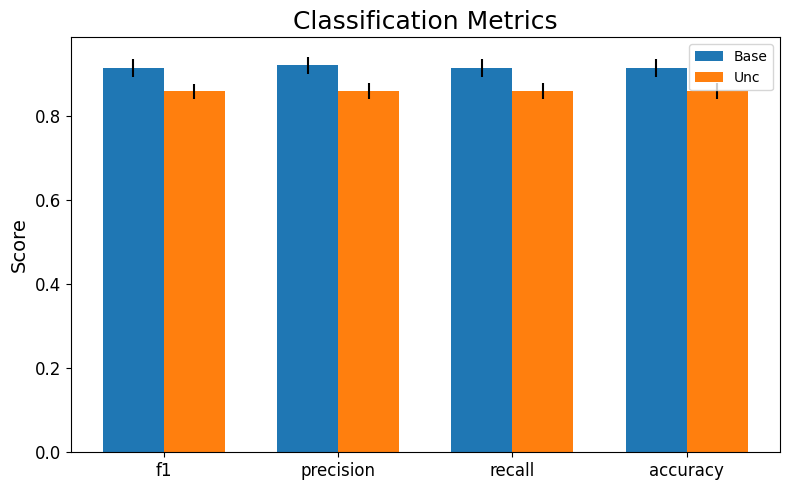

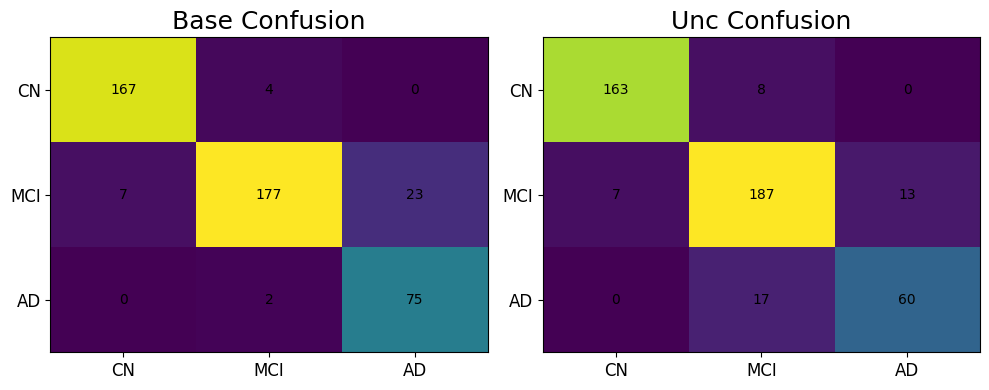


Head 'regression_adas' (Base):
  Valid points: 455
  True span:  8.9615, Pred span:  5.66542
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_adas' (Unc):
  Valid points: 455
  True span:  8.9615, Pred span:  5.32335
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


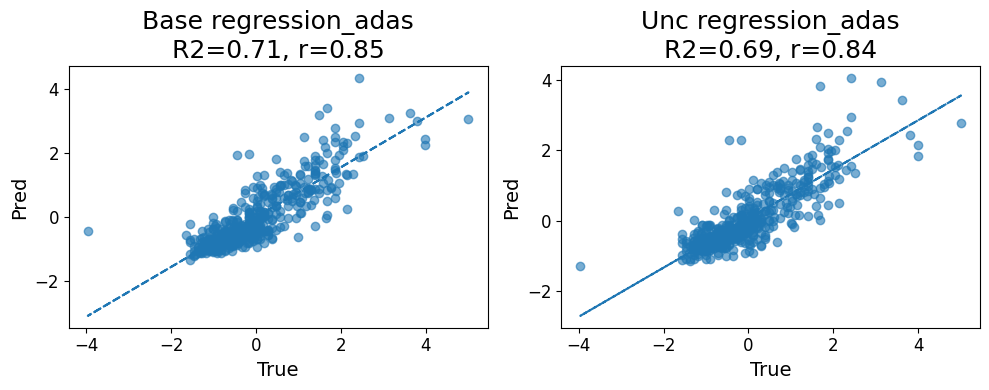


Head 'regression_mmse' (Base):
  Valid points: 455
  True span:  7.91115, Pred span:  6.43664
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_mmse' (Unc):
  Valid points: 455
  True span:  7.91115, Pred span:  5.85711
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


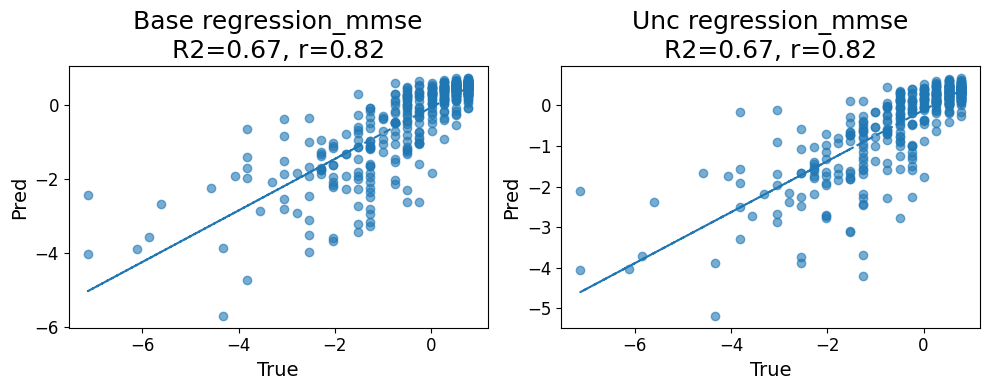


Head 'regression_faq' (Base):
  Valid points: 453
  True span:  4.12012, Pred span:  4.79427
  NaNs in true: 2, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_faq' (Unc):
  Valid points: 453
  True span:  4.12012, Pred span:  3.85108
  NaNs in true: 2, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


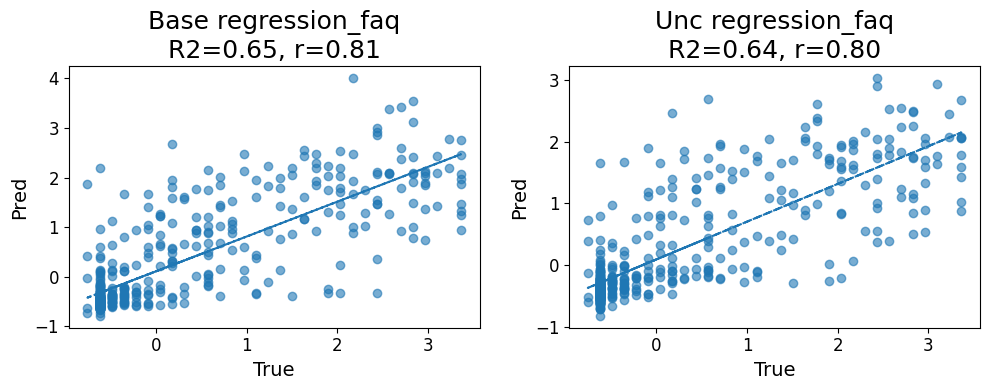


Head 'regression_cdrsb' (Base):
  Valid points: 455
  True span:  5.44419, Pred span:  4.86121
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_cdrsb' (Unc):
  Valid points: 455
  True span:  5.44419, Pred span:  5.00685
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


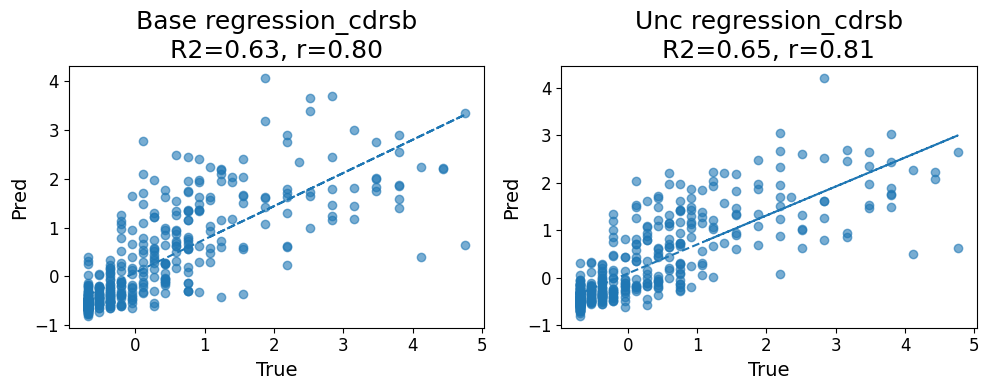

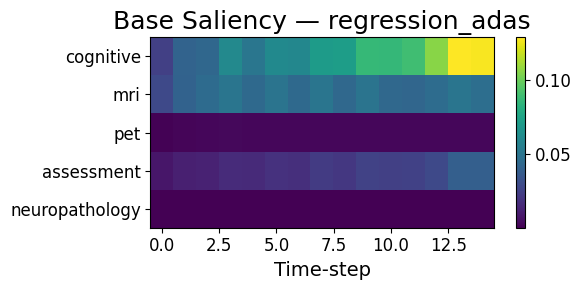

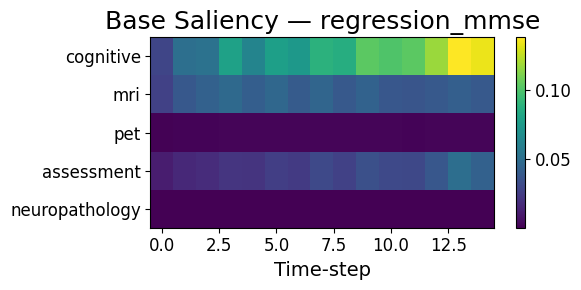

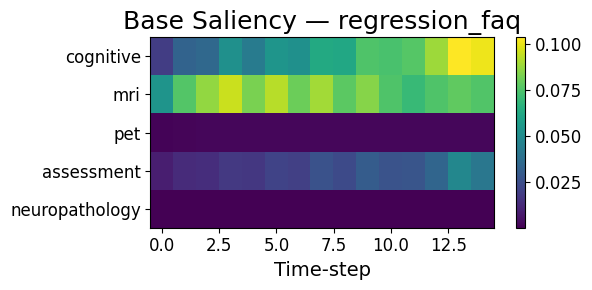

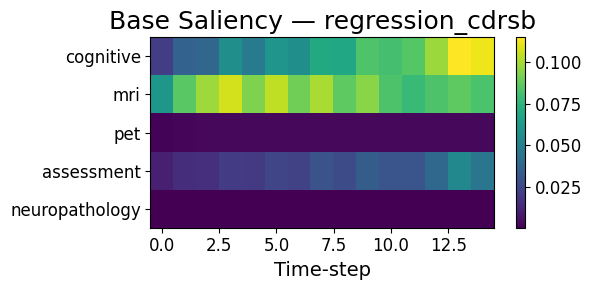

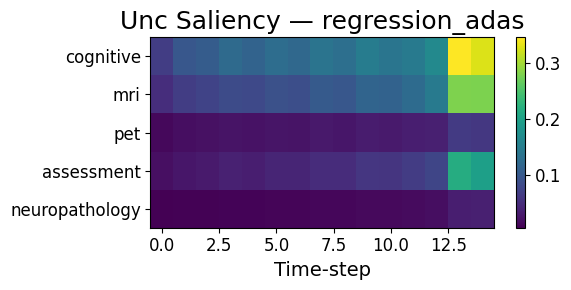

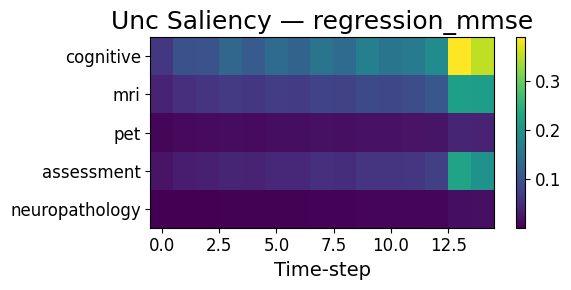

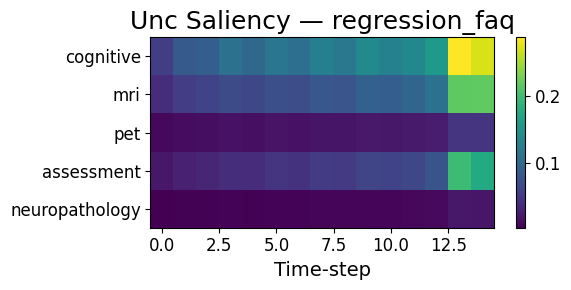

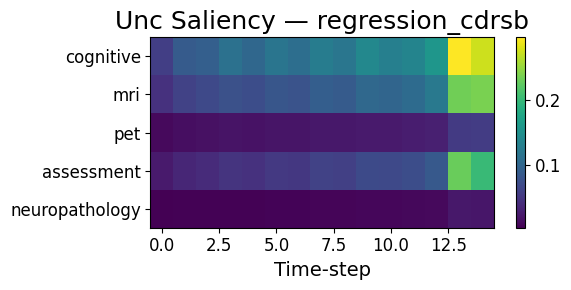

In [24]:
# — derive input & background shapes from ds_aligned — 
input_shapes = {
    k: ds_aligned[k].shape[1:]
    for k in ["cognitive", "mri", "pet", "assessment", "neuropathology"]
}
bg_shape = (ds_aligned["static"].shape[1],)

os.makedirs("logs", exist_ok=True)
metrics_file = "logs/fold_metrics_orig.csv"
first_seed = all_splits[0]["seed"]

def build_modality_pipeline_tv(input_shape, filters=64, kernel_size=4, lstm_units=64, name_prefix=""):
    """
    Build a temporal feature extractor for one longitudinal modality.

    Architecture
    ----------
    Input(shape = (T, F))
      → Conv1D(filters, kernel_size, padding='same', relu, L2)
      → MaxPooling1D(pool_size=2, strides=2, padding='same')
      → Dropout(0.10)
      → Bidirectional(LSTM(lstm_units, return_sequences=True, tanh, L2, dropout=0.10))
      → TimeDistributed(Dense(64, relu, L2))
      → TimeDistributed(Dropout(0.10))
      → Output(shape = (T', H)), where T' = ceil(T/2) due to pooling and H = features after TD Dense.

    Parameters
    ----------
    input_shape : tuple
        (T, F) where T is the number of time steps and F is the per-step feature count.
    filters : int, default=64
        Number of convolutional filters in the Conv1D layer.
    kernel_size : int, default=4
        Temporal kernel width for Conv1D.
    lstm_units : int, default=64
        Hidden size for each direction of the BiLSTM.
    name_prefix : str, default=""
        Prefix used to name layers/models for easier graph debugging and multi-modality disambiguation.

    Returns
    -------
    tf.keras.Model
        A Keras model that maps (batch, T, F) → (batch, T', 64) after TD Dense,
        suitable for later temporal fusion/concatenation.

    Notes
    -----
    - L2 regularization is applied to Conv1D, BiLSTM kernels, and the TD Dense layer.
    - `return_sequences=True` preserves the temporal dimension for downstream fusion.
    - The pooling halves the time resolution (≈ T/2); adjust if strict alignment with other streams is required.
    - Keep `name_prefix` unique per modality (e.g., "mri", "pet") to simplify checkpoint inspection.
    """
    inp = Input(shape=input_shape, name=f"{name_prefix}_input")
    x = Conv1D(filters, kernel_size, padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(0.01), name=f"{name_prefix}_conv")(inp)
    x = MaxPooling1D(2,2,padding='same', name=f"{name_prefix}_pool")(x)
    x = Dropout(0.10, name=f"{name_prefix}_drop1")(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, activation='tanh',
                           kernel_regularizer=regularizers.l2(0.01), dropout=0.10),
                      name=f"{name_prefix}_bilstm1")(x)
    x = TimeDistributed(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
                        name=f"{name_prefix}_td_dense1")(x)
    x = TimeDistributed(Dropout(0.10), name=f"{name_prefix}_td_drop1")(x)
    return Model(inputs=inp, outputs=x, name=f"{name_prefix}_pipeline_tv")

def build_background_network(bg_input_shape):
    """
    Build a feed-forward processing pipeline for static (non-temporal) background features.

    Architecture
    ----------
    Input(shape = (F,))
      → Dense(64, relu, L2 regularization)
      → Dropout(0.20)
      → Output: (batch, 64) feature vector

    Parameters
    ----------
    bg_input_shape : tuple
        Shape of the static background input excluding the batch dimension,
        e.g., (F,) where F is the number of static features.

    Returns
    -------
    tf.keras.Model
        A Keras model that maps (batch, F) → (batch, 64) latent representation
        for fusion with temporal modality outputs.

    Notes
    -----
    - L2 regularization is applied to the Dense layer to reduce overfitting.
    - Dropout of 20% is applied to promote generalization.
    - Intended for features that do not vary across time steps, such as demographics
      or baseline clinical measures.
    """
    inp = Input(shape=bg_input_shape, name="background_input")
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name="bg_fc1")(inp)
    x = Dropout(0.20, name="bg_drop1")(x)
    return Model(inputs=inp, outputs=x, name="background_pipeline")

def build_shared_fusion_block(x):
    """
    Build a shared dense + dropout block for fused modality features.

    This block applies a Dense layer with ReLU activation and L2 kernel regularization
    to the concatenated multimodal feature vector, followed by dropout to improve
    generalization. It is intended as the common transformation stage before branching
    into classification and regression heads.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor representing fused features from all modalities (and possibly static features).

    Returns
    -------
    tf.Tensor
        Transformed tensor after applying Dense + Dropout layers, ready for task-specific heads.

    Notes
    -----
    - Output dimensionality is fixed at 64 units to create a shared latent space.
    - Dropout rate is set to 20% to reduce overfitting.
    - Designed to be reused for both baseline and uncertainty-weighted models.
    """
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01),
              name="fusion_shared_fc1")(x)
    return Dropout(0.20, name="fusion_shared_drop1")(x)

def build_multitask_heads(f, num_classes=3):
    """
    Build task-specific output heads for joint classification and regression.

    The shared fused feature vector `f` is branched into:
    1. **Classification head** — Dense(32, relu, L2) → Dropout(0.20) → Dense(num_classes, softmax)
       Outputs class probabilities for diagnostic classification.
    2. **Regression heads** — Four separate branches for ADAS, MMSE, FAQ, and CDR-SB:
       Each: Dense(32, relu, L2) → Dropout(0.20) → Dense(1, linear)
       Outputs continuous predictions for each clinical score.

    Parameters
    ----------
    f : tf.Tensor
        Input tensor from the shared fusion block, shape (batch, features).
    num_classes : int, default=3
        Number of classification categories.

    Returns
    -------
    list of tf.Tensor
        [classification_output, adas_output, mmse_output, faq_output, cdrsb_output].

    Notes
    -----
    - L2 regularization is applied to all Dense layers to reduce overfitting.
    - Dropout rate is set to 20% for both classification and regression branches.
    - Regression outputs are linear activations to allow unbounded score prediction.
    """
    c = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name="cls_fc1")(f)
    c = Dropout(0.20, name="cls_drop1")(c)
    out_cls = Dense(num_classes, activation='softmax', name="classification")(c)
    regs = []
    for head in ["regression_adas","regression_mmse","regression_faq","regression_cdrsb"]:
        r = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name=f"{head}_fc1")(f)
        r = Dropout(0.20, name=f"{head}_drop1")(r)
        regs.append(Dense(1, activation='linear', name=head)(r))
    return [out_cls] + regs

def build_full_multimodal_model(input_shapes, bg_shape, num_classes=3):
    """
    Construct the complete multimodal CNN–BiLSTM model with static background integration
    and multitask outputs for classification and regression.

    Architecture
    ------------
    1. Per-modality temporal pipelines: 
       For each modality in `input_shapes`, a `build_modality_pipeline_tv` network 
       processes the time-series input into a sequence of latent features.
    2. Static background network:
       `build_background_network` encodes static (non-temporal) features into a latent vector.
    3. Temporal fusion:
       - The background vector is expanded and tiled along the time dimension to match 
         the sequence length of temporal modalities.
       - All modality sequences and the tiled background sequence are concatenated.
    4. Sequence-to-vector reduction:
       The last time step (`fused_last`) of the concatenated sequence is selected 
       as the aggregated feature representation.
    5. Shared fusion block:
       The reduced feature vector passes through `build_shared_fusion_block` 
       for transformation before branching.
    6. Multitask output heads:
       - One classification head (softmax over `num_classes`).
       - Four regression heads for ADAS, MMSE, FAQ, and CDR-SB.

    Parameters
    ----------
    input_shapes : dict
        Mapping from modality name → input shape tuple (time_steps, features).
    bg_shape : tuple
        Shape of static background features (features,).
    num_classes : int, default=3
        Number of classes for the classification output.

    Returns
    -------
    tf.keras.Model
        A compiled multimodal model with 1 classification output and 4 regression outputs.

    Notes
    -----
    - Background features are temporally broadcasted to align with sequential modalities.
    - The model can handle heterogeneous input modalities and integrates them at the sequence level.
    - Final outputs follow the order: [classification, regression_adas, regression_mmse, regression_faq, regression_cdrsb].
    """
    pipes = {k: build_modality_pipeline_tv(input_shapes[k], name_prefix=k) for k in input_shapes}
    bg_m   = build_background_network(bg_shape)
    inputs = [p.input for p in pipes.values()] + [bg_m.input]
    seqs   = [p.output for p in pipes.values()]
    bg_vec = bg_m.output
    T      = Lambda(lambda t: tf.shape(t)[1], name="get_T")(seqs[0])
    bg_seq = Lambda(lambda x: tf.expand_dims(x,1),                name="bg_expand")(bg_vec)
    bg_seq = Lambda(lambda args: tf.tile(args[0],[1,args[1],1]),   name="bg_tile")([bg_seq,T])
    fused_seq = Concatenate(name="fused_features")(seqs + [bg_seq])
    fused_last= Lambda(lambda t: t[:, -1, :], name="fused_last")(fused_seq)
    fused_feat= build_shared_fusion_block(fused_last)
    outputs   = build_multitask_heads(fused_feat, num_classes)
    return Model(inputs=inputs, outputs=outputs, name="Full_Multimodal_Model_Slim")

class MultiTaskUncertaintyModel(tf.keras.Model):
    def __init__(self, base_model, log_vars, clamp_bounds=None):
        """
        Initialize the MultiTaskUncertaintyModel.

        Parameters
        ----------
        base_model : tf.keras.Model
        The underlying multitask model (classification + regression heads) to be trained.
        log_vars : dict
        Dictionary mapping output head names to `tf.Variable` objects representing
        log(σ²) for homoscedastic uncertainty weighting.
        clamp_bounds : dict, optional
        Optional mapping {head_name: (lower_bound, upper_bound)} for clamping `log_vars`
        during training to prevent extreme variance values. Defaults to {}.

        Attributes
        ----------
        cls_acc : tf.keras.metrics.SparseCategoricalAccuracy
        Tracks classification accuracy for the diagnostic task.
        adas_mae : tf.keras.metrics.MeanAbsoluteError
        Tracks MAE for the ADAS regression head.
        mmse_mae : tf.keras.metrics.MeanAbsoluteError
        Tracks MAE for the MMSE regression head.
        faq_mae : tf.keras.metrics.MeanAbsoluteError
        Tracks MAE for the FAQ regression head.
        cdrsb_mae : tf.keras.metrics.MeanAbsoluteError
        Tracks MAE for the CDR-SB regression head.

        Notes
        -----
        - `log_vars` parameters are trainable and jointly optimized with `base_model` weights.
        - Supports optional clamping of `log_vars` to stabilize uncertainty estimation.
        """
        super().__init__()
        self.base_model    = base_model
        self.log_vars      = log_vars
        self.clamp_bounds  = clamp_bounds or {}
        self.cls_acc       = tf.keras.metrics.SparseCategoricalAccuracy(name="cls_acc")
        self.adas_mae      = tf.keras.metrics.MeanAbsoluteError(name="adas_mae")
        self.mmse_mae      = tf.keras.metrics.MeanAbsoluteError(name="mmse_mae")
        self.faq_mae       = tf.keras.metrics.MeanAbsoluteError(name="faq_mae")
        self.cdrsb_mae     = tf.keras.metrics.MeanAbsoluteError(name="cdrsb_mae")

    @property
    def metrics(self):
        """List of tracked metrics for classification and all regression heads."""
        return [self.cls_acc, self.adas_mae, self.mmse_mae, self.faq_mae, self.cdrsb_mae]

    def compile(self, optimizer, run_eagerly=False):
        """Configure optimizer and set loss functions for classification (CE) and regression (MSE)."""
        super().compile(optimizer=optimizer, run_eagerly=run_eagerly)
        self.loss_cls = tf.keras.losses.SparseCategoricalCrossentropy()
        self.loss_mse = tf.keras.losses.MeanSquaredError()

    def call(self, inputs, training=False):
        """Forward pass delegating to the underlying base model."""
        return self.base_model(inputs, training=training)

    def train_step(self, data):
        """
        Custom training step with homoscedastic uncertainty weighting.

        Computes classification (CE) and regression (MSE) losses, weights them by
        learned task variances (log_vars), applies optional clamping, sums into a
        total loss, updates model and log_var parameters, and tracks all metrics.
        """
        x, y = data[:2]
        with tf.GradientTape() as tape:
            preds = self.base_model(x, training=True)
            losses = {
                'classification':   self.loss_cls(y[0], preds[0]),
                'regression_adas':  self.loss_mse(y[1], preds[1]),
                'regression_mmse':  self.loss_mse(y[2], preds[2]),
                'regression_faq':   self.loss_mse(y[3], preds[3]),
                'regression_cdrsb': self.loss_mse(y[4], preds[4]),
            }
            total_loss = 0.0
            for name, L in losses.items():
                # s = log(sigma^2)
                s = self.log_vars[name]
                # optional clamping of s
                if name in self.clamp_bounds:
                    lo, hi = self.clamp_bounds[name]
                    s = tf.clip_by_value(s, lo, hi)
                precision = tf.exp(-s)  # = 1 / sigma^2

                if name == 'classification':
                    # classification: (1/sigma^2) * CE + log(sigma)
                    total_loss += precision * L + 0.5 * s
                else:
                    # regression: (1/(2 sigma^2)) * MSE + log(sigma)
                    total_loss += 0.5 * precision * L + 0.5 * s

        # update weights
        vars_to_train = self.base_model.trainable_variables + list(self.log_vars.values())
        grads = tape.gradient(total_loss, vars_to_train)
        self.optimizer.apply_gradients(zip(grads, vars_to_train))

        # update metrics
        for m, pred, true in zip(self.metrics, preds, y):
            m.update_state(true, pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data[:2]
        preds = self.base_model(x, training=False)
        for m, pred, true in zip(self.metrics, preds, y):
            m.update_state(true, pred)
        return {m.name: m.result() for m in self.metrics}

def make_split(rids, ds_aligned, diag_df, scaler_reg):
    """
    Extract and preprocess inputs and targets for a given subject split.

    Parameters
    ----------
    rids : list of str
        Subject IDs for the split.
    ds_aligned : xr.Dataset
        Aligned multimodal dataset containing all modalities and regression targets.
    diag_df : pd.DataFrame
        DataFrame with subject diagnoses, including 'DIAGNOSIS_ENC'.
    scaler_reg : sklearn StandardScaler
        Fitted scaler for regression features.

    Returns
    -------
    Xs : list of np.ndarray
        List of modality arrays in the order:
        [cognitive, mri, pet, assessment, neuropathology, static].
    y : dict
        Dictionary mapping task names to target arrays:
        {'classification', 'regression_adas', 'regression_mmse',
         'regression_faq', 'regression_cdrsb'}.
        Regression targets are scaled and taken from the last time step.
    R : np.ndarray
        Original (unscaled) regression time-series array of shape (n, T, 4).

    Notes
    -----
    - NaNs and infinite values are replaced with zeros in both inputs and targets.
    - Regression values are transformed using the provided scaler before extraction.
    """
    ds = ds_aligned.sel(subject=rids)
    R  = ds["regression"].values # (n, T, 4)
    flat = R.reshape(-1, R.shape[-1])
    flat_s = scaler_reg.transform(flat)
    R_s = flat_s.reshape(R.shape)
    y = {
        "classification":   diag_df.set_index("RID").loc[rids]["DIAGNOSIS_ENC"].values,
        "regression_adas":  R_s[:, -1, 0][:, None],
        "regression_mmse":  R_s[:, -1, 1][:, None],
        "regression_faq":   R_s[:, -1, 2][:, None],
        "regression_cdrsb": R_s[:, -1, 3][:, None],
    }
    Xs = [np.nan_to_num(ds[v].values, nan=0., posinf=0., neginf=0.)
          for v in ["cognitive","mri","pet","assessment","neuropathology","static"]]
    for k in y:
        y[k] = np.nan_to_num(y[k], nan=0., posinf=0., neginf=0.)
    return Xs, y, R

def compute_saliency_ts(model, Xs, mod_idx, out_idx):
    """
    Compute average temporal saliency for a given modality and output head.

    Uses gradient-based saliency: the absolute gradient of the summed output
    with respect to the input modality is computed and averaged over all samples.

    Parameters
    ----------
    model : tf.keras.Model
        Trained multitask model.
    Xs : list of np.ndarray
        List of modality input arrays in the order used by the model.
    mod_idx : int
        Index of the modality in Xs to compute saliency for.
    out_idx : int
        Index of the model output to target (0 = classification, 1+ = regression heads).

    Returns
    -------
    np.ndarray
        1D array of mean saliency values per time step for the selected modality.

    Notes
    -----
    - The output is averaged across all features of the modality.
    - Larger values indicate higher influence of that time step on the chosen output.
    """
    inputs = [tf.constant(x, dtype=tf.float32) for x in Xs]
    with tf.GradientTape() as tape:
        tape.watch(inputs[mod_idx])
        out  = model(inputs, training=False)[out_idx]
        loss = tf.reduce_sum(out)
    grads = tape.gradient(loss, inputs[mod_idx])
    sal   = tf.reduce_sum(tf.abs(grads), axis=-1).numpy()
    return sal.mean(axis=0)

# — train across splits, collect metrics & save fold‐0 data for plotting —
results   = []
out_order = [
    'classification',
    'regression_adas','regression_mmse',
    'regression_faq','regression_cdrsb'
]
plot_seed = first_seed

for split in all_splits:
    seed       = split["seed"]
    scaler_reg = split["regression_scaler"]

    # prepare data
    X_tr, y_tr, _   = make_split(split["train_ids"], ds_aligned, subject_diag_common, scaler_reg)
    X_val, y_val, _ = make_split(split["val_ids"],   ds_aligned, subject_diag_common, scaler_reg)
    X_te,  y_te, R_te=make_split(split["test_ids"],  ds_aligned, subject_diag_common, scaler_reg)

     # save the raw test data and scaler for your chosen plotting fold
    if seed == plot_seed:
        X_te_plot, y_te_plot, R_te_plot, scaler_plot = X_te, y_te, R_te, scaler_reg

    # class weights
    y_cls   = y_tr["classification"].flatten()
    classes = np.unique(y_cls)
    cw      = compute_class_weight('balanced', classes=classes, y=y_cls)
    sw_cls  = np.vectorize(dict(zip(classes, cw)).get)(y_cls)
    sw_tr_list = [sw_cls] + [np.ones_like(sw_cls)]*4

    # callbacks
    epoch_logger = LambdaCallback(on_epoch_begin=lambda ep, logs: print(f"[Fold {seed}] Epoch {ep+1}"))
    es           = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    cb_base      = [es, epoch_logger, CSVLogger(f"logs/base_split_{seed}.csv")]
    cb_unc       = [es, epoch_logger, CSVLogger(f"logs/unc_split_{seed}.csv")]

    y_tr_list  = [y_tr[n] for n in out_order]
    y_val_list = [y_val[n] for n in out_order]

    # — Base model (100 epochs, verbose=1) —
    base = build_full_multimodal_model(input_shapes, bg_shape, num_classes=len(classes))
    base.compile(
        optimizer=Adam(1e-4, clipnorm=1.0),
        loss=['sparse_categorical_crossentropy'] + ['mse']*4
    )
    base.fit(
        X_tr, y_tr_list,
        sample_weight=sw_tr_list,
        validation_data=(X_val, y_val_list),
        epochs=100,
        batch_size=32,
        callbacks=cb_base,
        verbose=1
    )
    preds_b = base.predict(X_te, verbose=0)
    
    if seed == plot_seed:
        preds_b_plot = preds_b
        base_plot    = base

    # classification metrics (base)
    y_pred_cls_b = np.argmax(preds_b[0], axis=1)
    cls_metrics_b = {
        "f1":        f1_score(y_te["classification"], y_pred_cls_b, average="weighted"),
        "recall":    recall_score(y_te["classification"], y_pred_cls_b, average="weighted"),
        "precision": precision_score(y_te["classification"], y_pred_cls_b, average="weighted"),
        "accuracy":  accuracy_score(y_te["classification"], y_pred_cls_b)
    }

    # regression metrics (base) with correct indexing
    reg_metrics_b = {}
    for i, name in enumerate(out_order[1:], start=0):  # i=0..3
        yt = R_te[:, -1, i]
        pred_orig = scaler_reg.inverse_transform(
            np.concatenate([preds_b[j] for j in range(1,5)], axis=-1)
        )[:, i]

        if seed == plot_seed:
            print(f"[DEBUG fold {seed} head {name}] "
                  f"yt nonfinite={(~np.isfinite(yt)).sum()}, "
                  f"pred nonfinite={(~np.isfinite(pred_orig)).sum()}")

        mask = np.isfinite(yt) & np.isfinite(pred_orig)
        if mask.sum() < 2:
            vals = {"r2": np.nan, "pearson": np.nan, "mae": np.nan, "rmse": np.nan}
        else:
            yt_f, p_f = yt[mask], pred_orig[mask]
            vals = {
                "r2":      r2_score(yt_f, p_f),
                "pearson": pearsonr(yt_f, p_f)[0],
                "mae":     mean_absolute_error(yt_f, p_f),
                "rmse":    np.sqrt(mean_squared_error(yt_f, p_f))
            }
        reg_metrics_b[name] = vals

    # — Uncertainty model (100 epochs, verbose=1) —
    log_vars = {n: tf.Variable(0., trainable=True, name=f"logvar_{n}_{seed}") for n in out_order}
    unc = MultiTaskUncertaintyModel(
        build_full_multimodal_model(input_shapes, bg_shape, num_classes=len(classes)),
        log_vars
    )
    unc.compile(optimizer=Adam(1e-4, clipnorm=1.0), run_eagerly=True)
    unc.fit(
        X_tr, y_tr_list,
        sample_weight=sw_tr_list,
        validation_data=(X_val, y_val_list),
        epochs=100,
        batch_size=32,
        callbacks=cb_unc,
        verbose=1
    )
    preds_u = unc.predict(X_te, verbose=0)
    
    if seed == plot_seed:
        preds_u_plot = preds_u
        unc_plot     = unc
    # classification metrics (unc)
    y_pred_cls_u = np.argmax(preds_u[0], axis=1)
    cls_metrics_u = {
        "f1":        f1_score(y_te["classification"], y_pred_cls_u, average="weighted"),
        "recall":    recall_score(y_te["classification"], y_pred_cls_u, average="weighted"),
        "precision": precision_score(y_te["classification"], y_pred_cls_u, average="weighted"),
        "accuracy":  accuracy_score(y_te["classification"], y_pred_cls_u)
    }

    # regression metrics (unc) with same fix
    reg_metrics_u = {}
    for i, name in enumerate(out_order[1:], start=0):  # i=0..3
        yt = R_te[:, -1, i]
        pred_orig = scaler_reg.inverse_transform(
            np.concatenate([preds_u[j] for j in range(1,5)], axis=-1)
        )[:, i]

        if seed == plot_seed:
            print(f"[DEBUG fold {seed} UNC head {name}] "
                  f"yt nonfinite={(~np.isfinite(yt)).sum()}, "
                  f"pred nonfinite={(~np.isfinite(pred_orig)).sum()}")

        mask = np.isfinite(yt) & np.isfinite(pred_orig)
        if mask.sum() < 2:
            vals = {"r2": np.nan, "pearson": np.nan, "mae": np.nan, "rmse": np.nan}
        else:
            yt_f, p_f = yt[mask], pred_orig[mask]
            vals = {
                "r2":      r2_score(yt_f, p_f),
                "pearson": pearsonr(yt_f, p_f)[0],
                "mae":     mean_absolute_error(yt_f, p_f),
                "rmse":    np.sqrt(mean_squared_error(yt_f, p_f))
            }
        reg_metrics_u[name] = vals

    # collect & log all metrics
    row = {"split": seed}
    row.update({f"base_cls_{k}": v for k,v in cls_metrics_b.items()})
    row.update({f"unc_cls_{k}":  v for k,v in cls_metrics_u.items()})
    for nm in out_order[1:]:
        for metric,val in reg_metrics_b[nm].items(): row[f"base_{nm}_{metric}"] = val
        for metric,val in reg_metrics_u[nm].items(): row[f"unc_{nm}_{metric}"]  = val

    results.append(row)
    mode = 'w' if seed == first_seed else 'a'
    with open(metrics_file, mode, newline='') as f:
        writer = csv.DictWriter(f, fieldnames=list(row.keys()))
        if mode == 'w':
            writer.writeheader()
        writer.writerow(row)

# — summary across splits & plotting —
df = pd.DataFrame(results).set_index("split")
summary = df.describe().loc[['mean','std']]
print("Aggregate metrics (mean, std):\n", summary)

# — plot classification comparison —
cls_mets = ['f1','precision','recall','accuracy']
x = np.arange(len(cls_mets))
width = 0.35
base_means = [summary.loc['mean', f"base_cls_{m}"] for m in cls_mets]
base_stds  = [summary.loc['std',  f"base_cls_{m}"] for m in cls_mets]
unc_means  = [summary.loc['mean', f"unc_cls_{m}"]  for m in cls_mets]
unc_stds   = [summary.loc['std',  f"unc_cls_{m}"]  for m in cls_mets]
plt.figure(figsize=(8,5))
plt.bar(x - width/2, base_means,  width, yerr=base_stds,  label="Base")
plt.bar(x + width/2, unc_means,   width, yerr=unc_stds,   label="Unc")
plt.xticks(x, cls_mets)
plt.ylabel("Score")
plt.title("Classification Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# — confusion matrices for fold 0 —
y_true = y_te_plot["classification"]
y_pred_b0 = np.argmax(preds_b_plot[0], axis=1)
y_pred_u0 = np.argmax(preds_u_plot[0], axis=1)
cm_b0 = confusion_matrix(y_true, y_pred_b0)
cm_u0 = confusion_matrix(y_true, y_pred_u0)
fig, axes = plt.subplots(1,2,figsize=(10,4))
for ax, cm, title in zip(axes, [cm_b0, cm_u0], ["Base","Unc"]):
    ax.imshow(cm, interpolation='nearest', aspect='auto')
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha='center', va='center')
    ax.set_xticks([0,1,2]); ax.set_xticklabels(["CN","MCI","AD"])
    ax.set_yticks([0,1,2]); ax.set_yticklabels(["CN","MCI","AD"])
    ax.set_title(f"{title} Confusion")
fig.tight_layout()
plt.show()

# — regression true vs. pred for fold 0 (with diagnostic guards) —
reg_heads = out_order[1:]
true_vals = R_te_plot[:, -1, :]
preds_b_scaled = np.concatenate(preds_b_plot[1:], axis=-1)
preds_u_scaled = np.concatenate(preds_u_plot[1:], axis=-1)
preds_b_orig = scaler_plot.inverse_transform(preds_b_scaled)
preds_u_orig = scaler_plot.inverse_transform(preds_u_scaled)

for i, head in enumerate(reg_heads):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, pred, title in zip(
        axes,
        [preds_b_orig[:, i], preds_u_orig[:, i]],
        ["Base", "Unc"]
    ):
        x = true_vals[:, i]
        y = pred

        # 1) Mask out any NaNs/Infs
        mask = np.isfinite(x) & np.isfinite(y)
        xv, yv = x[mask], y[mask]

        # 2) Print diagnostics
        print(f"\nHead {head!r} ({title}):")
        print(f"  Valid points: {len(xv)}")
        print(f"  True span:  {np.ptp(xv):.6g}, Pred span:  {np.ptp(yv):.6g}")
        print(f"  NaNs in true: {np.isnan(x).sum()}, Infs in true: {np.isinf(x).sum()}")
        print(f"  NaNs in pred: {np.isnan(y).sum()}, Infs in pred: {np.isinf(y).sum()}")

        # 3) Scatter all valid points
        ax.scatter(xv, yv, alpha=0.6)

        # 4) Only fit a line if we have more or equal 2 points and nonzero span
        if len(xv) < 2 or np.ptp(xv) < 1e-8 or np.ptp(yv) < 1e-8:
            print("Skipping line fit (too few points or zero variance)")
            m, b = np.nan, np.nan
        else:
            try:
                m, b = np.polyfit(xv, yv, 1)
            except np.linalg.LinAlgError:
                print("SVD did not converge; skipping line fit")
                m, b = np.nan, np.nan

        # 5) Plot the line if it’s valid
        if np.isfinite(m) and np.isfinite(b):
            ax.plot(xv, m * xv + b, "--")

        # 6) Compute and display R squared and Pearson r on the title
        if len(xv) >= 2:
            r2 = r2_score(xv, yv)
            r = pearsonr(xv, yv)[0]
        else:
            r2, r = np.nan, np.nan

        ax.set_xlabel("True")
        ax.set_ylabel("Pred")
        ax.set_title(f"{title} {head}\nR2={r2:.2f}, r={r:.2f}")

    fig.tight_layout()
    plt.show()

# — saliency heatmaps for regression heads, fold 0 —
modalities = list(input_shapes.keys())
for model, title in [(base_plot,"Base"), (unc_plot,"Unc")]:
    for idx, head in enumerate(reg_heads, start=1):
        sal_map = np.stack([
            compute_saliency_ts(model, X_te_plot, mi, idx)
            for mi in range(len(modalities))
        ])
        plt.figure(figsize=(6,3))
        plt.imshow(sal_map, aspect='auto')
        plt.yticks(range(len(modalities)), modalities)
        plt.xlabel("Time-step"); plt.title(f"{title} Saliency — {head}")
        plt.colorbar(); plt.tight_layout(); plt.show()

## <center> Step 22: Regression Metrics Aggregation and Summary

This block loads the per-fold results from logs/fold_metrics_orig.csv and summarizes regression performance across all cross-validation splits for both the base and uncertainty-weighted models. It focuses on four regression heads (ADAS, MMSE, FAQ, CDRSB) and four key metrics (R², Pearson correlation, RMSE, MAE). The code constructs a MultiIndex for organized access, computes mean and standard deviation for each metric–head combination, and stores them in a structured DataFrame. Results are printed in a readable mean ± std format for each head, and the complete summary table is also displayed for direct comparison between the two models. This summary enables quick inspection of whether uncertainty weighting improved regression performance across tasks.

In [25]:
# 1) Load the metrics CSV (ensure the path is correct)
df = pd.read_csv("logs/fold_metrics_orig.csv", index_col="split")

# 2) Define your heads and stats of interest
reg_heads = ["regression_adas", "regression_mmse", "regression_faq", "regression_cdrsb"]
stats     = ["r2", "pearson", "rmse", "mae"]

# 3) Build a MultiIndex to organize the summary
idx = pd.MultiIndex.from_product([reg_heads, stats], names=("head", "stat"))

# 4) Collect mean/std for both Base and Unc
data = []
for head in reg_heads:
    for stat in stats:
        base_col = f"base_{head}_{stat}"
        unc_col  = f"unc_{head}_{stat}"
        data.append([
            df[base_col].mean(),
            df[base_col].std(),
            df[unc_col].mean(),
            df[unc_col].std()
        ])

# 5) Create a summary DataFrame
summary_df = pd.DataFrame(
    data,
    index=idx,
    columns=["base_mean", "base_std", "unc_mean", "unc_std"]
)

# 6) Display
print("\nRegression metrics summary (mean ± std):\n")
for head in reg_heads:
    sub = summary_df.loc[head]
    print(f"{head}:")
    print(sub.apply(lambda row: f"  {row.name}: Base = {row['base_mean']:.3f}±{row['base_std']:.3f}, "
                               f"Unc = {row['unc_mean']:.3f}±{row['unc_std']:.3f}", axis=1))
    print()

# Optionally, to see it as a clean table:
print("Full summary table:\n", summary_df)


Regression metrics summary (mean ± std):

regression_adas:
stat
r2                r2: Base = 0.632±0.051, Unc = 0.627±0.054
pearson      pearson: Base = 0.798±0.032, Unc = 0.793±0.034
rmse            rmse: Base = 0.699±0.070, Unc = 0.705±0.073
mae              mae: Base = 0.454±0.024, Unc = 0.464±0.024
dtype: object

regression_mmse:
stat
r2                r2: Base = 0.667±0.040, Unc = 0.651±0.051
pearson      pearson: Base = 0.822±0.021, Unc = 0.812±0.027
rmse            rmse: Base = 0.787±0.084, Unc = 0.805±0.097
mae              mae: Base = 0.495±0.033, Unc = 0.513±0.034
dtype: object

regression_faq:
stat
r2                r2: Base = 0.632±0.029, Unc = 0.627±0.023
pearson      pearson: Base = 0.797±0.016, Unc = 0.795±0.014
rmse            rmse: Base = 0.746±0.034, Unc = 0.752±0.027
mae              mae: Base = 0.488±0.022, Unc = 0.516±0.017
dtype: object

regression_cdrsb:
stat
r2                r2: Base = 0.588±0.038, Unc = 0.586±0.038
pearson      pearson: Base = 0.771±0.025, Un

## <center> Step 23: Paired t-Test Comparison Between Base and Uncertainty Models
This block statistically compares performance metrics between the baseline and uncertainty-weighted models using paired t-tests across cross-validation folds. It loads fold-wise results from logs/fold_metrics_orig.csv and evaluates both classification metrics (F1, recall, precision, accuracy) and regression metrics (R squared, Pearson correlation, MAE, RMSE) for each of the four regression heads (ADAS, MMSE, FAQ, CDRSB). For each metric, it computes the mean score for both models, the paired t-test statistic, and the corresponding p-value, where positive t-values indicate higher uncertainty-model performance. The results are sorted by p-value to highlight the most statistically significant differences, and the complete table is saved to logs/paired_ttest_results.csv for further inspection.

In [26]:
# Load fold-wise results
df = pd.read_csv("logs/fold_metrics_orig.csv")

# List of metric targets to compare
metrics = [
    "cls_f1", "cls_recall", "cls_precision", "cls_accuracy",
    "regression_adas_r2", "regression_adas_pearson", "regression_adas_mae", "regression_adas_rmse",
    "regression_mmse_r2", "regression_mmse_pearson", "regression_mmse_mae", "regression_mmse_rmse",
    "regression_faq_r2", "regression_faq_pearson", "regression_faq_mae", "regression_faq_rmse",
    "regression_cdrsb_r2", "regression_cdrsb_pearson", "regression_cdrsb_mae", "regression_cdrsb_rmse"
]

# Paired t-tests between base and unc models
results = []

for m in metrics:
    base_col = f"base_{m}"
    unc_col = f"unc_{m}"
    
    t_stat, p_val = ttest_rel(df[unc_col], df[base_col]) # note: unc - base
    mean_base = df[base_col].mean()
    mean_unc  = df[unc_col].mean()
    
    results.append({
        "metric": m,
        "baseline_mean": mean_base,
        "uncertainty_mean": mean_unc,
        "t_statistic": t_stat,
        "p_value": p_val
    })

# Display results as DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="p_value")
results_df.to_csv("logs/paired_ttest_results.csv", index=False)

## <center> Step 24: Post-hoc Paired Statistical Analysis with Effect Sizes and Confidence Intervals

This block performs a post-hoc statistical comparison between the baseline and uncertainty-weighted models for all classification and regression metrics across cross-validation folds. Using paired differences (unc − base), it calculates:

Mean values for both models and the mean difference.

Paired t-tests with associated t-statistics, p-values, and degrees of freedom.

Cohen’s d (dₓ) for paired samples to quantify effect size.

95% confidence intervals for the mean difference using the Student’s t distribution.

The analysis covers classification metrics (F1, recall, precision, accuracy) and regression metrics (R squared, Pearson correlation, MAE, RMSE) for all four regression heads (ADAS, MMSE, FAQ, CDRSB). Results are sorted by p-value to highlight the most statistically significant differences, then saved to paired_stats_with_d_and_ci_orig.csv` for further reporting. 

In [27]:
# Load
csv_path = r"C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics_orig.csv"
df = pd.read_csv(csv_path)

# Metrics to compare (unc - base)
metrics = [
    "cls_f1", "cls_recall", "cls_precision", "cls_accuracy",
    "regression_adas_r2", "regression_adas_pearson", "regression_adas_mae", "regression_adas_rmse",
    "regression_mmse_r2", "regression_mmse_pearson", "regression_mmse_mae", "regression_mmse_rmse",
    "regression_faq_r2", "regression_faq_pearson", "regression_faq_mae", "regression_faq_rmse",
    "regression_cdrsb_r2", "regression_cdrsb_pearson", "regression_cdrsb_mae", "regression_cdrsb_rmse"
]

rows = []
for m in metrics:
    base_col = f"base_{m}"
    unc_col  = f"unc_{m}"
    if base_col not in df.columns or unc_col not in df.columns:
        continue

    # paired differences: unc - base
    d = df[unc_col].to_numpy() - df[base_col].to_numpy()
    n = d.size

    mean_base = float(np.nanmean(df[base_col]))
    mean_unc  = float(np.nanmean(df[unc_col]))
    mdiff     = float(np.nanmean(d))

    # SD of differences with ddof=1; guard n<2
    sd = float(np.nanstd(d, ddof=1)) if n >= 2 else np.nan
    se = sd / np.sqrt(n) if (n >= 2 and np.isfinite(sd)) else np.nan

    # paired t-test (will yield nan if n<2 or zero variance)
    t_stat, p_val = ttest_rel(df[unc_col], df[base_col], nan_policy="omit")
    dfree = int(n - 1) if n >= 1 else 0

    # Cohen's d for paired design (d_z): uses SD of differences
    d_z = mdiff / sd if (sd is not np.nan and np.isfinite(sd) and sd > 0) else np.nan

    # 95% CI for the mean difference using Student-t critical value
    if dfree > 0 and np.isfinite(se):
        tcrit = float(student_t.ppf(0.975, dfree))
        ci_low  = mdiff - tcrit * se
        ci_high = mdiff + tcrit * se
    else:
        ci_low = np.nan
        ci_high = np.nan

    rows.append({
        "metric": m,
        "baseline_mean": mean_base,
        "uncertainty_mean": mean_unc,
        "mean_diff_unc_minus_base": mdiff,
        "t_stat": float(t_stat) if np.isfinite(t_stat) else np.nan,
        "df": dfree,
        "p_value": float(p_val) if np.isfinite(p_val) else np.nan,
        "cohens_dz": d_z,
        "ci95_low_mean_diff": ci_low,
        "ci95_high_mean_diff": ci_high
    })

out = pd.DataFrame(rows).sort_values("p_value", na_position="last")
out_path = csv_path.replace("fold_metrics_orig.csv", "paired_stats_with_d_and_ci_orig.csv")
out.to_csv(out_path, index=False)
print("Saved:", out_path)
out.head(10)

Saved: C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\paired_stats_with_d_and_ci_orig.csv


,metric,baseline_mean,uncertainty_mean,mean_diff_unc_minus_base,t_stat,df,p_value,cohens_dz,ci95_low_mean_diff,ci95_high_mean_diff
2,cls_precision,0.921335,0.860038,-0.061297,-8.222000,9,0.000018,-2.600025,-0.078162,-0.044432
0,cls_f1,0.916141,0.859398,-0.056743,-7.029217,9,0.000061,-2.222834,-0.075004,-0.038482
1,cls_recall,0.915824,0.860440,-0.055385,-6.902455,9,0.000070,-2.182748,-0.073536,-0.037233
3,cls_accuracy,0.915824,0.860440,-0.055385,-6.902455,9,0.000070,-2.182748,-0.073536,-0.037233
10,regression_mmse_mae,0.494721,0.513166,0.018445,4.996287,9,0.000743,1.579965,0.010094,0.026796
14,regression_faq_mae,0.487845,0.516433,0.028587,3.776857,9,0.004370,1.194347,0.011465,0.045710
18,regression_cdrsb_mae,0.466423,0.482907,0.016484,3.205796,9,0.010731,1.013762,0.004852,0.028116
9,regression_mmse_pearson,0.821803,0.812477,-0.009326,-2.286997,9,0.048010,-0.723212,-0.018551,-0.000101
8,regression_mmse_r2,0.666860,0.651451,-0.015409,-2.134604,9,0.061559,-0.675021,-0.031738,0.000921
11,regression_mmse_rmse,0.787108,0.804779,0.017671,2.058934,9,0.069600,0.651092,-0.001744,0.037087


## <center> Step 25: Saliency-Based Fidelity Deletion Curve (Classification)

This block evaluates attribution fidelity by progressively masking the most salient (modality, timestep) inputs and measuring the drop in classification accuracy. For each time-varying modality, it computes saliency via absolute input gradients of the classification head (out_idx=0) using compute_saliency_ts, ranks all (modality, timestep) positions globally, and then zeroes out the top-k% positions across modalities (leaving static features unchanged). It runs this masking at percentages [0, 10, 20, 50, 80, 100], recomputes predictions, and records accuracy to form a deletion curve. The resulting plot compares the Base vs Uncertainty models: steeper accuracy declines as masking increases indicate higher attribution fidelity (the model relied on those salient inputs), while flatter curves suggest lower reliance or more robustness to the masked regions.

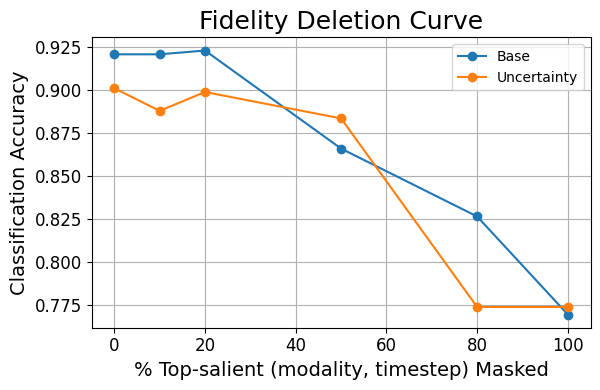

In [28]:
def compute_deletion_curve(model, X_list, y_true_cls, modalities_tv, mask_percents=[0, 10, 20, 50, 80, 100]):
    """
    - X_list: [cog, mri, pet, assess, neuro, static]
    - y_true_cls: array of true class labels, shape (n_samples,)
    - modalities_tv: list of 5 time-varying modality names
    """
    T = X_list[0].shape[1]
    sal = np.zeros((len(modalities_tv), T))

    for m in range(len(modalities_tv)):
        sal[m] = compute_saliency_ts(
            model=model,
            Xs=X_list,
            mod_idx=m,
            out_idx=0  # classification output index
        )

    flat_idx = np.argsort(sal.flatten())[::-1]
    N = flat_idx.size

    curve = {}
    for p in mask_percents:
        k = int(N * p / 100)
        mask_flat = np.zeros(N, dtype=bool)
        mask_flat[flat_idx[:k]] = True
        mask = mask_flat.reshape(sal.shape)

        X_masked = []
        for m, Xm in enumerate(X_list):
            Xm2 = Xm.copy()
            if m < len(modalities_tv):
                for t in range(T):
                    if mask[m, t]:
                        Xm2[:, t, :] = 0
            X_masked.append(Xm2)

        probs = model.predict(X_masked, batch_size=32, verbose=0)[0]
        preds = np.argmax(probs, axis=1)
        acc = (preds == y_true_cls).mean()
        curve[p] = acc

    return curve

# Run deletion curves using updated naming
mask_percs = [0, 10, 20, 50, 80, 100]
y_cls = y_te_plot['classification']
X_test_list = X_te_plot
modalities_tv = list(input_shapes.keys())  # same as "modalities"

orig_curve = compute_deletion_curve(
    model=base_plot,
    X_list=X_test_list,
    y_true_cls=y_cls,
    modalities_tv=modalities_tv,
    mask_percents=mask_percs
)
unc_curve = compute_deletion_curve(
    model=unc_plot,
    X_list=X_test_list,
    y_true_cls=y_cls,
    modalities_tv=modalities_tv,
    mask_percents=mask_percs
)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(mask_percs, [orig_curve[p] for p in mask_percs], '-o', label='Base')
plt.plot(mask_percs, [unc_curve[p]  for p in mask_percs], '-o', label='Uncertainty')
plt.xlabel('% Top-salient (modality, timestep) Masked')
plt.ylabel('Classification Accuracy')
plt.title('Fidelity Deletion Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## <center> Step 26: Snapshot Analysis + Saliency + Bootstrap delta-CIs (Post-hoc, No Retraining)

This cell monkey-patches tf.keras.Model.fit to automatically run a snapshot interpretability/evaluation routine per fold right after each model finishes training (base and uncertainty). It reconstructs the test split, computes saliency maps (absolute input gradients) per time-varying modality and regression head, selects the Top-K (modality, timestep) pairs from a chosen head (default regression_mmse), and builds Top-only inputs by masking all other timepoints while leaving static features intact. It then evaluates classification (accuracy, F1, precision, recall) and regression (MAE, RMSE, R², Pearson) metrics on both Full and Top-only inputs for Base and Unc models, saving per-seed CSVs for each condition. Next, it runs a nonparametric bootstrap (default B=1000) over test samples—without retraining—to estimate 95% confidence intervals for all metrics across four conditions (Full/Base, Full/Unc, Top/Base, Top/Unc) and their differences (delta = Top − Full) for both model types, yielding CIs for performance degradation under snapshot masking (a fidelity/compactness check). Utilities included: stable metric helpers for classification/regression with NaN guards, mask_top_K to construct snapshot-only inputs, and a CI aggregator that writes results to disk. Set plot=True to emit per-seed saliency heatmaps; adjust top_k, saliency_head, and bs_B for your study design.

In [29]:
# Snapshot + Saliency + delta-Bootstrap CIs

# Config: keep modality order CONSISTENT everywhere
MODALITY_KEYS = ["cognitive", "mri", "pet", "assessment", "neuropathology"]  # time-series modalities
ALL_INPUT_KEYS = MODALITY_KEYS + ["static"]

# RNG for bootstrap resampling (fixed seed for reproducibility)
_rng = np.random.default_rng(42)

# Metric helpers
def _cls_metrics(y_true, y_pred):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "f1":        f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall":    recall_score(y_true, y_pred, average="weighted",  zero_division=0),
    }

def _reg_metrics(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() < 2:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan, "pearson": np.nan}
    yt, yp = y_true[mask], y_pred[mask]
    # guard Pearson for constant vectors
    pr = np.nan
    try:
        pr = pearsonr(yt, yp)[0]
    except Exception:
        pr = np.nan
    return {
        "MAE":     mean_absolute_error(yt, yp),
        "RMSE":    np.sqrt(mean_squared_error(yt, yp)),
        "R2":      r2_score(yt, yp),
        "pearson": pr,
    }

# Shared helpers
def make_split(rids, ds_aligned, subject_diag_common, scaler_reg):
    """Build X, y in the EXACT order ALL_INPUT_KEYS."""
    ds = ds_aligned.sel(subject=rids)
    R  = ds["regression"].values
    flat = R.reshape(-1, R.shape[-1])
    flat_s = scaler_reg.transform(flat)
    R_s = flat_s.reshape(R.shape)

    y = {
        "classification":   subject_diag_common.set_index("RID").loc[rids]["DIAGNOSIS_ENC"].values.astype(int),
        "regression_adas":  np.nan_to_num(R_s[:, -1, 0][:, None], nan=0., posinf=0., neginf=0.),
        "regression_mmse":  np.nan_to_num(R_s[:, -1, 1][:, None], nan=0., posinf=0., neginf=0.),
        "regression_faq":   np.nan_to_num(R_s[:, -1, 2][:, None], nan=0., posinf=0., neginf=0.),
        "regression_cdrsb": np.nan_to_num(R_s[:, -1, 3][:, None], nan=0., posinf=0., neginf=0.),
    }
    Xs = [np.nan_to_num(ds[k].values, nan=0., posinf=0., neginf=0.) for k in ALL_INPUT_KEYS]
    return Xs, y, R_s

# Canonical and hardened
def mask_top_K(Xs, top_pairs, *, n_mods=None):
    """
    Zero all time-series modalities except (mod_idx, time_idx) pairs in top_pairs.
    Keeps trailing non-time-series inputs (e.g., 'static') untouched.
    n_mods: number of time-series modality inputs at the front of Xs.
    """
    if n_mods is None:
        # Prefer explicit MODALITY_KEYS; else infer as "all leading 3D tensors"
        try:
            n_mods = len(MODALITY_KEYS)
        except NameError:
            n_mods = next((i for i, X in enumerate(Xs) if X.ndim != 3), len(Xs))

    Xs_masked = []
    for i, X in enumerate(Xs):
        if i < n_mods:
            Xm = np.zeros_like(X)
            # expect (N, T, F) for time-series
            times = [t for m, t in top_pairs if m == i]
            if times:
                Xm[:, times, :] = X[:, times, :]
            Xs_masked.append(Xm)
        else:
            Xs_masked.append(X.copy())
    return Xs_masked

# Bootstrap with delta (Top − Full) rows included
def bootstrap_snapshot_ci_from_preds(
    X_te_plot, y_te_plot, preds_b_plot, preds_u_plot,
    base_plot, unc_plot,
    input_shapes, out_order,
    top_pairs, B=2000, save_csv=None
):
    n_mods = len(MODALITY_KEYS)

    # Build Top-only inputs/preds once
    Xs_top = mask_top_K(X_te_plot, top_pairs, n_mods=n_mods)
    preds_b_top_all = base_plot.predict(Xs_top, verbose=0)
    preds_u_top_all = unc_plot.predict( Xs_top, verbose=0)

    # Classification labels/preds
    y_true_cls   = y_te_plot["classification"].astype(int)
    y_b_full_cls = np.argmax(preds_b_plot[0],    axis=1)
    y_u_full_cls = np.argmax(preds_u_plot[0],    axis=1)
    y_b_top_cls  = np.argmax(preds_b_top_all[0], axis=1)
    y_u_top_cls  = np.argmax(preds_u_top_all[0], axis=1)

    # Regression preds on STANDARDIZED scale
    reg_heads = out_order[1:]
    head_idx  = {h: out_order.index(h) for h in reg_heads}
    pred_reg = {
        ("Full","Base"): np.column_stack([preds_b_plot[head_idx[h]].ravel()     for h in reg_heads]),
        ("Full","Unc"):  np.column_stack([preds_u_plot[head_idx[h]].ravel()     for h in reg_heads]),
        ("Top","Base"):  np.column_stack([preds_b_top_all[head_idx[h]].ravel()  for h in reg_heads]),
        ("Top","Unc"):   np.column_stack([preds_u_top_all[head_idx[h]].ravel()  for h in reg_heads]),
    }
    true_reg = np.column_stack([y_te_plot[h].ravel() for h in reg_heads])

    N = len(y_true_cls)
    recs = []

    for b in range(B):
        idx = _rng.integers(0, N, size=N)

        # Classification 
        yb = y_true_cls[idx]
        cls_vals = {}
        for cond, yp in [
            (("Full","Base"), y_b_full_cls[idx]),
            (("Full","Unc"),  y_u_full_cls[idx]),
            (("Top","Base"),  y_b_top_cls[idx]),
            (("Top","Unc"),   y_u_top_cls[idx]),
        ]:
            m = _cls_metrics(yb, yp)
            for k, v in m.items():
                cls_vals[(f"{cond[0]}-{cond[1]}", k)] = v
                recs.append({"b": b, "kind":"classification","head":"classification",
                             "cond":f"{cond[0]}-{cond[1]}","metric":k,"value":v})
        # Delta rows
        for k in ["accuracy","f1","precision","recall"]:
            recs.append({"b": b, "kind":"classification","head":"classification","cond":"Delta-Base","metric":k,
                         "value": cls_vals[("Top-Base",k)] - cls_vals[("Full-Base",k)]})
            recs.append({"b": b, "kind":"classification","head":"classification","cond":"Delta-Unc","metric":k,
                         "value": cls_vals[("Top-Unc",k)]  - cls_vals[("Full-Unc",k)]})

        # Regression (per head)
        yt = true_reg[idx, :]
        for j, h in enumerate(reg_heads):
            reg_vals = {}
            for cond in [("Full","Base"),("Full","Unc"),("Top","Base"),("Top","Unc")]:
                yp = pred_reg[cond][idx, j]
                m  = _reg_metrics(yt[:, j], yp)
                for k, v in m.items():
                    reg_vals[(f"{cond[0]}-{cond[1]}", k)] = v
                    recs.append({"b": b, "kind":"regression","head":h,
                                 "cond":f"{cond[0]}-{cond[1]}","metric":k,"value":v})
            for k in ["MAE","RMSE","R2","pearson"]:
                recs.append({"b": b, "kind":"regression","head":h,"cond":"Delta-Base","metric":k,
                             "value": reg_vals[("Top-Base",k)] - reg_vals[("Full-Base",k)]})
                recs.append({"b": b, "kind":"regression","head":h,"cond":"Delta-Unc","metric":k,
                             "value": reg_vals[("Top-Unc",k)]  - reg_vals[("Full-Unc",k)]})

    df_bs = pd.DataFrame(recs)
    # Robust aggregation (NaN-safe)
    agg = (
        df_bs.groupby(["kind","head","cond","metric"])["value"]
             .agg(mean=np.nanmean,
                  lo=lambda x: np.nanpercentile(x,  2.5),
                  hi=lambda x: np.nanpercentile(x, 97.5))
             .reset_index()
    )
    if save_csv:
        agg.to_csv(save_csv, index=False)
    return agg, df_bs

# ====== Monkey-patch to auto-run per fold after fit ======
def enable_snapshot_bootstrap(
    ds_aligned, subject_diag_common, all_splits,
    input_shapes, out_order,
    compute_saliency_ts,              
    top_k=5, saliency_head="regression_mmse",
    save_dir="/mnt/data", plot=False, # set plot=True for per-seed figures
    bs_B=2000                         # bootstrap resamples for CIs
):
    """
    Patches tf.keras.Model.fit so that after each fit it runs Full vs Top-K Snapshot,
    exports per-seed CSVs, and computes 95% bootstrap CIs INCLUDING Δ (Top − Full).
    Expects CSVLogger filenames 'base_split_{seed}.csv' / 'unc_split_{seed}.csv'.
    """
    os.makedirs(save_dir, exist_ok=True)
    original_fit = tf.keras.Model.fit
    CACHE = {}   # seed = { base_plot, preds_b_plot, unc_plot, preds_u_plot }

    def snapshot_metrics(model, Xs, y_true, head_idx):
        preds = model.predict(Xs, verbose=0)[head_idx].flatten()
        return {
            "MAE":     mean_absolute_error(y_true, preds),
            "RMSE":    np.sqrt(mean_squared_error(y_true, preds)),
            "R2":      r2_score(y_true, preds),
            "pearson": pearsonr(y_true, preds)[0] if len(y_true)>1 else np.nan
        }

    def run_snapshot_for_seed(seed):
        entry = CACHE.get(seed, {})
        if not {"base_plot","unc_plot","preds_b_plot","preds_u_plot"} <= entry.keys():
            return  # wait until both models finished for this seed

        # reconstruct test split 
        split      = next(s for s in all_splits if s["seed"] == seed)
        scaler_reg = split["regression_scaler"]

        X_te_plot, y_te_plot, _Rte = make_split(split["test_ids"], ds_aligned, subject_diag_common, scaler_reg)

        # cache handles/preds
        base_plot    = entry["base_plot"]
        unc_plot     = entry["unc_plot"]
        preds_b_plot = entry["preds_b_plot"]
        preds_u_plot = entry["preds_u_plot"]

        # ================== Snapshot metrics (per seed) ==================
        snapshot_results = {"task":[], "metric":[], "base":[], "unc":[]}

        # 2a) Classification
        y_true    = y_te_plot["classification"]
        y_pred_b0 = np.argmax(preds_b_plot[0], axis=1)
        y_pred_u0 = np.argmax(preds_u_plot[0], axis=1)

        cls_base = {
            "accuracy":  accuracy_score(y_true, y_pred_b0),
            "f1":        f1_score(y_true, y_pred_b0, average="weighted", zero_division=0),
            "precision": precision_score(y_true, y_pred_b0, average="weighted", zero_division=0),
            "recall":    recall_score(y_true, y_pred_b0, average="weighted",  zero_division=0),
        }
        cls_unc = {
            "accuracy":  accuracy_score(y_true, y_pred_u0),
            "f1":        f1_score(y_true, y_pred_u0, average="weighted", zero_division=0),
            "precision": precision_score(y_true, y_pred_u0, average="weighted", zero_division=0),
            "recall":    recall_score(y_true, y_pred_u0, average="weighted",  zero_division=0),
        }

        for m in cls_base:
            snapshot_results["task"].append("classification")
            snapshot_results["metric"].append(m)
            snapshot_results["base"].append(cls_base[m])
            snapshot_results["unc"].append(cls_unc[m])

        # 2b) Regression (standardized scale)
        reg_heads = out_order[1:]
        for head in reg_heads:
            hi = out_order.index(head)
            sb = snapshot_metrics(base_plot, X_te_plot, y_te_plot[head].flatten(), hi)
            su = snapshot_metrics(unc_plot,  X_te_plot, y_te_plot[head].flatten(), hi)
            for m in sb:
                snapshot_results["task"].append(head)
                snapshot_results["metric"].append(m)
                snapshot_results["base"].append(sb[m])
                snapshot_results["unc"].append(su[m])

        df_snap = pd.DataFrame(snapshot_results)
        df_snap.to_csv(os.path.join(save_dir, f"snapshot_metrics_full_seed{seed}.csv"), index=False)
        print(f"[Seed {seed}] Saved full-input snapshot metrics.")

        # 3) Saliency maps (per regression head, optional plotting)
        saliency_maps = {}
        n_mods = len(MODALITY_KEYS)
        for model, title in [(base_plot, "Base"), (unc_plot, "Unc")]:
            for idx, head in enumerate(reg_heads, start=1):  # head index: 1.. for regression heads
                sal_map = np.stack([compute_saliency_ts(model, X_te_plot, mi, idx) for mi in range(n_mods)])  # (n_mods, T)
                saliency_maps[(title, head)] = sal_map
                if plot:
                    plt.figure(figsize=(6,3))
                    plt.imshow(sal_map, aspect='auto')
                    plt.yticks(range(n_mods), MODALITY_KEYS)
                    plt.xlabel("Time-step")
                    plt.title(f"{title} Saliency — {head} (seed={seed})")
                    plt.colorbar(); plt.tight_layout(); plt.show()

        # 4) Top-K from Base + chosen saliency head
        sel_head = saliency_head if saliency_head in reg_heads else reg_heads[0]
        sal_map_full = saliency_maps[("Base", sel_head)]
        flat_sal = sal_map_full.ravel()
        top_inds = np.argsort(flat_sal)[::-1][:top_k]
        mod_idx, time_idx = np.unravel_index(top_inds, sal_map_full.shape)
        top_pairs = list(zip(mod_idx, time_idx))

        # 5) Mask & evaluate on Top-only inputs
        Xs_top = mask_top_K(X_te_plot, top_pairs, n_mods=n_mods)

        y_pred_b_top = np.argmax(base_plot.predict(Xs_top, verbose=0)[0], axis=1)
        y_pred_u_top = np.argmax(unc_plot.predict( Xs_top, verbose=0)[0], axis=1)

        cls_base_top = {
            "accuracy":  accuracy_score(y_true, y_pred_b_top),
            "f1":        f1_score(y_true, y_pred_b_top, average="weighted", zero_division=0),
            "precision": precision_score(y_true, y_pred_b_top, average="weighted", zero_division=0),
            "recall":    recall_score(y_true, y_pred_b_top, average="weighted",  zero_division=0),
        }
        cls_unc_top = {
            "accuracy":  accuracy_score(y_true, y_pred_u_top),
            "f1":        f1_score(y_true, y_pred_u_top, average="weighted", zero_division=0),
            "precision": precision_score(y_true, y_pred_u_top, average="weighted", zero_division=0),
            "recall":    recall_score(y_true, y_pred_u_top, average="weighted",  zero_division=0),
        }

        reg_base_top, reg_unc_top = {}, {}
        for head in reg_heads:
            hi = out_order.index(head)
            reg_base_top[head] = {
                "MAE":     mean_absolute_error(y_te_plot[head].flatten(), base_plot.predict(Xs_top, verbose=0)[hi].flatten()),
                "RMSE":    np.sqrt(mean_squared_error(y_te_plot[head].flatten(), base_plot.predict(Xs_top, verbose=0)[hi].flatten())),
                "R2":      r2_score(y_te_plot[head].flatten(),            base_plot.predict(Xs_top, verbose=0)[hi].flatten()),
                "pearson": pearsonr(y_te_plot[head].flatten(),            base_plot.predict(Xs_top, verbose=0)[hi].flatten())[0] if len(y_te_plot[head].flatten())>1 else np.nan,
            }
            reg_unc_top[head]  = {
                "MAE":     mean_absolute_error(y_te_plot[head].flatten(), unc_plot.predict(Xs_top, verbose=0)[hi].flatten()),
                "RMSE":    np.sqrt(mean_squared_error(y_te_plot[head].flatten(), unc_plot.predict(Xs_top, verbose=0)[hi].flatten())),
                "R2":      r2_score(y_te_plot[head].flatten(),            unc_plot.predict(Xs_top, verbose=0)[hi].flatten()),
                "pearson": pearsonr(y_te_plot[head].flatten(),            unc_plot.predict(Xs_top, verbose=0)[hi].flatten())[0] if len(y_te_plot[head].flatten())>1 else np.nan,
            }

        top_results = {"task":[], "metric":[], "base":[], "unc":[]}
        for m in cls_base_top:
            top_results["task"].append("classification")
            top_results["metric"].append(m)
            top_results["base"].append(cls_base_top[m])
            top_results["unc"].append(cls_unc_top[m])
        for head in reg_heads:
            for m, v in reg_base_top[head].items():
                top_results["task"].append(head)
                top_results["metric"].append(m)
                top_results["base"].append(v)
                top_results["unc"].append(reg_unc_top[head][m])

        df_snap_top = pd.DataFrame(top_results)
        df_snap_top.to_csv(os.path.join(save_dir, f"snapshot_metrics_toponly_seed{seed}.csv"), index=False)
        print(f"[Seed {seed}] Saved top-only snapshot metrics.")

        # 6) 95% bootstrap CIs from test predictions (no retraining) — includes Δ
        ci_path = os.path.join(save_dir, f"bootstrap_snapshot_with_deltas_seed{seed}.csv")
        agg_ci, _draws = bootstrap_snapshot_ci_from_preds(
            X_te_plot, y_te_plot, preds_b_plot, preds_u_plot,
            base_plot, unc_plot,
            input_shapes, out_order,
            top_pairs=top_pairs, B=bs_B, save_csv=ci_path
        )
        # quick guard
        if not (agg_ci["cond"].str.startswith("Delta")).any():
            print(f"[Seed {seed}] WARNING: No Δ rows found — check helper patch.")
        else:
            print(f"[Seed {seed}] Saved bootstrap 95% CIs (with Δ) to {ci_path}")

    def patched_fit(self, *args, **kwargs):
        # infer (kind, seed) from CSVLogger filename in callbacks
        kind, seed = None, None
        for cb in (kwargs.get("callbacks", []) or []):
            if isinstance(cb, tf.keras.callbacks.CSVLogger):
                fn = getattr(cb, "filename", "")
                m  = re.search(r"(base|unc)_split_(\d+)\.csv$", os.path.basename(fn))
                if m:
                    kind, seed = m.group(1), int(m.group(2))
                    break

        history = original_fit(self, *args, **kwargs)

        # After fit, run prediction and cache
        if seed is not None:
            split      = next(s for s in all_splits if s["seed"] == seed)
            scaler_reg = split["regression_scaler"]

            X_te_tmp, y_te_tmp, _Rtmp = make_split(split["test_ids"], ds_aligned, subject_diag_common, scaler_reg)
            preds_tmp = self.predict(X_te_tmp, verbose=0)

            e = CACHE.setdefault(seed, {})
            if kind == "base":
                e["base_plot"]    = self
                e["preds_b_plot"] = preds_tmp
            elif kind == "unc":
                e["unc_plot"]     = self
                e["preds_u_plot"] = preds_tmp

            # If we have both, run snapshot now
            run_snapshot_for_seed(seed)

        return history

    # Activate the patch
    tf.keras.Model.fit = patched_fit
    print("[Snapshot bootstrap] Patched tf.keras.Model.fit — snapshot+saliency+Δ-CIs will run per fold.")

# ---------- enable the bootstrap ----------
# ensure ds_aligned, subject_diag_common, all_splits, input_shapes, out_order, compute_saliency_ts are defined
enable_snapshot_bootstrap(
    ds_aligned=ds_aligned,
    subject_diag_common=subject_diag_common,
    all_splits=all_splits,
    input_shapes=input_shapes,
    out_order=out_order,
    compute_saliency_ts=compute_saliency_ts,
    top_k=5,
    saliency_head="regression_mmse",
    save_dir="/mnt/data",
    plot=False, # True for per-seed figures
    bs_B=1000   # bootstrap resamples for 95% CI
)

[Snapshot bootstrap] Patched tf.keras.Model.fit — snapshot+saliency+Δ-CIs will run per fold.


This block implements a snapshot analysis pipeline that compares model performance when using all available longitudinal inputs versus only the most salient ones identified through gradient-based attribution. First, helper functions compute classification and regression metrics for each output head, storing accuracy, F1, precision, recall, MAE, RMSE, R squared, and Pearson correlation in a structured results table. These full-input results are saved for later inspection. Next, saliency maps are computed per regression head and modality, visualized as heatmaps, and used to identify the top-k (here k=5) modality–timepoint pairs with the highest attribution values. The input tensors are then masked so that only these top salient features are retained, and the models are re-evaluated on this reduced representation. A parallel set of classification and regression metrics is collected under this "top-only" regime and written to disk. Finally, side-by-side bar plots visualize differences between the full-input and top-only settings, separately for base and uncertainty-weighted models, enabling direct assessment of how well the most informative features alone can support prediction compared to the full longitudinal input space.

Saved full-input snapshot metrics to /mnt/data/snapshot_metrics_full.csv


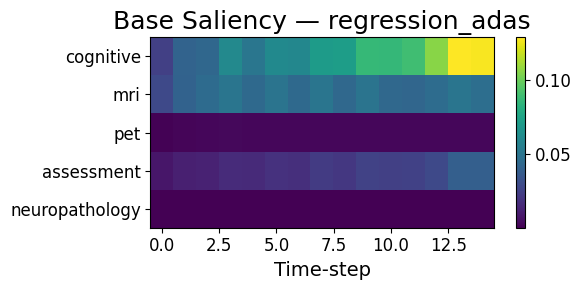

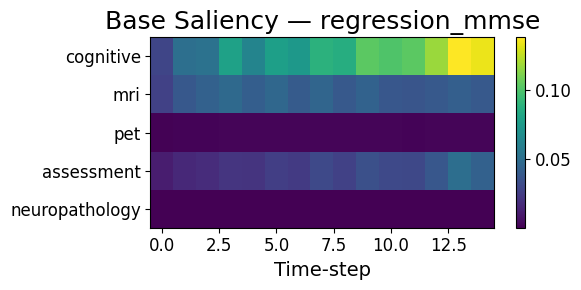

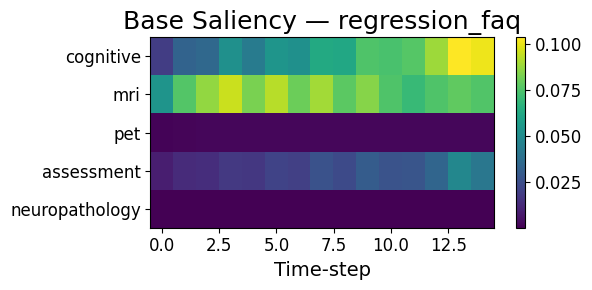

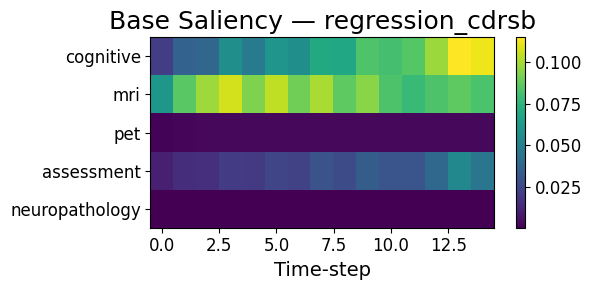

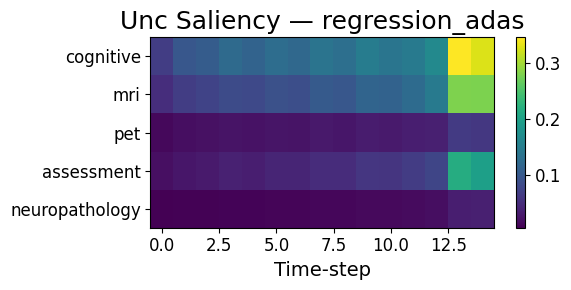

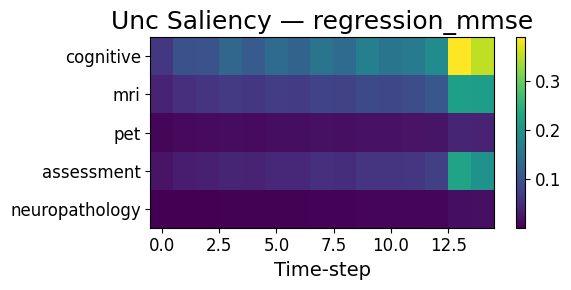

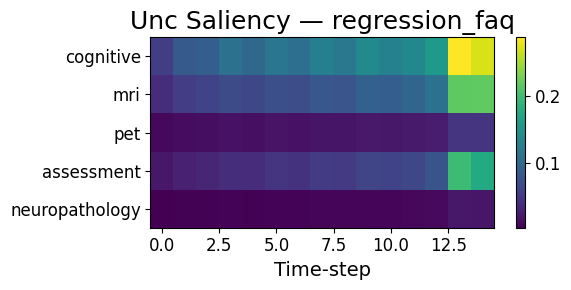

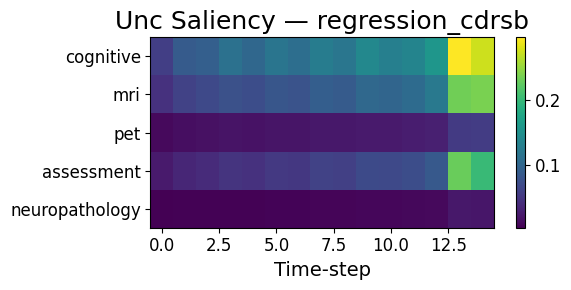

Saved top-only snapshot metrics to /mnt/data/snapshot_metrics_toponly.csv


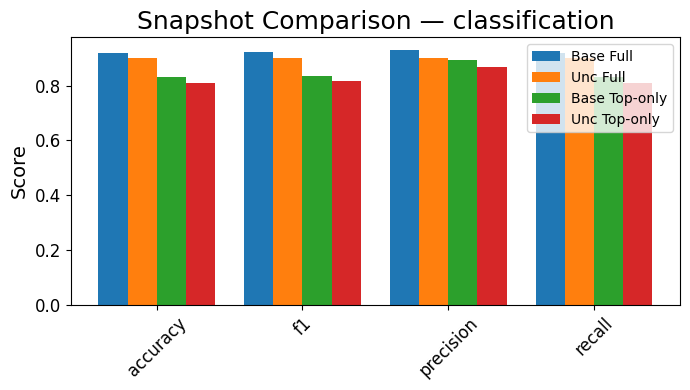

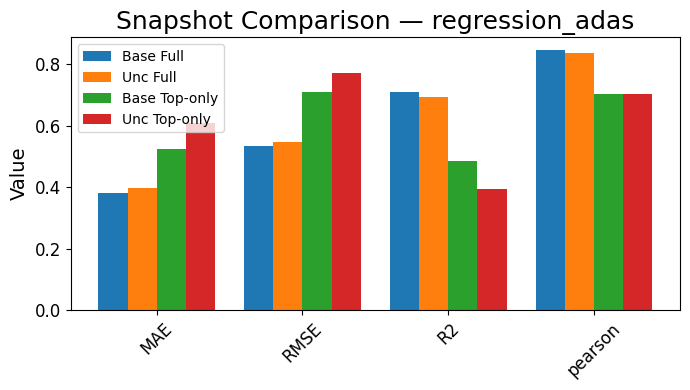

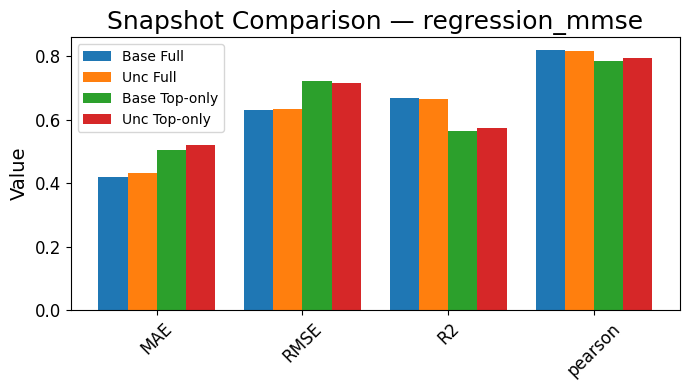

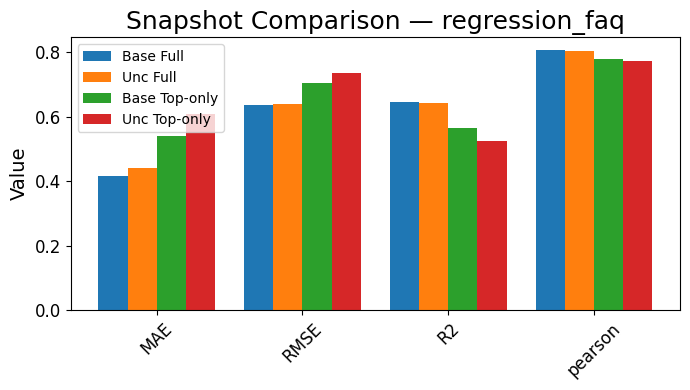

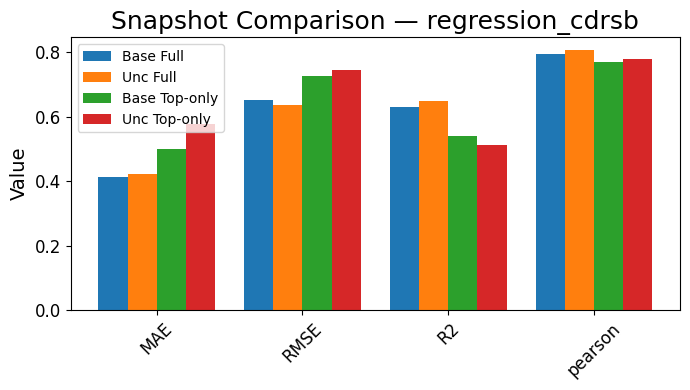

In [30]:
# Full vs Top-K Snapshot Analysis with Saliency Integration
from scipy.stats import ttest_rel, pearsonr
from sklearn.metrics import f1_score, precision_score, recall_score, r2_score, mean_absolute_error, mean_squared_error
import numpy as np, pandas as pd, os
from pathlib import Path

# 1) Helper for regression snapshots
def snapshot_metrics(model, Xs, y_true, head_idx):
    preds = model.predict(Xs, verbose=0)[head_idx].flatten()
    return {
        "MAE":     mean_absolute_error(y_true, preds),
        "RMSE":    np.sqrt(mean_squared_error(y_true, preds)),
        "R2":      r2_score(y_true, preds),
        "pearson": pearsonr(y_true, preds)[0] if len(y_true)>1 else np.nan
    }

# 2) Build df_snap for full-input snapshot comparison
snapshot_results = {"task":[], "metric":[], "base":[], "unc":[]}

# 2a) Classification
y_true    = y_te_plot["classification"]
y_pred_b0 = np.argmax(preds_b_plot[0], axis=1)
y_pred_u0 = np.argmax(preds_u_plot[0], axis=1)

cls_base = {
    "accuracy":  accuracy_score(y_true, y_pred_b0),
    "f1":        f1_score(y_true, y_pred_b0, average="weighted", zero_division=0),
    "precision": precision_score(y_true, y_pred_b0, average="weighted", zero_division=0),
    "recall":    recall_score(y_true, y_pred_b0, average="weighted",  zero_division=0),
}
cls_unc = {
    "accuracy":  accuracy_score(y_true, y_pred_u0),
    "f1":        f1_score(y_true, y_pred_u0, average="weighted", zero_division=0),
    "precision": precision_score(y_true, y_pred_u0, average="weighted", zero_division=0),
    "recall":    recall_score(y_true, y_pred_u0, average="weighted",  zero_division=0),
}

for m in cls_base:
    snapshot_results["task"].append("classification")
    snapshot_results["metric"].append(m)
    snapshot_results["base"].append(cls_base[m])
    snapshot_results["unc"].append(cls_unc[m])

# 2b) Regression
reg_heads = out_order[1:]
for head in reg_heads:
    hi = out_order.index(head)
    sb = snapshot_metrics(base_plot, X_te_plot, y_te_plot[head].flatten(), hi)
    su = snapshot_metrics(unc_plot,  X_te_plot, y_te_plot[head].flatten(), hi)
    for m in sb:
        snapshot_results["task"].append(head)
        snapshot_results["metric"].append(m)
        snapshot_results["base"].append(sb[m])
        snapshot_results["unc"].append(su[m])

df_snap = pd.DataFrame(snapshot_results)
os.makedirs("/mnt/data", exist_ok=True)
df_snap.to_csv("/mnt/data/snapshot_metrics_full.csv", index=False)
print("Saved full-input snapshot metrics to /mnt/data/snapshot_metrics_full.csv")

# 3) Compute and store saliency maps for each regression head
modalities = MODALITY_KEYS # keep ordering consistent with model inputs
saliency_maps = {}

for model, title in [(base_plot, "Base"), (unc_plot, "Unc")]:
    for idx, head in enumerate(reg_heads, start=1):
        sal_map = np.stack([
            compute_saliency_ts(model, X_te_plot, mi, idx)
            for mi in range(len(modalities))
        ])  # shape = (n_modalities, T)
        saliency_maps[(title, head)] = sal_map

        # plot heatmap
        plt.figure(figsize=(6,3))
        plt.imshow(sal_map, aspect='auto')
        plt.yticks(range(len(modalities)), modalities)
        plt.xlabel("Time-step")
        plt.title(f"{title} Saliency — {head}")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

# 4) Pick the top_k most salient cells from one map
top_k = 5
# choose saliency map (e.g. Base + regression_mmse)
sal_map_full = saliency_maps[("Base", "regression_mmse")]

flat_sal = sal_map_full.ravel()
top_inds = np.argsort(flat_sal)[::-1][:top_k]
mod_idx, time_idx = np.unravel_index(top_inds, sal_map_full.shape)
top_pairs = list(zip(mod_idx, time_idx))

# 5) Use the canonical mask_top_K
Xs_top = mask_top_K(X_te_plot, top_pairs, n_mods=len(MODALITY_KEYS))

# 6) Run snapshot metrics on the masked (“top-only”) inputs
# 6a) Classification
y_pred_b_top = np.argmax(base_plot.predict(Xs_top, verbose=0)[0], axis=1)
y_pred_u_top = np.argmax(unc_plot.predict(Xs_top,  verbose=0)[0], axis=1)
cls_base_top = {
    "accuracy":  accuracy_score(y_true, y_pred_b_top),
    "f1":        f1_score(y_true, y_pred_b_top, average="weighted", zero_division=0),
    "precision": precision_score(y_true, y_pred_b_top, average="weighted", zero_division=0),
    "recall":    recall_score(y_true, y_pred_b_top, average="weighted",  zero_division=0),
}
cls_unc_top = {
    "accuracy":  accuracy_score(y_true, y_pred_u_top),
    "f1":        f1_score(y_true, y_pred_u_top, average="weighted", zero_division=0),
    "precision": precision_score(y_true, y_pred_u_top, average="weighted", zero_division=0),
    "recall":    recall_score(y_true, y_pred_u_top, average="weighted",  zero_division=0),
}

# 6b) Regression
reg_base_top = {}
reg_unc_top  = {}
for head in reg_heads:
    hi = out_order.index(head)
    reg_base_top[head] = snapshot_metrics(base_plot, Xs_top, y_te_plot[head].flatten(), hi)
    reg_unc_top[head]  = snapshot_metrics(unc_plot,  Xs_top, y_te_plot[head].flatten(), hi)

# 7) Build df_snap_top and save
top_results = {"task":[], "metric":[], "base":[], "unc":[]}
for m in cls_base_top:
    top_results["task"].append("classification")
    top_results["metric"].append(m)
    top_results["base"].append(cls_base_top[m])
    top_results["unc"].append(cls_unc_top[m])
for head in reg_heads:
    for m, v in reg_base_top[head].items():
        top_results["task"].append(head)
        top_results["metric"].append(m)
        top_results["base"].append(v)
        top_results["unc"].append(reg_unc_top[head][m])

df_snap_top = pd.DataFrame(top_results)
df_snap_top.to_csv("/mnt/data/snapshot_metrics_toponly.csv", index=False)
print("Saved top-only snapshot metrics to /mnt/data/snapshot_metrics_toponly.csv")

# 8) Side-by-side plotting: Full vs. Top-Only
for task in df_snap["task"].unique():
    full = df_snap[df_snap["task"] == task].reset_index(drop=True)
    top  = df_snap_top[df_snap_top["task"] == task].reset_index(drop=True)
    x    = np.arange(len(full))
    w    = 0.2

    plt.figure(figsize=(7,4))
    plt.bar(x - 1.5*w, full["base"], w, label="Base Full")
    plt.bar(x - 0.5*w, full["unc"],  w, label="Unc Full")
    plt.bar(x + 0.5*w, top["base"],  w, label="Base Top-only")
    plt.bar(x + 1.5*w, top["unc"],   w, label="Unc Top-only")

    plt.xticks(x, full["metric"], rotation=45)
    plt.ylabel("Score" if task=="classification" else "Value")
    plt.title(f"Snapshot Comparison — {task}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

This script performs post-training statistical analysis for a selected `plot_seed` fold, comparing performance between full longitudinal inputs and Top-K saliency-masked inputs. It first loads the test split and predictions for both Base and Unc models, then computes saliency maps for the selected regression head (default `regression_mmse`), selects the top five most salient `(modality, timestep)` pairs, and applies `mask_top_K()` to create Top-only inputs. Both models are then run on full and Top-only inputs for classification and regression tasks. Paired t-tests are conducted on per-sample classification accuracy and regression MAE/RMSE, with macro-F1, macro-precision, macro-recall, R², and Pearson correlations reported as point estimates. Finally, the script computes 95% bootstrap confidence intervals for all metrics using the `bootstrap_snapshot_ci_from_preds()` helper.

In [31]:
# === Post-training: Paired t-tests + 95% bootstrap CIs (for plot_seed) ===

# 0) Ensure we have the fold’s test set + predictions for plot_seed
seed = plot_seed
split = next(s for s in all_splits if s["seed"] == seed)
scaler_reg = split["regression_scaler"]

if "X_te_plot" not in globals() or "y_te_plot" not in globals():
    X_te_plot, y_te_plot, R_te_plot = make_split(split["test_ids"], ds_aligned, subject_diag_common, scaler_reg)

if "preds_b_plot" not in globals() or "preds_u_plot" not in globals():
    preds_b_plot = base_plot.predict(X_te_plot, verbose=0)
    preds_u_plot = unc_plot.predict(X_te_plot, verbose=0)

# 1) If Top-K not computed yet, compute saliency - top_pairs - Xs_top
modalities = MODALITY_KEYS
reg_heads  = out_order[1:]
sel_head   = "regression_mmse" if "regression_mmse" in reg_heads else reg_heads[0]
head_idx   = out_order.index(sel_head)
top_k      = 5

if "Xs_top" not in globals() or "top_pairs" not in globals():
    sal_map = np.stack([compute_saliency_ts(base_plot, X_te_plot, mi, head_idx)
                        for mi in range(len(modalities))])  # (n_mods, T)
    flat = sal_map.ravel()
    top_inds = np.argsort(flat)[::-1][:top_k]
    mod_idx, time_idx = np.unravel_index(top_inds, sal_map.shape)
    top_pairs = list(zip(mod_idx, time_idx))
    # preserve n_mods usage
    Xs_top = mask_top_K(X_te_plot, top_pairs, n_mods=len(MODALITY_KEYS))

# 2) Build preds needed for tests
y_true        = y_te_plot["classification"].astype(int)
y_pred_b0     = np.argmax(preds_b_plot[0], axis=1)
y_pred_u0     = np.argmax(preds_u_plot[0], axis=1)
y_pred_b_top  = np.argmax(base_plot.predict(Xs_top, verbose=0)[0], axis=1)
y_pred_u_top  = np.argmax(unc_plot.predict( Xs_top, verbose=0)[0], axis=1)

# 3) Paired t-tests + summary table
results = []

# 3a) Classification — paired t-test on per-sample accuracy; macro F1/prec/rec as point estimates
for label, full_arr, top_arr, y_pred_full, y_pred_top in [
    ("Base", (y_pred_b0 == y_true).astype(int), (y_pred_b_top == y_true).astype(int), y_pred_b0, y_pred_b_top),
    ("Unc",  (y_pred_u0 == y_true).astype(int), (y_pred_u_top == y_true).astype(int), y_pred_u0, y_pred_u_top),
]:
    tstat, pval = ttest_rel(full_arr, top_arr)
    df_val = len(full_arr) - 1
    results.append({
        "task":"classification","model":label,"metric":"accuracy",
        "full_mean":full_arr.mean(), "full_sd":full_arr.std(ddof=1),
        "top_mean": top_arr.mean(),  "top_sd": top_arr.std(ddof=1),
        "t_stat":tstat, "df":df_val, "p_value":pval,
        "cohen_d_z": ((full_arr - top_arr).mean() / (full_arr - top_arr).std(ddof=1))
    })
    for metric_name, fn in [
        ("F1",        lambda y,p: f1_score(y,p,average="macro")),
        ("precision", lambda y,p: precision_score(y,p,average="macro", zero_division=0)),
        ("recall",    lambda y,p: recall_score(y,p,average="macro",  zero_division=0)),
    ]:
        results.append({
            "task":"classification","model":label,"metric":metric_name,
            "full_mean":fn(y_true, y_pred_full), "full_sd":np.nan,
            "top_mean": fn(y_true, y_pred_top),  "top_sd":np.nan,
            "t_stat":np.nan, "df":np.nan, "p_value":np.nan, "cohen_d_z":np.nan
        })

# 3b) Regression — paired t-tests on MAE (abs error) and squared error for RMSE
for head in reg_heads:
    hi         = out_order.index(head)
    y_true_reg = y_te_plot[head].flatten() # standardized scale

    pred_full_b = base_plot.predict(X_te_plot, verbose=0)[hi].flatten()
    pred_top_b  = base_plot.predict(Xs_top,    verbose=0)[hi].flatten()
    pred_full_u = unc_plot .predict(X_te_plot, verbose=0)[hi].flatten()
    pred_top_u  = unc_plot .predict(Xs_top,    verbose=0)[hi].flatten()

    for label, pf, pt in [("Base", pf := pred_full_b, pt := pred_top_b),
                          ("Unc",  pf := pred_full_u, pt := pred_top_u)]:
        err_full = np.abs(pf - y_true_reg)
        err_top  = np.abs(pt - y_true_reg)

        # MAE paired t-test
        t_mae, p_mae = ttest_rel(err_full, err_top)
        d_mae = (err_full - err_top).mean() / (err_full - err_top).std(ddof=1)
        results.append({
            "task":head,"model":label,"metric":"MAE",
            "full_mean":err_full.mean(), "full_sd":err_full.std(ddof=1),
            "top_mean": err_top.mean(),  "top_sd": err_top.std(ddof=1),
            "t_stat":t_mae, "df":len(err_full)-1, "p_value":p_mae, "cohen_d_z":d_mae
        })

        # RMSE via squared errors (paired t-test)
        sqf, sqt = err_full**2, err_top**2
        t_rmse, p_rmse = ttest_rel(sqf, sqt)
        d_rmse = (sqf - sqt).mean() / (sqf - sqt).std(ddof=1)
        results.append({
            "task":head,"model":label,"metric":"RMSE",
            "full_mean":np.sqrt(sqf.mean()), "full_sd":np.nan,
            "top_mean": np.sqrt(sqt.mean()), "top_sd":np.nan,
            "t_stat":t_rmse, "df":len(sqf)-1, "p_value":p_rmse, "cohen_d_z":d_rmse
        })

        # R2 and Pearson (point estimates only)
        r2_f = r2_score(y_true_reg, pf); r2_t = r2_score(y_true_reg, pt)
        pr_f = pearsonr(y_true_reg, pf)[0]; pr_t = pearsonr(y_true_reg, pt)[0]
        for mn, vf, vt in [("R2", r2_f, r2_t), ("pearson", pr_f, pr_t)]:
            results.append({
                "task":head,"model":label,"metric":mn,
                "full_mean":vf, "full_sd":np.nan, "top_mean":vt, "top_sd":np.nan,
                "t_stat":np.nan, "df":np.nan, "p_value":np.nan, "cohen_d_z":np.nan
            })

df_stats = pd.DataFrame(results)
print("\n=== Paired t-tests & point estimates (plot_seed) ===")
print(df_stats.to_string(index=False))
os.makedirs("/mnt/data", exist_ok=True)
out_stats = f"/mnt/data/snapshot_stats_complete_seed{seed}.csv"
df_stats.to_csv(out_stats, index=False)
print(f"Saved to {out_stats}")

# 4) 95% bootstrap CIs (no retraining) — uses helper bootstrap_snapshot_ci_from_preds
ci_path = f"/mnt/data/bootstrap_snapshot_seed{seed}.csv"
agg_ci, draws = bootstrap_snapshot_ci_from_preds(
    X_te_plot, y_te_plot, preds_b_plot, preds_u_plot,
    base_plot, unc_plot,
    input_shapes, out_order,
    top_pairs=top_pairs, B=1000, save_csv=ci_path
)
print("\n=== 95% Bootstrap CIs (plot_seed) ===")
print(agg_ci.to_string(index=False))
print(f"Saved CIs to {ci_path}")


=== Paired t-tests & point estimates (plot_seed) ===
            task model    metric  full_mean  full_sd  top_mean   top_sd     t_stat    df      p_value  cohen_d_z
  classification  Base  accuracy   0.920879 0.270224  0.830769 0.375368   5.832549 454.0 1.038131e-08   0.273434
  classification  Base        F1   0.910984      NaN  0.814526      NaN        NaN   NaN          NaN        NaN
  classification  Base precision   0.897430      NaN  0.823354      NaN        NaN   NaN          NaN        NaN
  classification  Base    recall   0.935236      NaN  0.875328      NaN        NaN   NaN          NaN        NaN
  classification   Unc  accuracy   0.901099 0.298858  0.810989 0.391948   4.434224 454.0 1.160387e-05   0.207880
  classification   Unc        F1   0.882871      NaN  0.798357      NaN        NaN   NaN          NaN        NaN
  classification   Unc precision   0.887606      NaN  0.803393      NaN        NaN   NaN          NaN        NaN
  classification   Unc    recall   0.87860

C:\Users\Asus\AppData\Local\Temp\ipykernel_14292\295530839.py:163: FutureWarning: The provided callable <function nanmean at 0x00000244FFC1E020> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(mean=np.nanmean,
